# 24-1. Project: 모델 바꿔보기

### 라이브러리 버전 확인
---
프로젝트에 사용할 주요 라이브러리 버전을 확인해봅니다.

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

2.6.0
1.21.4
8.3.2
1.7.0


### simplebaseline 모델로 변경해 봅시다
---
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

### MPII 데이터셋 다운로드하기
---
오늘은 MPII Human Pose Dataset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜 보겠습니다.

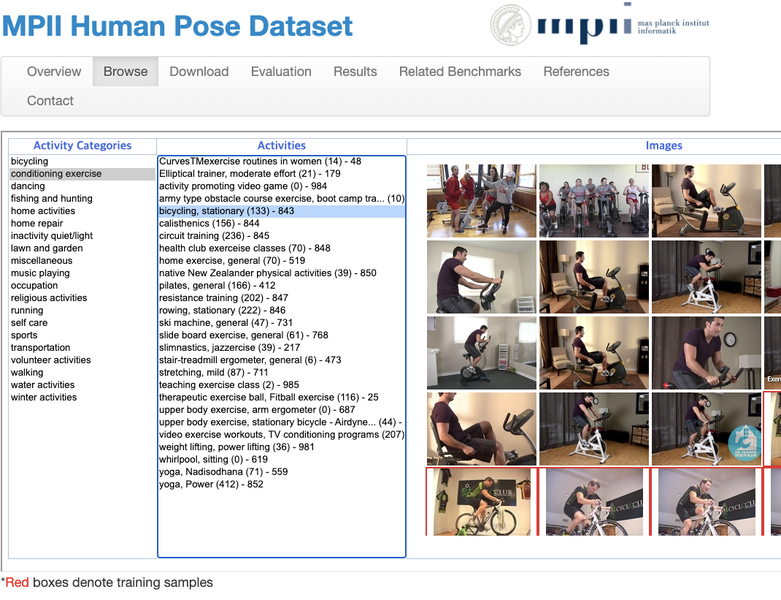
http://human-pose.mpi-inf.mpg.de/#download  

미리 준비해 둔 데이터를 연결하고 압축을 해제해 주세요.
```bash
$ mkdir -p ~/aiffel/mpii
$ ln -s ~/data/* ~/aiffel/mpii
$ cd ~/aiffel/mpii
$ tar -xvf mpii_human_pose_v1.tar.gz -C . 
$ unzip mpii_human_pose_v1_u12_2.zip
```

mpii_human_pose_v1_u12_2.zip 을 풀어보면 mpii_human_pose_v1_u12_1.mat 파일이 나와서 열어보기 불편한데요. 파이썬에서 읽기 쉽도록 json 파일로 변환해 두었습니다.

```bash
$ cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json
```

mpii.zip
마지막으로, 오늘의 실습 코드를 프로젝트로 구성한 파일을 압축 해제합니다.

```bash
$ cd ~/aiffel/mpii && unzip mpii.zip
```

이번 노드에서는 이 프로젝트 파일을 LMS환경에 맞게 편집하여 진행합니다. .py 파일 원본을 확인하면 학습에 도움이 되실거예요.

In [2]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

MODEL_CUSTOM_PATH = os.path.join(PROJECT_PATH, 'models_custom')
print('슝=3')

슝=3


In [3]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.applications import ResNet50

In [4]:
EPOCHS = 10
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

### 데이터 전처리

#### json 파싱

In [5]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [6]:
# json annotation 파싱 함수
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [7]:
# parse_one_annotation 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [8]:
# TFRecord로 변환하는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [9]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [10]:
# 하나의 chunk를 TFRecord로 만들어 주는 함수
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [11]:
# 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다. 시간이 꽤 걸립니다.

In [12]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-01-03 07:48:10,551	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.77gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=748) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=748) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=749) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=749) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=750) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=750) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=749) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=749) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=748) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=748) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=749) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=749) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=748) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=748) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=750) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=750) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

### data label 로 만들기

In [13]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


### 평가 지표 구현

#### mAP

In [14]:
class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, name='mAP', threshold=0.5, **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.total_ground_truths = self.add_weight(name='gt', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        oks = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))
        correct_keypoints = tf.cast(oks < self.threshold, tf.float32)
        
        self.true_positives.assign_add(tf.reduce_sum(correct_keypoints))
        self.false_positives.assign_add(tf.reduce_sum(1 - correct_keypoints))
        self.total_ground_truths.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.total_ground_truths + 1e-7)
        return (precision + recall) / 2

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.total_ground_truths.assign(0)

(build_single_tfrecord pid=749) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


#### PCHK-0.5

In [15]:
class PCKh(tf.keras.metrics.Metric):
    def __init__(self, name='PCKh-0.5', threshold=0.5, **kwargs):
        super(PCKh, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.correct_keypoints = self.add_weight(name='correct', initializer='zeros')
        self.total_keypoints = self.add_weight(name='total', initializer='zeros')
    
    def update_state(self, y_true, y_pred, head_length, sample_weight=None):
        distances = tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1))
        normalized_distances = distances / head_length
        correct = tf.cast(normalized_distances < self.threshold, tf.float32)
        
        self.correct_keypoints.assign_add(tf.reduce_sum(correct))
        self.total_keypoints.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        return self.correct_keypoints / (self.total_keypoints + 1e-7)
    
    def reset_states(self):
        self.correct_keypoints.assign(0)
        self.total_keypoints.assign(0)

### Hourglass 모델 만들기

In [16]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [17]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [18]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [19]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


### 학습 엔진 만들기
- GPU 가 여러 개인 환경
- loss 와 학습률 시각화 기능 추가
- SimpleBaseline에 맞게 outputs 이 단일 텐서일 경우도 처리하도록 코드를 보완
    - Hourglass 모델 출력: 여러 단계에서 히트맵이 출력됨 → outputs는 리스트 형태로 여러 히트맵을 포함
	- SimpleBaseline 모델 출력: 마지막 히트맵만 출력됨 → outputs는 단일 텐서
- 평가 지표 추가하기(mAP, PCKh-0.5)

In [20]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        # 추가: mAP와 PCKh-0.5 메트릭 초기화
        self.map_metric = MeanAveragePrecision(threshold=0.5)
        self.pckh_metric = PCKh(threshold=0.5)
        
        # mAP 및 PCKh 기록
        self.train_map = []  # Train mAP 기록
        self.val_map = []    # Val mAP 기록
        self.train_pckh = []  # Train PCKh 기록
        self.val_pckh = []    # Val PCKh 기록
        
        # 추가됨: 손실 및 학습률을 기록하기 위한 리스트
        self.train_losses = []  # Train Loss 기록
        self.val_losses = []    # Validation Loss 기록
        self.learning_rates = []  # Learning Rate 기록

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        
        # 추가됨: outputs를 리스트로 강제 변환
        if not isinstance(outputs, list):
            outputs = [outputs]
        
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))
        
        # 추가됨 : 메트릭 업데이트
        self.map_metric.update_state(labels, outputs)
        self.pckh_metric.update_state(labels, outputs, head_length=1.0)  # Head Length는 데이터셋에 맞게 조정 필요
        
        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        
        # 메트릭 업데이트
        self.map_metric.update_state(labels, outputs)
        self.pckh_metric.update_state(labels, outputs, head_length=1.0)  # Head Length는 데이터셋에 맞게 조정 필요
        
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            # 추가됨 메트릭 기록
            print('Epoch {} train loss {}, mAP {}, PCKh {}'.format(
                epoch, train_loss, self.map_metric.result(), self.pckh_metric.result()
            ))
            print('Epoch {} val loss {}, mAP {}, PCKh {}'.format(
                epoch, val_loss, self.map_metric.result(), self.pckh_metric.result()
            ))
            self.train_map.append(self.map_metric.result().numpy())
            self.val_map.append(self.map_metric.result().numpy())
            self.train_pckh.append(self.pckh_metric.result().numpy())
            self.val_pckh.append(self.pckh_metric.result().numpy())
            
            # 추가됨: 손실 및 학습률 기록
            self.train_losses.append(train_loss.numpy())  # Train Loss 기록
            self.val_losses.append(val_loss.numpy())      # Validation Loss 기록
            self.learning_rates.append(self.current_learning_rate)  # Learning Rate 기록

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        # 추가됨: 학습 종료 후 시각화
        self.plot_metrics()
        
        return self.best_model

#     def save_model(self, epoch, loss):
#         model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
#         self.model.save_weights(model_name)
#         self.best_model = model_name
#         print("Model {} saved.".format(model_name))

    def save_model(self, epoch, loss):
        """
        모델을 저장할 때 StackedHourglassNetwork와 SimpleBaseline에 따라 파일 이름을 구분
        """
        # 모델 타입 확인
        model_type = self.model.name if hasattr(self.model, 'name') else 'unknown_model'

        # 저장 경로 및 파일명 설정
        # MODEL_PATH 는 쓰기 권한 문제로 MODEL_CUSTOM_PATH 로 변경
        model_name = f"{MODEL_CUSTOM_PATH}/{model_type}-epoch-{epoch}-loss-{loss:.4f}.h5"

        # 모델 저장
        self.model.save_weights(model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")
    
    # 추가됨: 시각화 함수
    def plot_metrics(self):
        """학습 손실, 검증 손실, 학습률을 시각화합니다."""
        epochs = range(1, len(self.train_losses) + 1)

        plt.figure(figsize=(16, 5))

        # Train Loss vs Val Loss
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_losses, label='Train Loss')
        plt.plot(epochs, self.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Learning Rate
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.learning_rates, label='Learning Rate', color='orange')
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()
        
        # Train mAP vs Val mAP
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_map, label='Train mAP')
        plt.plot(epochs, self.val_map, label='Val mAP')
        plt.plot(epochs, self.train_pckh, label='Train PCKh')
        plt.plot(epochs, self.val_pckh, label='Val PCKh')
        plt.title('mAP and PCKh')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [21]:
# 데이터셋 make 함수
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

데이터셋과 모델, 훈련용 객체를 조립만하면 되겠군요. 주의할 점은 with strategy.scope():부분이 반드시 필요하다는 점이에요. 또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요해요.

In [22]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_CUSTOM_PATH):
        os.makedirs(MODEL_CUSTOM_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.484272 epoch total loss 2.484272
Trained batch 2 batch loss 2.50678 epoch total loss 2.49552584
Trained batch 3 batch loss 2.41848898 epoch total loss 2.46984696
Trained batch 4 batch loss 2.42962456 epoch total loss 2.45979118
Trained batch 5 batch loss 2.33522749 epoch total loss 2.43487859
Trained batch 6 batch loss 2.24061966 epoch total loss 2.40250206
Trained batch 7 batch loss 1.96389711 epoch total loss 2.33984423
Trained batch 8 batch loss 2.06294322 epoch total loss 2.30523157
Trained batch 9 batch loss 2.18053317 epoch total loss 2.29137611
Trained batch 10 batch loss 2.13820124 epoch total loss 2.27605867
Trained batch 11 batch loss 1.95498478 epoch total loss 2.24687
Trained batch 12 batch loss 1.96014094 epoch total loss 2.22297597
Trained batch 13 batch loss 1.96927071 epoch total loss 2.20346022
Trained batch 14 batch loss 1.86680114 epoch total loss 2.17941308
Trained batch 15 batch loss 2.02027917 epoch total

Trained batch 124 batch loss 1.65083861 epoch total loss 1.78383732
Trained batch 125 batch loss 1.77397716 epoch total loss 1.7837584
Trained batch 126 batch loss 1.64818811 epoch total loss 1.78268254
Trained batch 127 batch loss 1.73799443 epoch total loss 1.78233063
Trained batch 128 batch loss 1.63567591 epoch total loss 1.78118491
Trained batch 129 batch loss 1.52530313 epoch total loss 1.77920127
Trained batch 130 batch loss 1.50033164 epoch total loss 1.77705622
Trained batch 131 batch loss 1.34755421 epoch total loss 1.77377748
Trained batch 132 batch loss 1.3864646 epoch total loss 1.77084327
Trained batch 133 batch loss 1.5441004 epoch total loss 1.76913846
Trained batch 134 batch loss 1.63237512 epoch total loss 1.76811779
Trained batch 135 batch loss 1.79832935 epoch total loss 1.76834154
Trained batch 136 batch loss 1.76146221 epoch total loss 1.76829088
Trained batch 137 batch loss 1.55070662 epoch total loss 1.76670265
Trained batch 138 batch loss 1.57735848 epoch total

Trained batch 245 batch loss 1.66505086 epoch total loss 1.70144582
Trained batch 246 batch loss 1.59009469 epoch total loss 1.70099306
Trained batch 247 batch loss 1.62559044 epoch total loss 1.70068777
Trained batch 248 batch loss 1.54017544 epoch total loss 1.70004046
Trained batch 249 batch loss 1.60811687 epoch total loss 1.69967139
Trained batch 250 batch loss 1.57990873 epoch total loss 1.69919229
Trained batch 251 batch loss 1.53301549 epoch total loss 1.6985302
Trained batch 252 batch loss 1.54748464 epoch total loss 1.69793081
Trained batch 253 batch loss 1.6138773 epoch total loss 1.6975987
Trained batch 254 batch loss 1.68731976 epoch total loss 1.69755816
Trained batch 255 batch loss 1.60076249 epoch total loss 1.6971786
Trained batch 256 batch loss 1.42998803 epoch total loss 1.69613492
Trained batch 257 batch loss 1.57238674 epoch total loss 1.69565344
Trained batch 258 batch loss 1.60938561 epoch total loss 1.69531906
Trained batch 259 batch loss 1.69500315 epoch total 

Trained batch 366 batch loss 1.53093505 epoch total loss 1.66208303
Trained batch 367 batch loss 1.43202257 epoch total loss 1.66145611
Trained batch 368 batch loss 1.61988437 epoch total loss 1.6613431
Trained batch 369 batch loss 1.54001641 epoch total loss 1.66101444
Trained batch 370 batch loss 1.58107245 epoch total loss 1.66079831
Trained batch 371 batch loss 1.57386541 epoch total loss 1.66056395
Trained batch 372 batch loss 1.55602276 epoch total loss 1.66028297
Trained batch 373 batch loss 1.53945243 epoch total loss 1.65995896
Trained batch 374 batch loss 1.4985292 epoch total loss 1.6595273
Trained batch 375 batch loss 1.61085165 epoch total loss 1.65939748
Trained batch 376 batch loss 1.49395716 epoch total loss 1.65895748
Trained batch 377 batch loss 1.41641784 epoch total loss 1.65831423
Trained batch 378 batch loss 1.25347304 epoch total loss 1.65724325
Trained batch 379 batch loss 1.29841852 epoch total loss 1.65629637
Trained batch 380 batch loss 1.57159019 epoch total

Trained batch 488 batch loss 1.56299269 epoch total loss 1.63072598
Trained batch 489 batch loss 1.58761823 epoch total loss 1.63063788
Trained batch 490 batch loss 1.49125099 epoch total loss 1.63035345
Trained batch 491 batch loss 1.51832628 epoch total loss 1.63012516
Trained batch 492 batch loss 1.55246937 epoch total loss 1.62996745
Trained batch 493 batch loss 1.63474751 epoch total loss 1.62997711
Trained batch 494 batch loss 1.7488606 epoch total loss 1.63021779
Trained batch 495 batch loss 1.68971491 epoch total loss 1.63033795
Trained batch 496 batch loss 1.59517193 epoch total loss 1.63026702
Trained batch 497 batch loss 1.60397136 epoch total loss 1.63021398
Trained batch 498 batch loss 1.72056699 epoch total loss 1.63039553
Trained batch 499 batch loss 1.65814805 epoch total loss 1.63045108
Trained batch 500 batch loss 1.46636486 epoch total loss 1.6301229
Trained batch 501 batch loss 1.59332526 epoch total loss 1.63004947
Trained batch 502 batch loss 1.55694652 epoch tota

Trained batch 609 batch loss 1.52885962 epoch total loss 1.61655617
Trained batch 610 batch loss 1.4883405 epoch total loss 1.616346
Trained batch 611 batch loss 1.48665714 epoch total loss 1.61613369
Trained batch 612 batch loss 1.51373625 epoch total loss 1.61596644
Trained batch 613 batch loss 1.57122648 epoch total loss 1.61589336
Trained batch 614 batch loss 1.51457822 epoch total loss 1.61572838
Trained batch 615 batch loss 1.5183723 epoch total loss 1.61557007
Trained batch 616 batch loss 1.46518731 epoch total loss 1.61532605
Trained batch 617 batch loss 1.46053886 epoch total loss 1.61507511
Trained batch 618 batch loss 1.54677153 epoch total loss 1.6149646
Trained batch 619 batch loss 1.52126288 epoch total loss 1.61481309
Trained batch 620 batch loss 1.48526776 epoch total loss 1.61460423
Trained batch 621 batch loss 1.38414061 epoch total loss 1.61423314
Trained batch 622 batch loss 1.51764631 epoch total loss 1.61407781
Trained batch 623 batch loss 1.47939956 epoch total l

Trained batch 730 batch loss 1.38020456 epoch total loss 1.60134912
Trained batch 731 batch loss 1.50891042 epoch total loss 1.60122263
Trained batch 732 batch loss 1.37257123 epoch total loss 1.60091031
Trained batch 733 batch loss 1.37691295 epoch total loss 1.60060477
Trained batch 734 batch loss 1.52348888 epoch total loss 1.60049963
Trained batch 735 batch loss 1.60193753 epoch total loss 1.60050154
Trained batch 736 batch loss 1.51653075 epoch total loss 1.60038745
Trained batch 737 batch loss 1.48370826 epoch total loss 1.60022914
Trained batch 738 batch loss 1.46606207 epoch total loss 1.60004735
Trained batch 739 batch loss 1.49576283 epoch total loss 1.59990621
Trained batch 740 batch loss 1.52490187 epoch total loss 1.59980488
Trained batch 741 batch loss 1.58388674 epoch total loss 1.5997833
Trained batch 742 batch loss 1.52329707 epoch total loss 1.5996803
Trained batch 743 batch loss 1.49512315 epoch total loss 1.59953952
Trained batch 744 batch loss 1.41012955 epoch tota

Trained batch 852 batch loss 1.47240305 epoch total loss 1.58652091
Trained batch 853 batch loss 1.47152364 epoch total loss 1.58638608
Trained batch 854 batch loss 1.39294946 epoch total loss 1.58615959
Trained batch 855 batch loss 1.48184419 epoch total loss 1.58603764
Trained batch 856 batch loss 1.45387089 epoch total loss 1.58588314
Trained batch 857 batch loss 1.47384667 epoch total loss 1.58575249
Trained batch 858 batch loss 1.50265789 epoch total loss 1.58565569
Trained batch 859 batch loss 1.64155281 epoch total loss 1.58572078
Trained batch 860 batch loss 1.62637758 epoch total loss 1.58576798
Trained batch 861 batch loss 1.71512508 epoch total loss 1.58591819
Trained batch 862 batch loss 1.62921381 epoch total loss 1.58596849
Trained batch 863 batch loss 1.50427675 epoch total loss 1.58587384
Trained batch 864 batch loss 1.45964015 epoch total loss 1.58572769
Trained batch 865 batch loss 1.28060329 epoch total loss 1.58537495
Trained batch 866 batch loss 1.24596822 epoch to

Trained batch 973 batch loss 1.43105662 epoch total loss 1.57367349
Trained batch 974 batch loss 1.45624101 epoch total loss 1.57355297
Trained batch 975 batch loss 1.52944827 epoch total loss 1.57350779
Trained batch 976 batch loss 1.5263375 epoch total loss 1.57345939
Trained batch 977 batch loss 1.55422568 epoch total loss 1.57343972
Trained batch 978 batch loss 1.41094398 epoch total loss 1.57327354
Trained batch 979 batch loss 1.44464278 epoch total loss 1.57314217
Trained batch 980 batch loss 1.48912525 epoch total loss 1.57305646
Trained batch 981 batch loss 1.42521358 epoch total loss 1.57290566
Trained batch 982 batch loss 1.54824185 epoch total loss 1.57288063
Trained batch 983 batch loss 1.43110704 epoch total loss 1.57273638
Trained batch 984 batch loss 1.48991048 epoch total loss 1.57265222
Trained batch 985 batch loss 1.53553188 epoch total loss 1.57261443
Trained batch 986 batch loss 1.53129828 epoch total loss 1.57257259
Trained batch 987 batch loss 1.54709566 epoch tot

Trained batch 1093 batch loss 1.38319361 epoch total loss 1.56084132
Trained batch 1094 batch loss 1.35642934 epoch total loss 1.5606544
Trained batch 1095 batch loss 1.43341255 epoch total loss 1.56053829
Trained batch 1096 batch loss 1.39858329 epoch total loss 1.56039047
Trained batch 1097 batch loss 1.42955828 epoch total loss 1.56027126
Trained batch 1098 batch loss 1.33540881 epoch total loss 1.56006646
Trained batch 1099 batch loss 1.37485611 epoch total loss 1.55989802
Trained batch 1100 batch loss 1.52859664 epoch total loss 1.55986953
Trained batch 1101 batch loss 1.4074322 epoch total loss 1.55973113
Trained batch 1102 batch loss 1.6216104 epoch total loss 1.55978715
Trained batch 1103 batch loss 1.66858613 epoch total loss 1.55988586
Trained batch 1104 batch loss 1.46566713 epoch total loss 1.55980051
Trained batch 1105 batch loss 1.52816439 epoch total loss 1.5597719
Trained batch 1106 batch loss 1.41113651 epoch total loss 1.55963755
Trained batch 1107 batch loss 1.443116

Trained batch 1213 batch loss 1.44488704 epoch total loss 1.54919219
Trained batch 1214 batch loss 1.41938877 epoch total loss 1.54908538
Trained batch 1215 batch loss 1.49324274 epoch total loss 1.54903936
Trained batch 1216 batch loss 1.51081383 epoch total loss 1.54900801
Trained batch 1217 batch loss 1.46946847 epoch total loss 1.54894269
Trained batch 1218 batch loss 1.44045067 epoch total loss 1.54885364
Trained batch 1219 batch loss 1.36384594 epoch total loss 1.54870188
Trained batch 1220 batch loss 1.27082145 epoch total loss 1.54847407
Trained batch 1221 batch loss 1.3127085 epoch total loss 1.54828107
Trained batch 1222 batch loss 1.44075298 epoch total loss 1.5481931
Trained batch 1223 batch loss 1.52262187 epoch total loss 1.54817212
Trained batch 1224 batch loss 1.5115428 epoch total loss 1.54814231
Trained batch 1225 batch loss 1.57501507 epoch total loss 1.54816425
Trained batch 1226 batch loss 1.57037568 epoch total loss 1.54818237
Trained batch 1227 batch loss 1.52661

Trained batch 1333 batch loss 1.33332336 epoch total loss 1.54034436
Trained batch 1334 batch loss 1.31059456 epoch total loss 1.5401721
Trained batch 1335 batch loss 1.33530486 epoch total loss 1.54001856
Trained batch 1336 batch loss 1.26746583 epoch total loss 1.53981471
Trained batch 1337 batch loss 1.15871716 epoch total loss 1.53952956
Trained batch 1338 batch loss 1.1613636 epoch total loss 1.53924692
Trained batch 1339 batch loss 1.20622766 epoch total loss 1.53899837
Trained batch 1340 batch loss 1.42592883 epoch total loss 1.53891397
Trained batch 1341 batch loss 1.43855035 epoch total loss 1.5388391
Trained batch 1342 batch loss 1.46504748 epoch total loss 1.53878415
Trained batch 1343 batch loss 1.42907226 epoch total loss 1.53870237
Trained batch 1344 batch loss 1.46344662 epoch total loss 1.53864634
Trained batch 1345 batch loss 1.38558984 epoch total loss 1.5385325
Trained batch 1346 batch loss 1.46961665 epoch total loss 1.53848135
Trained batch 1347 batch loss 1.457074

Validated batch 107 batch loss 1.46286297
Validated batch 108 batch loss 1.4760735
Validated batch 109 batch loss 1.53853965
Validated batch 110 batch loss 1.25306201
Validated batch 111 batch loss 1.37840629
Validated batch 112 batch loss 1.40923882
Validated batch 113 batch loss 1.36221671
Validated batch 114 batch loss 1.56609488
Validated batch 115 batch loss 1.34244239
Validated batch 116 batch loss 1.32763529
Validated batch 117 batch loss 1.4539299
Validated batch 118 batch loss 1.47245932
Validated batch 119 batch loss 1.41664553
Validated batch 120 batch loss 1.47559035
Validated batch 121 batch loss 1.54658723
Validated batch 122 batch loss 1.31252754
Validated batch 123 batch loss 1.4307003
Validated batch 124 batch loss 1.38722348
Validated batch 125 batch loss 1.42134178
Validated batch 126 batch loss 1.42619061
Validated batch 127 batch loss 1.3516134
Validated batch 128 batch loss 1.18474901
Validated batch 129 batch loss 1.43877077
Validated batch 130 batch loss 1.43081

Trained batch 70 batch loss 1.32300699 epoch total loss 1.40401125
Trained batch 71 batch loss 1.31139946 epoch total loss 1.40270686
Trained batch 72 batch loss 1.4271698 epoch total loss 1.40304661
Trained batch 73 batch loss 1.53615785 epoch total loss 1.40487
Trained batch 74 batch loss 1.53841138 epoch total loss 1.40667462
Trained batch 75 batch loss 1.48754585 epoch total loss 1.40775299
Trained batch 76 batch loss 1.34942603 epoch total loss 1.40698552
Trained batch 77 batch loss 1.49031234 epoch total loss 1.4080677
Trained batch 78 batch loss 1.45814872 epoch total loss 1.40870965
Trained batch 79 batch loss 1.58865023 epoch total loss 1.4109875
Trained batch 80 batch loss 1.48121381 epoch total loss 1.41186535
Trained batch 81 batch loss 1.52924216 epoch total loss 1.41331446
Trained batch 82 batch loss 1.59759068 epoch total loss 1.41556168
Trained batch 83 batch loss 1.4477948 epoch total loss 1.41595
Trained batch 84 batch loss 1.46930456 epoch total loss 1.41658521
Train

Trained batch 192 batch loss 1.50156665 epoch total loss 1.4103874
Trained batch 193 batch loss 1.6059382 epoch total loss 1.41140056
Trained batch 194 batch loss 1.52875018 epoch total loss 1.41200542
Trained batch 195 batch loss 1.43564272 epoch total loss 1.41212654
Trained batch 196 batch loss 1.43523884 epoch total loss 1.41224456
Trained batch 197 batch loss 1.41117191 epoch total loss 1.41223907
Trained batch 198 batch loss 1.45348263 epoch total loss 1.41244733
Trained batch 199 batch loss 1.46824956 epoch total loss 1.41272783
Trained batch 200 batch loss 1.31089234 epoch total loss 1.41221857
Trained batch 201 batch loss 1.40547979 epoch total loss 1.41218519
Trained batch 202 batch loss 1.32370245 epoch total loss 1.4117471
Trained batch 203 batch loss 1.34951198 epoch total loss 1.41144049
Trained batch 204 batch loss 1.36213076 epoch total loss 1.41119874
Trained batch 205 batch loss 1.40267253 epoch total loss 1.41115725
Trained batch 206 batch loss 1.370713 epoch total l

Trained batch 313 batch loss 1.36737442 epoch total loss 1.39848638
Trained batch 314 batch loss 1.35496736 epoch total loss 1.39834774
Trained batch 315 batch loss 1.45674193 epoch total loss 1.39853323
Trained batch 316 batch loss 1.57282448 epoch total loss 1.39908469
Trained batch 317 batch loss 1.45828545 epoch total loss 1.39927149
Trained batch 318 batch loss 1.42795014 epoch total loss 1.39936161
Trained batch 319 batch loss 1.47960663 epoch total loss 1.39961326
Trained batch 320 batch loss 1.43832946 epoch total loss 1.39973426
Trained batch 321 batch loss 1.37236249 epoch total loss 1.39964902
Trained batch 322 batch loss 1.38578045 epoch total loss 1.39960587
Trained batch 323 batch loss 1.42032814 epoch total loss 1.39967
Trained batch 324 batch loss 1.38081419 epoch total loss 1.39961183
Trained batch 325 batch loss 1.42928696 epoch total loss 1.39970315
Trained batch 326 batch loss 1.5060637 epoch total loss 1.40002942
Trained batch 327 batch loss 1.41946244 epoch total 

Trained batch 435 batch loss 1.66576147 epoch total loss 1.39302194
Trained batch 436 batch loss 1.50298595 epoch total loss 1.39327419
Trained batch 437 batch loss 1.27925503 epoch total loss 1.39301324
Trained batch 438 batch loss 1.33940506 epoch total loss 1.39289081
Trained batch 439 batch loss 1.3602128 epoch total loss 1.39281642
Trained batch 440 batch loss 1.34288466 epoch total loss 1.39270294
Trained batch 441 batch loss 1.33483291 epoch total loss 1.39257181
Trained batch 442 batch loss 1.4412024 epoch total loss 1.39268184
Trained batch 443 batch loss 1.38823414 epoch total loss 1.39267182
Trained batch 444 batch loss 1.46874332 epoch total loss 1.39284313
Trained batch 445 batch loss 1.4954077 epoch total loss 1.39307368
Trained batch 446 batch loss 1.46631026 epoch total loss 1.39323783
Trained batch 447 batch loss 1.38775384 epoch total loss 1.39322567
Trained batch 448 batch loss 1.34780574 epoch total loss 1.39312422
Trained batch 449 batch loss 1.38115907 epoch total

Trained batch 556 batch loss 1.35020173 epoch total loss 1.39040744
Trained batch 557 batch loss 1.39620507 epoch total loss 1.39041781
Trained batch 558 batch loss 1.29531932 epoch total loss 1.39024746
Trained batch 559 batch loss 1.16802227 epoch total loss 1.3898499
Trained batch 560 batch loss 1.31583905 epoch total loss 1.3897177
Trained batch 561 batch loss 1.31884456 epoch total loss 1.38959146
Trained batch 562 batch loss 1.40694571 epoch total loss 1.38962221
Trained batch 563 batch loss 1.41695559 epoch total loss 1.38967073
Trained batch 564 batch loss 1.48025846 epoch total loss 1.38983142
Trained batch 565 batch loss 1.40493131 epoch total loss 1.38985813
Trained batch 566 batch loss 1.43632281 epoch total loss 1.38994026
Trained batch 567 batch loss 1.40399361 epoch total loss 1.38996506
Trained batch 568 batch loss 1.54293406 epoch total loss 1.39023423
Trained batch 569 batch loss 1.47429645 epoch total loss 1.39038205
Trained batch 570 batch loss 1.48422527 epoch tota

Trained batch 677 batch loss 1.26961398 epoch total loss 1.38276494
Trained batch 678 batch loss 1.27972007 epoch total loss 1.38261306
Trained batch 679 batch loss 1.32036209 epoch total loss 1.38252139
Trained batch 680 batch loss 1.32519817 epoch total loss 1.38243699
Trained batch 681 batch loss 1.23007226 epoch total loss 1.38221335
Trained batch 682 batch loss 1.3760258 epoch total loss 1.38220429
Trained batch 683 batch loss 1.38396537 epoch total loss 1.38220692
Trained batch 684 batch loss 1.35748327 epoch total loss 1.3821708
Trained batch 685 batch loss 1.56113505 epoch total loss 1.38243198
Trained batch 686 batch loss 1.20350385 epoch total loss 1.38217115
Trained batch 687 batch loss 1.21150327 epoch total loss 1.38192272
Trained batch 688 batch loss 1.31152534 epoch total loss 1.38182044
Trained batch 689 batch loss 1.4157331 epoch total loss 1.38186955
Trained batch 690 batch loss 1.4264977 epoch total loss 1.38193429
Trained batch 691 batch loss 1.44072461 epoch total 

Trained batch 798 batch loss 1.52032542 epoch total loss 1.3808136
Trained batch 799 batch loss 1.43877399 epoch total loss 1.38088608
Trained batch 800 batch loss 1.48988831 epoch total loss 1.38102233
Trained batch 801 batch loss 1.43138063 epoch total loss 1.38108528
Trained batch 802 batch loss 1.41303933 epoch total loss 1.38112509
Trained batch 803 batch loss 1.41932249 epoch total loss 1.38117266
Trained batch 804 batch loss 1.33796585 epoch total loss 1.38111901
Trained batch 805 batch loss 1.31366754 epoch total loss 1.38103533
Trained batch 806 batch loss 1.35661674 epoch total loss 1.38100493
Trained batch 807 batch loss 1.37698913 epoch total loss 1.38099992
Trained batch 808 batch loss 1.41774011 epoch total loss 1.38104534
Trained batch 809 batch loss 1.41836071 epoch total loss 1.38109148
Trained batch 810 batch loss 1.43394804 epoch total loss 1.38115668
Trained batch 811 batch loss 1.3612808 epoch total loss 1.38113225
Trained batch 812 batch loss 1.41584826 epoch tota

Trained batch 919 batch loss 1.32209015 epoch total loss 1.377038
Trained batch 920 batch loss 1.27584362 epoch total loss 1.37692809
Trained batch 921 batch loss 1.45226562 epoch total loss 1.37700987
Trained batch 922 batch loss 1.29164636 epoch total loss 1.37691724
Trained batch 923 batch loss 1.42394269 epoch total loss 1.37696815
Trained batch 924 batch loss 1.28320479 epoch total loss 1.3768667
Trained batch 925 batch loss 1.36966336 epoch total loss 1.37685895
Trained batch 926 batch loss 1.2527349 epoch total loss 1.37672484
Trained batch 927 batch loss 1.44969118 epoch total loss 1.37680352
Trained batch 928 batch loss 1.42934084 epoch total loss 1.37686014
Trained batch 929 batch loss 1.41268301 epoch total loss 1.37689877
Trained batch 930 batch loss 1.3505671 epoch total loss 1.37687039
Trained batch 931 batch loss 1.26883829 epoch total loss 1.3767544
Trained batch 932 batch loss 1.35920775 epoch total loss 1.37673557
Trained batch 933 batch loss 1.36103058 epoch total lo

Trained batch 1040 batch loss 1.29544318 epoch total loss 1.37418
Trained batch 1041 batch loss 1.30236256 epoch total loss 1.37411106
Trained batch 1042 batch loss 1.33430982 epoch total loss 1.37407291
Trained batch 1043 batch loss 1.44093704 epoch total loss 1.37413692
Trained batch 1044 batch loss 1.37595868 epoch total loss 1.37413871
Trained batch 1045 batch loss 1.36207151 epoch total loss 1.37412715
Trained batch 1046 batch loss 1.36110854 epoch total loss 1.37411475
Trained batch 1047 batch loss 1.4047718 epoch total loss 1.37414396
Trained batch 1048 batch loss 1.31030893 epoch total loss 1.37408304
Trained batch 1049 batch loss 1.43146658 epoch total loss 1.37413788
Trained batch 1050 batch loss 1.43038118 epoch total loss 1.3741914
Trained batch 1051 batch loss 1.35074484 epoch total loss 1.37416911
Trained batch 1052 batch loss 1.29399538 epoch total loss 1.37409282
Trained batch 1053 batch loss 1.40926802 epoch total loss 1.37412632
Trained batch 1054 batch loss 1.3290923

Trained batch 1160 batch loss 1.31463218 epoch total loss 1.3702035
Trained batch 1161 batch loss 1.22341943 epoch total loss 1.37007701
Trained batch 1162 batch loss 1.18323565 epoch total loss 1.3699162
Trained batch 1163 batch loss 1.21855438 epoch total loss 1.36978602
Trained batch 1164 batch loss 1.15692151 epoch total loss 1.36960316
Trained batch 1165 batch loss 1.41106939 epoch total loss 1.3696388
Trained batch 1166 batch loss 1.527318 epoch total loss 1.36977398
Trained batch 1167 batch loss 1.67294645 epoch total loss 1.37003386
Trained batch 1168 batch loss 1.53624439 epoch total loss 1.37017608
Trained batch 1169 batch loss 1.42928326 epoch total loss 1.37022674
Trained batch 1170 batch loss 1.50326562 epoch total loss 1.37034047
Trained batch 1171 batch loss 1.3829987 epoch total loss 1.37035131
Trained batch 1172 batch loss 1.28503394 epoch total loss 1.37027848
Trained batch 1173 batch loss 1.2157526 epoch total loss 1.37014675
Trained batch 1174 batch loss 1.24497855 

Trained batch 1280 batch loss 1.42161608 epoch total loss 1.36547387
Trained batch 1281 batch loss 1.35352635 epoch total loss 1.36546445
Trained batch 1282 batch loss 1.30512238 epoch total loss 1.36541748
Trained batch 1283 batch loss 1.16537488 epoch total loss 1.36526155
Trained batch 1284 batch loss 1.18365014 epoch total loss 1.36512
Trained batch 1285 batch loss 1.21142197 epoch total loss 1.36500049
Trained batch 1286 batch loss 1.1725713 epoch total loss 1.36485088
Trained batch 1287 batch loss 1.16315472 epoch total loss 1.36469424
Trained batch 1288 batch loss 1.22155821 epoch total loss 1.36458313
Trained batch 1289 batch loss 1.30324686 epoch total loss 1.36453545
Trained batch 1290 batch loss 1.23995209 epoch total loss 1.36443889
Trained batch 1291 batch loss 1.24218822 epoch total loss 1.36434424
Trained batch 1292 batch loss 1.18959415 epoch total loss 1.36420894
Trained batch 1293 batch loss 1.31848204 epoch total loss 1.36417365
Trained batch 1294 batch loss 1.380634

Validated batch 18 batch loss 1.39186418
Validated batch 19 batch loss 1.12855268
Validated batch 20 batch loss 1.25335431
Validated batch 21 batch loss 1.20303476
Validated batch 22 batch loss 1.35279012
Validated batch 23 batch loss 1.44201779
Validated batch 24 batch loss 1.25826645
Validated batch 25 batch loss 1.22319674
Validated batch 26 batch loss 1.24493098
Validated batch 27 batch loss 1.23534143
Validated batch 28 batch loss 1.25975013
Validated batch 29 batch loss 1.31920254
Validated batch 30 batch loss 1.33479166
Validated batch 31 batch loss 1.25520861
Validated batch 32 batch loss 1.30065608
Validated batch 33 batch loss 1.32746124
Validated batch 34 batch loss 1.34479547
Validated batch 35 batch loss 1.31297612
Validated batch 36 batch loss 1.24285281
Validated batch 37 batch loss 1.26343405
Validated batch 38 batch loss 1.30211186
Validated batch 39 batch loss 1.27599084
Validated batch 40 batch loss 1.39400864
Validated batch 41 batch loss 1.36751294
Validated batch 

Trained batch 15 batch loss 1.35304582 epoch total loss 1.29506791
Trained batch 16 batch loss 1.43951201 epoch total loss 1.30409563
Trained batch 17 batch loss 1.4095577 epoch total loss 1.31029928
Trained batch 18 batch loss 1.20092475 epoch total loss 1.30422282
Trained batch 19 batch loss 1.32083774 epoch total loss 1.30509722
Trained batch 20 batch loss 1.19911397 epoch total loss 1.29979813
Trained batch 21 batch loss 1.29522729 epoch total loss 1.29958045
Trained batch 22 batch loss 1.28172135 epoch total loss 1.29876864
Trained batch 23 batch loss 1.30034673 epoch total loss 1.2988373
Trained batch 24 batch loss 1.29306245 epoch total loss 1.29859662
Trained batch 25 batch loss 1.22040546 epoch total loss 1.29546893
Trained batch 26 batch loss 1.15391207 epoch total loss 1.2900244
Trained batch 27 batch loss 1.18110871 epoch total loss 1.2859906
Trained batch 28 batch loss 1.18908691 epoch total loss 1.28252971
Trained batch 29 batch loss 1.2466774 epoch total loss 1.28129339


Trained batch 138 batch loss 1.34831536 epoch total loss 1.27570331
Trained batch 139 batch loss 1.25762308 epoch total loss 1.27557325
Trained batch 140 batch loss 1.26769519 epoch total loss 1.27551711
Trained batch 141 batch loss 1.31769204 epoch total loss 1.27581608
Trained batch 142 batch loss 1.25769973 epoch total loss 1.27568865
Trained batch 143 batch loss 1.31196404 epoch total loss 1.27594233
Trained batch 144 batch loss 1.22899508 epoch total loss 1.27561617
Trained batch 145 batch loss 1.31165409 epoch total loss 1.27586484
Trained batch 146 batch loss 1.33912289 epoch total loss 1.27629805
Trained batch 147 batch loss 1.32231808 epoch total loss 1.27661109
Trained batch 148 batch loss 1.40678298 epoch total loss 1.27749062
Trained batch 149 batch loss 1.37499952 epoch total loss 1.27814507
Trained batch 150 batch loss 1.3501935 epoch total loss 1.27862537
Trained batch 151 batch loss 1.31194115 epoch total loss 1.27884603
Trained batch 152 batch loss 1.31808102 epoch tot

Trained batch 260 batch loss 1.28124928 epoch total loss 1.28108227
Trained batch 261 batch loss 1.35423338 epoch total loss 1.28136265
Trained batch 262 batch loss 1.24199104 epoch total loss 1.28121233
Trained batch 263 batch loss 1.33748698 epoch total loss 1.28142643
Trained batch 264 batch loss 1.27847183 epoch total loss 1.28141522
Trained batch 265 batch loss 1.25019681 epoch total loss 1.28129733
Trained batch 266 batch loss 1.22860992 epoch total loss 1.2810992
Trained batch 267 batch loss 1.27100754 epoch total loss 1.28106141
Trained batch 268 batch loss 1.29698277 epoch total loss 1.2811209
Trained batch 269 batch loss 1.21562016 epoch total loss 1.28087735
Trained batch 270 batch loss 1.35506654 epoch total loss 1.28115213
Trained batch 271 batch loss 1.35873795 epoch total loss 1.28143835
Trained batch 272 batch loss 1.18752146 epoch total loss 1.28109312
Trained batch 273 batch loss 1.35333896 epoch total loss 1.28135777
Trained batch 274 batch loss 1.24244595 epoch tota

Trained batch 381 batch loss 1.25870454 epoch total loss 1.27704608
Trained batch 382 batch loss 1.30846548 epoch total loss 1.27712834
Trained batch 383 batch loss 1.3312335 epoch total loss 1.2772696
Trained batch 384 batch loss 1.26450288 epoch total loss 1.27723634
Trained batch 385 batch loss 1.14894772 epoch total loss 1.27690315
Trained batch 386 batch loss 1.19030869 epoch total loss 1.2766788
Trained batch 387 batch loss 1.16948831 epoch total loss 1.27640188
Trained batch 388 batch loss 1.27685213 epoch total loss 1.27640307
Trained batch 389 batch loss 1.27040911 epoch total loss 1.27638769
Trained batch 390 batch loss 1.19807637 epoch total loss 1.27618694
Trained batch 391 batch loss 1.32621169 epoch total loss 1.27631485
Trained batch 392 batch loss 1.21794915 epoch total loss 1.27616596
Trained batch 393 batch loss 1.10048199 epoch total loss 1.27571893
Trained batch 394 batch loss 1.27075195 epoch total loss 1.27570629
Trained batch 395 batch loss 1.30825138 epoch total

Trained batch 502 batch loss 1.50618756 epoch total loss 1.2842592
Trained batch 503 batch loss 1.39816272 epoch total loss 1.28448558
Trained batch 504 batch loss 1.43827474 epoch total loss 1.28479075
Trained batch 505 batch loss 1.22527766 epoch total loss 1.28467298
Trained batch 506 batch loss 1.27125549 epoch total loss 1.28464639
Trained batch 507 batch loss 1.22768092 epoch total loss 1.28453398
Trained batch 508 batch loss 1.32354093 epoch total loss 1.28461075
Trained batch 509 batch loss 1.25425959 epoch total loss 1.28455114
Trained batch 510 batch loss 1.15855169 epoch total loss 1.28430414
Trained batch 511 batch loss 1.20063972 epoch total loss 1.28414035
Trained batch 512 batch loss 1.14446044 epoch total loss 1.2838676
Trained batch 513 batch loss 1.10272145 epoch total loss 1.2835145
Trained batch 514 batch loss 1.219872 epoch total loss 1.28339064
Trained batch 515 batch loss 1.51416922 epoch total loss 1.28383875
Trained batch 516 batch loss 1.51110744 epoch total l

Trained batch 623 batch loss 1.32012653 epoch total loss 1.28734553
Trained batch 624 batch loss 1.30724382 epoch total loss 1.28737748
Trained batch 625 batch loss 1.25601864 epoch total loss 1.28732729
Trained batch 626 batch loss 1.27934062 epoch total loss 1.28731465
Trained batch 627 batch loss 1.23787284 epoch total loss 1.28723574
Trained batch 628 batch loss 1.2040354 epoch total loss 1.2871033
Trained batch 629 batch loss 1.34700453 epoch total loss 1.28719842
Trained batch 630 batch loss 1.26839709 epoch total loss 1.28716862
Trained batch 631 batch loss 1.38300192 epoch total loss 1.28732038
Trained batch 632 batch loss 1.27776885 epoch total loss 1.28730536
Trained batch 633 batch loss 1.27333629 epoch total loss 1.28728318
Trained batch 634 batch loss 1.28557622 epoch total loss 1.28728056
Trained batch 635 batch loss 1.23448789 epoch total loss 1.28719747
Trained batch 636 batch loss 1.22471476 epoch total loss 1.28709924
Trained batch 637 batch loss 1.38597012 epoch tota

Trained batch 745 batch loss 1.41291881 epoch total loss 1.28649151
Trained batch 746 batch loss 1.20258927 epoch total loss 1.2863791
Trained batch 747 batch loss 1.2618047 epoch total loss 1.2863462
Trained batch 748 batch loss 1.34584486 epoch total loss 1.28642571
Trained batch 749 batch loss 1.18199944 epoch total loss 1.28628623
Trained batch 750 batch loss 1.18294215 epoch total loss 1.28614843
Trained batch 751 batch loss 1.29384041 epoch total loss 1.28615868
Trained batch 752 batch loss 1.25033307 epoch total loss 1.286111
Trained batch 753 batch loss 1.25400758 epoch total loss 1.28606832
Trained batch 754 batch loss 1.30366957 epoch total loss 1.28609169
Trained batch 755 batch loss 1.31096721 epoch total loss 1.28612471
Trained batch 756 batch loss 1.20325732 epoch total loss 1.28601503
Trained batch 757 batch loss 1.21671486 epoch total loss 1.28592348
Trained batch 758 batch loss 1.22918916 epoch total loss 1.28584862
Trained batch 759 batch loss 1.31732547 epoch total l

Trained batch 867 batch loss 1.2275939 epoch total loss 1.28206694
Trained batch 868 batch loss 1.22865105 epoch total loss 1.28200531
Trained batch 869 batch loss 1.26619256 epoch total loss 1.28198719
Trained batch 870 batch loss 1.31981051 epoch total loss 1.2820307
Trained batch 871 batch loss 1.13139212 epoch total loss 1.28185773
Trained batch 872 batch loss 1.13923359 epoch total loss 1.28169417
Trained batch 873 batch loss 1.14731514 epoch total loss 1.28154027
Trained batch 874 batch loss 1.28006935 epoch total loss 1.28153861
Trained batch 875 batch loss 1.19733226 epoch total loss 1.2814424
Trained batch 876 batch loss 1.43111897 epoch total loss 1.28161323
Trained batch 877 batch loss 1.5186832 epoch total loss 1.2818836
Trained batch 878 batch loss 1.45147824 epoch total loss 1.28207684
Trained batch 879 batch loss 1.34027541 epoch total loss 1.28214312
Trained batch 880 batch loss 1.38608158 epoch total loss 1.28226125
Trained batch 881 batch loss 1.19089699 epoch total l

Trained batch 989 batch loss 1.27553701 epoch total loss 1.27889121
Trained batch 990 batch loss 1.14147329 epoch total loss 1.27875233
Trained batch 991 batch loss 1.23590183 epoch total loss 1.27870917
Trained batch 992 batch loss 1.18016326 epoch total loss 1.27860987
Trained batch 993 batch loss 1.19516587 epoch total loss 1.27852583
Trained batch 994 batch loss 1.25840151 epoch total loss 1.27850568
Trained batch 995 batch loss 1.34324861 epoch total loss 1.27857065
Trained batch 996 batch loss 1.30006802 epoch total loss 1.27859223
Trained batch 997 batch loss 1.32153833 epoch total loss 1.27863538
Trained batch 998 batch loss 1.29040873 epoch total loss 1.27864718
Trained batch 999 batch loss 1.28976202 epoch total loss 1.27865827
Trained batch 1000 batch loss 1.27810013 epoch total loss 1.27865767
Trained batch 1001 batch loss 1.25686407 epoch total loss 1.27863586
Trained batch 1002 batch loss 1.31789482 epoch total loss 1.27867508
Trained batch 1003 batch loss 1.28349841 epoc

Trained batch 1109 batch loss 1.27353954 epoch total loss 1.27600026
Trained batch 1110 batch loss 1.16967356 epoch total loss 1.27590442
Trained batch 1111 batch loss 1.34303403 epoch total loss 1.27596486
Trained batch 1112 batch loss 1.32397461 epoch total loss 1.27600801
Trained batch 1113 batch loss 1.42115951 epoch total loss 1.27613842
Trained batch 1114 batch loss 1.51521277 epoch total loss 1.276353
Trained batch 1115 batch loss 1.38867283 epoch total loss 1.27645373
Trained batch 1116 batch loss 1.41489279 epoch total loss 1.27657783
Trained batch 1117 batch loss 1.3778491 epoch total loss 1.27666843
Trained batch 1118 batch loss 1.32469046 epoch total loss 1.27671146
Trained batch 1119 batch loss 1.26378465 epoch total loss 1.2766999
Trained batch 1120 batch loss 1.33361816 epoch total loss 1.27675068
Trained batch 1121 batch loss 1.20680261 epoch total loss 1.27668834
Trained batch 1122 batch loss 1.2446115 epoch total loss 1.27665973
Trained batch 1123 batch loss 1.3199660

Trained batch 1229 batch loss 1.19172692 epoch total loss 1.27468944
Trained batch 1230 batch loss 1.20130348 epoch total loss 1.27462971
Trained batch 1231 batch loss 1.16648424 epoch total loss 1.27454185
Trained batch 1232 batch loss 1.15444887 epoch total loss 1.27444434
Trained batch 1233 batch loss 1.15743208 epoch total loss 1.27434957
Trained batch 1234 batch loss 1.13795376 epoch total loss 1.27423894
Trained batch 1235 batch loss 1.21653116 epoch total loss 1.27419221
Trained batch 1236 batch loss 1.26683664 epoch total loss 1.27418637
Trained batch 1237 batch loss 1.45882428 epoch total loss 1.27433562
Trained batch 1238 batch loss 1.35193622 epoch total loss 1.27439833
Trained batch 1239 batch loss 1.29832852 epoch total loss 1.27441764
Trained batch 1240 batch loss 1.24557137 epoch total loss 1.27439439
Trained batch 1241 batch loss 1.22247255 epoch total loss 1.27435243
Trained batch 1242 batch loss 1.2961154 epoch total loss 1.27437007
Trained batch 1243 batch loss 1.270

Trained batch 1349 batch loss 1.39253235 epoch total loss 1.27263165
Trained batch 1350 batch loss 1.3581233 epoch total loss 1.27269506
Trained batch 1351 batch loss 1.3447237 epoch total loss 1.27274835
Trained batch 1352 batch loss 1.31701553 epoch total loss 1.27278113
Trained batch 1353 batch loss 1.26026726 epoch total loss 1.27277184
Trained batch 1354 batch loss 1.22934508 epoch total loss 1.27273977
Trained batch 1355 batch loss 1.3099848 epoch total loss 1.27276719
Trained batch 1356 batch loss 1.25646091 epoch total loss 1.27275527
Trained batch 1357 batch loss 1.40833223 epoch total loss 1.27285516
Trained batch 1358 batch loss 1.63361561 epoch total loss 1.27312076
Trained batch 1359 batch loss 1.26010203 epoch total loss 1.27311122
Trained batch 1360 batch loss 1.3551172 epoch total loss 1.27317154
Trained batch 1361 batch loss 1.32806838 epoch total loss 1.27321196
Trained batch 1362 batch loss 1.35809636 epoch total loss 1.2732743
Trained batch 1363 batch loss 1.3335551

Validated batch 133 batch loss 1.17917764
Validated batch 134 batch loss 1.24821961
Validated batch 135 batch loss 1.31886697
Validated batch 136 batch loss 1.32774913
Validated batch 137 batch loss 1.23498464
Validated batch 138 batch loss 1.2702986
Validated batch 139 batch loss 1.22767711
Validated batch 140 batch loss 1.32238793
Validated batch 141 batch loss 1.27548695
Validated batch 142 batch loss 1.14556909
Validated batch 143 batch loss 1.28551257
Validated batch 144 batch loss 1.30625558
Validated batch 145 batch loss 1.33350825
Validated batch 146 batch loss 1.36050606
Validated batch 147 batch loss 1.30607128
Validated batch 148 batch loss 1.21053684
Validated batch 149 batch loss 1.30182183
Validated batch 150 batch loss 1.28655398
Validated batch 151 batch loss 1.22421265
Validated batch 152 batch loss 1.31339431
Validated batch 153 batch loss 1.3621372
Validated batch 154 batch loss 1.27166724
Validated batch 155 batch loss 1.35975468
Validated batch 156 batch loss 1.183

Trained batch 86 batch loss 1.28698516 epoch total loss 1.24396014
Trained batch 87 batch loss 1.24125087 epoch total loss 1.24392891
Trained batch 88 batch loss 1.25397086 epoch total loss 1.24404299
Trained batch 89 batch loss 1.15792572 epoch total loss 1.24307537
Trained batch 90 batch loss 1.28901136 epoch total loss 1.24358582
Trained batch 91 batch loss 1.17452955 epoch total loss 1.24282694
Trained batch 92 batch loss 1.16369224 epoch total loss 1.24196672
Trained batch 93 batch loss 1.17180252 epoch total loss 1.24121225
Trained batch 94 batch loss 1.12740791 epoch total loss 1.24000156
Trained batch 95 batch loss 1.12762344 epoch total loss 1.23881865
Trained batch 96 batch loss 1.02026916 epoch total loss 1.23654211
Trained batch 97 batch loss 1.07695663 epoch total loss 1.2348969
Trained batch 98 batch loss 0.992243648 epoch total loss 1.23242092
Trained batch 99 batch loss 1.17568135 epoch total loss 1.23184776
Trained batch 100 batch loss 1.1321187 epoch total loss 1.2308

Trained batch 208 batch loss 1.26480174 epoch total loss 1.23836458
Trained batch 209 batch loss 1.23293185 epoch total loss 1.23833859
Trained batch 210 batch loss 1.13507116 epoch total loss 1.23784685
Trained batch 211 batch loss 1.20875454 epoch total loss 1.23770893
Trained batch 212 batch loss 1.3039093 epoch total loss 1.23802125
Trained batch 213 batch loss 1.35537815 epoch total loss 1.23857224
Trained batch 214 batch loss 1.25038981 epoch total loss 1.23862755
Trained batch 215 batch loss 1.47688 epoch total loss 1.2397356
Trained batch 216 batch loss 1.57169032 epoch total loss 1.24127245
Trained batch 217 batch loss 1.37544668 epoch total loss 1.24189079
Trained batch 218 batch loss 1.24280953 epoch total loss 1.24189496
Trained batch 219 batch loss 1.27648103 epoch total loss 1.24205291
Trained batch 220 batch loss 1.2736603 epoch total loss 1.24219656
Trained batch 221 batch loss 1.21994615 epoch total loss 1.24209583
Trained batch 222 batch loss 1.47846675 epoch total lo

Trained batch 330 batch loss 1.13305616 epoch total loss 1.23925626
Trained batch 331 batch loss 1.23399758 epoch total loss 1.23924041
Trained batch 332 batch loss 1.19330764 epoch total loss 1.23910201
Trained batch 333 batch loss 1.35383928 epoch total loss 1.23944664
Trained batch 334 batch loss 1.2151854 epoch total loss 1.23937392
Trained batch 335 batch loss 1.18861639 epoch total loss 1.23922241
Trained batch 336 batch loss 1.13714933 epoch total loss 1.23891866
Trained batch 337 batch loss 1.28556728 epoch total loss 1.23905706
Trained batch 338 batch loss 1.30258107 epoch total loss 1.23924494
Trained batch 339 batch loss 1.28061104 epoch total loss 1.23936701
Trained batch 340 batch loss 1.24635291 epoch total loss 1.23938751
Trained batch 341 batch loss 1.24639177 epoch total loss 1.23940802
Trained batch 342 batch loss 1.20560217 epoch total loss 1.23930919
Trained batch 343 batch loss 1.14720178 epoch total loss 1.23904073
Trained batch 344 batch loss 1.15986574 epoch tot

Trained batch 451 batch loss 1.2142632 epoch total loss 1.23323762
Trained batch 452 batch loss 1.30829 epoch total loss 1.23340368
Trained batch 453 batch loss 1.17088 epoch total loss 1.23326576
Trained batch 454 batch loss 1.31325865 epoch total loss 1.23344183
Trained batch 455 batch loss 1.27043915 epoch total loss 1.23352325
Trained batch 456 batch loss 1.24164629 epoch total loss 1.23354101
Trained batch 457 batch loss 1.26061797 epoch total loss 1.23360026
Trained batch 458 batch loss 1.25694203 epoch total loss 1.23365128
Trained batch 459 batch loss 1.24135041 epoch total loss 1.23366797
Trained batch 460 batch loss 1.11681318 epoch total loss 1.23341393
Trained batch 461 batch loss 1.15231609 epoch total loss 1.2332381
Trained batch 462 batch loss 1.02331209 epoch total loss 1.23278368
Trained batch 463 batch loss 1.23020267 epoch total loss 1.23277819
Trained batch 464 batch loss 1.2934885 epoch total loss 1.23290908
Trained batch 465 batch loss 1.3129499 epoch total loss 1

Trained batch 573 batch loss 1.29130042 epoch total loss 1.2378571
Trained batch 574 batch loss 1.29084337 epoch total loss 1.23794937
Trained batch 575 batch loss 1.24885082 epoch total loss 1.23796833
Trained batch 576 batch loss 1.25333619 epoch total loss 1.23799503
Trained batch 577 batch loss 1.21812594 epoch total loss 1.23796058
Trained batch 578 batch loss 1.19180262 epoch total loss 1.23788071
Trained batch 579 batch loss 1.12733865 epoch total loss 1.23768973
Trained batch 580 batch loss 1.06437087 epoch total loss 1.237391
Trained batch 581 batch loss 1.12501657 epoch total loss 1.23719752
Trained batch 582 batch loss 1.18922579 epoch total loss 1.23711503
Trained batch 583 batch loss 1.34993339 epoch total loss 1.2373085
Trained batch 584 batch loss 1.4358263 epoch total loss 1.23764849
Trained batch 585 batch loss 1.32925951 epoch total loss 1.23780513
Trained batch 586 batch loss 1.29248178 epoch total loss 1.23789847
Trained batch 587 batch loss 1.22928166 epoch total l

Trained batch 694 batch loss 1.17378426 epoch total loss 1.2365092
Trained batch 695 batch loss 1.31633 epoch total loss 1.23662412
Trained batch 696 batch loss 1.18678606 epoch total loss 1.23655248
Trained batch 697 batch loss 1.23967302 epoch total loss 1.23655689
Trained batch 698 batch loss 1.32889152 epoch total loss 1.23668921
Trained batch 699 batch loss 1.21916878 epoch total loss 1.23666418
Trained batch 700 batch loss 1.28081954 epoch total loss 1.23672724
Trained batch 701 batch loss 1.21684289 epoch total loss 1.23669899
Trained batch 702 batch loss 1.26882446 epoch total loss 1.23674464
Trained batch 703 batch loss 1.16584396 epoch total loss 1.23664379
Trained batch 704 batch loss 1.20097113 epoch total loss 1.23659313
Trained batch 705 batch loss 1.20024395 epoch total loss 1.23654163
Trained batch 706 batch loss 1.31109357 epoch total loss 1.23664725
Trained batch 707 batch loss 1.26311541 epoch total loss 1.23668468
Trained batch 708 batch loss 1.24665189 epoch total 

Trained batch 815 batch loss 1.29822135 epoch total loss 1.23268843
Trained batch 816 batch loss 1.20585239 epoch total loss 1.23265553
Trained batch 817 batch loss 1.2939738 epoch total loss 1.23273051
Trained batch 818 batch loss 1.21134937 epoch total loss 1.2327044
Trained batch 819 batch loss 1.1431284 epoch total loss 1.23259509
Trained batch 820 batch loss 1.26944733 epoch total loss 1.23264
Trained batch 821 batch loss 1.20878601 epoch total loss 1.23261106
Trained batch 822 batch loss 1.17765009 epoch total loss 1.23254418
Trained batch 823 batch loss 1.27296114 epoch total loss 1.2325933
Trained batch 824 batch loss 1.36131334 epoch total loss 1.23274946
Trained batch 825 batch loss 1.26681983 epoch total loss 1.23279083
Trained batch 826 batch loss 1.31233883 epoch total loss 1.23288715
Trained batch 827 batch loss 1.24450529 epoch total loss 1.2329011
Trained batch 828 batch loss 1.33799613 epoch total loss 1.23302805
Trained batch 829 batch loss 1.28213859 epoch total loss

Trained batch 937 batch loss 1.12378371 epoch total loss 1.22876346
Trained batch 938 batch loss 1.24110579 epoch total loss 1.22877657
Trained batch 939 batch loss 1.12260425 epoch total loss 1.22866344
Trained batch 940 batch loss 1.23280346 epoch total loss 1.22866786
Trained batch 941 batch loss 1.24252141 epoch total loss 1.22868264
Trained batch 942 batch loss 1.2522465 epoch total loss 1.22870755
Trained batch 943 batch loss 1.26983809 epoch total loss 1.22875118
Trained batch 944 batch loss 1.13405943 epoch total loss 1.22865093
Trained batch 945 batch loss 1.12221575 epoch total loss 1.22853827
Trained batch 946 batch loss 1.18263948 epoch total loss 1.22848964
Trained batch 947 batch loss 1.21665716 epoch total loss 1.22847724
Trained batch 948 batch loss 1.13177717 epoch total loss 1.22837532
Trained batch 949 batch loss 1.28753412 epoch total loss 1.22843754
Trained batch 950 batch loss 1.22084272 epoch total loss 1.22842956
Trained batch 951 batch loss 1.24476206 epoch tot

Trained batch 1058 batch loss 1.26205742 epoch total loss 1.22577894
Trained batch 1059 batch loss 1.19407177 epoch total loss 1.22574902
Trained batch 1060 batch loss 1.20615077 epoch total loss 1.22573054
Trained batch 1061 batch loss 1.07231903 epoch total loss 1.22558594
Trained batch 1062 batch loss 1.05640829 epoch total loss 1.22542667
Trained batch 1063 batch loss 1.25227737 epoch total loss 1.22545195
Trained batch 1064 batch loss 1.27343667 epoch total loss 1.22549701
Trained batch 1065 batch loss 1.30476189 epoch total loss 1.22557151
Trained batch 1066 batch loss 1.32372284 epoch total loss 1.22566354
Trained batch 1067 batch loss 1.25780749 epoch total loss 1.2256937
Trained batch 1068 batch loss 1.28848743 epoch total loss 1.22575247
Trained batch 1069 batch loss 1.34758186 epoch total loss 1.22586644
Trained batch 1070 batch loss 1.16938305 epoch total loss 1.22581363
Trained batch 1071 batch loss 1.13249397 epoch total loss 1.22572649
Trained batch 1072 batch loss 1.284

Trained batch 1178 batch loss 1.54293597 epoch total loss 1.2237097
Trained batch 1179 batch loss 1.25565684 epoch total loss 1.22373676
Trained batch 1180 batch loss 1.11828542 epoch total loss 1.22364736
Trained batch 1181 batch loss 1.19592357 epoch total loss 1.22362387
Trained batch 1182 batch loss 1.16556334 epoch total loss 1.22357476
Trained batch 1183 batch loss 1.08973694 epoch total loss 1.22346163
Trained batch 1184 batch loss 1.14465499 epoch total loss 1.22339511
Trained batch 1185 batch loss 1.12371743 epoch total loss 1.22331095
Trained batch 1186 batch loss 1.09425402 epoch total loss 1.22320211
Trained batch 1187 batch loss 0.956468344 epoch total loss 1.22297728
Trained batch 1188 batch loss 0.980139852 epoch total loss 1.22277284
Trained batch 1189 batch loss 1.17021155 epoch total loss 1.22272861
Trained batch 1190 batch loss 1.22427154 epoch total loss 1.22272992
Trained batch 1191 batch loss 1.10441864 epoch total loss 1.2226305
Trained batch 1192 batch loss 0.92

Trained batch 1298 batch loss 1.19214737 epoch total loss 1.22114277
Trained batch 1299 batch loss 1.25118959 epoch total loss 1.2211659
Trained batch 1300 batch loss 1.06838095 epoch total loss 1.22104836
Trained batch 1301 batch loss 1.1430366 epoch total loss 1.22098851
Trained batch 1302 batch loss 1.16140795 epoch total loss 1.22094262
Trained batch 1303 batch loss 1.21556568 epoch total loss 1.22093856
Trained batch 1304 batch loss 1.07806277 epoch total loss 1.22082889
Trained batch 1305 batch loss 1.20524573 epoch total loss 1.22081697
Trained batch 1306 batch loss 1.13789487 epoch total loss 1.22075355
Trained batch 1307 batch loss 1.04942119 epoch total loss 1.22062242
Trained batch 1308 batch loss 1.13179159 epoch total loss 1.22055459
Trained batch 1309 batch loss 1.00781441 epoch total loss 1.22039199
Trained batch 1310 batch loss 1.09102964 epoch total loss 1.22029328
Trained batch 1311 batch loss 1.08743727 epoch total loss 1.22019196
Trained batch 1312 batch loss 1.1804

Validated batch 48 batch loss 1.21427369
Validated batch 49 batch loss 1.27861309
Validated batch 50 batch loss 1.15612054
Validated batch 51 batch loss 1.26696026
Validated batch 52 batch loss 1.38376594
Validated batch 53 batch loss 1.07133102
Validated batch 54 batch loss 1.22175872
Validated batch 55 batch loss 1.19584596
Validated batch 56 batch loss 1.26590943
Validated batch 57 batch loss 1.24978232
Validated batch 58 batch loss 1.027807
Validated batch 59 batch loss 1.02237
Validated batch 60 batch loss 1.14962268
Validated batch 61 batch loss 1.1391623
Validated batch 62 batch loss 1.13770163
Validated batch 63 batch loss 1.21972799
Validated batch 64 batch loss 1.07560658
Validated batch 65 batch loss 1.21767902
Validated batch 66 batch loss 1.28640151
Validated batch 67 batch loss 1.29659438
Validated batch 68 batch loss 1.23752785
Validated batch 69 batch loss 1.09157991
Validated batch 70 batch loss 1.22085166
Validated batch 71 batch loss 1.2631793
Validated batch 72 batc

Trained batch 34 batch loss 1.06484842 epoch total loss 1.1787951
Trained batch 35 batch loss 1.09990144 epoch total loss 1.17654097
Trained batch 36 batch loss 1.3081919 epoch total loss 1.18019807
Trained batch 37 batch loss 1.25539052 epoch total loss 1.18223023
Trained batch 38 batch loss 1.18358183 epoch total loss 1.18226588
Trained batch 39 batch loss 1.03191257 epoch total loss 1.17841065
Trained batch 40 batch loss 0.990895927 epoch total loss 1.17372274
Trained batch 41 batch loss 0.949864089 epoch total loss 1.16826272
Trained batch 42 batch loss 0.943757296 epoch total loss 1.16291738
Trained batch 43 batch loss 1.02048874 epoch total loss 1.15960503
Trained batch 44 batch loss 1.13925576 epoch total loss 1.15914261
Trained batch 45 batch loss 1.20822155 epoch total loss 1.16023326
Trained batch 46 batch loss 1.32057667 epoch total loss 1.16371894
Trained batch 47 batch loss 1.40042055 epoch total loss 1.16875517
Trained batch 48 batch loss 1.45793271 epoch total loss 1.174

Trained batch 156 batch loss 1.21278083 epoch total loss 1.18353462
Trained batch 157 batch loss 1.32308698 epoch total loss 1.18442357
Trained batch 158 batch loss 1.29779077 epoch total loss 1.18514109
Trained batch 159 batch loss 1.07913721 epoch total loss 1.18447435
Trained batch 160 batch loss 1.23252487 epoch total loss 1.18477464
Trained batch 161 batch loss 1.13491917 epoch total loss 1.18446505
Trained batch 162 batch loss 1.3661232 epoch total loss 1.18558633
Trained batch 163 batch loss 1.26867747 epoch total loss 1.18609607
Trained batch 164 batch loss 1.20512 epoch total loss 1.18621206
Trained batch 165 batch loss 1.15876985 epoch total loss 1.18604577
Trained batch 166 batch loss 1.24753189 epoch total loss 1.18641615
Trained batch 167 batch loss 1.16834462 epoch total loss 1.18630803
Trained batch 168 batch loss 1.22832894 epoch total loss 1.18655813
Trained batch 169 batch loss 1.30978441 epoch total loss 1.18728733
Trained batch 170 batch loss 1.33703375 epoch total 

Trained batch 278 batch loss 1.22200096 epoch total loss 1.19092619
Trained batch 279 batch loss 1.1614337 epoch total loss 1.19082046
Trained batch 280 batch loss 1.21463847 epoch total loss 1.19090557
Trained batch 281 batch loss 1.17945623 epoch total loss 1.1908648
Trained batch 282 batch loss 1.21668553 epoch total loss 1.19095623
Trained batch 283 batch loss 1.20161867 epoch total loss 1.19099402
Trained batch 284 batch loss 1.15488863 epoch total loss 1.19086683
Trained batch 285 batch loss 1.07887805 epoch total loss 1.19047391
Trained batch 286 batch loss 1.11793351 epoch total loss 1.19022024
Trained batch 287 batch loss 1.10425973 epoch total loss 1.18992066
Trained batch 288 batch loss 1.23671675 epoch total loss 1.19008315
Trained batch 289 batch loss 1.12618506 epoch total loss 1.18986213
Trained batch 290 batch loss 1.04303312 epoch total loss 1.18935573
Trained batch 291 batch loss 0.998356223 epoch total loss 1.18869936
Trained batch 292 batch loss 0.938842177 epoch to

Trained batch 399 batch loss 1.03936636 epoch total loss 1.18348265
Trained batch 400 batch loss 1.14373088 epoch total loss 1.18338323
Trained batch 401 batch loss 1.16744876 epoch total loss 1.18334353
Trained batch 402 batch loss 1.17908895 epoch total loss 1.18333292
Trained batch 403 batch loss 1.29943609 epoch total loss 1.18362105
Trained batch 404 batch loss 1.33159471 epoch total loss 1.18398726
Trained batch 405 batch loss 1.209867 epoch total loss 1.18405116
Trained batch 406 batch loss 1.23807728 epoch total loss 1.18418431
Trained batch 407 batch loss 1.33471477 epoch total loss 1.1845541
Trained batch 408 batch loss 1.42079234 epoch total loss 1.18513322
Trained batch 409 batch loss 1.26352143 epoch total loss 1.18532479
Trained batch 410 batch loss 1.33734012 epoch total loss 1.18569565
Trained batch 411 batch loss 1.2648735 epoch total loss 1.18588817
Trained batch 412 batch loss 1.32267094 epoch total loss 1.18622017
Trained batch 413 batch loss 1.53844357 epoch total 

Trained batch 520 batch loss 1.19585121 epoch total loss 1.18640578
Trained batch 521 batch loss 1.25681829 epoch total loss 1.18654096
Trained batch 522 batch loss 1.42644095 epoch total loss 1.18700063
Trained batch 523 batch loss 1.25328708 epoch total loss 1.18712735
Trained batch 524 batch loss 1.19783711 epoch total loss 1.18714774
Trained batch 525 batch loss 1.19841194 epoch total loss 1.18716919
Trained batch 526 batch loss 1.20414913 epoch total loss 1.1872015
Trained batch 527 batch loss 1.17598867 epoch total loss 1.18718028
Trained batch 528 batch loss 1.13229847 epoch total loss 1.18707633
Trained batch 529 batch loss 1.18143022 epoch total loss 1.18706572
Trained batch 530 batch loss 1.25893617 epoch total loss 1.18720126
Trained batch 531 batch loss 1.22885633 epoch total loss 1.18727982
Trained batch 532 batch loss 1.23989415 epoch total loss 1.18737864
Trained batch 533 batch loss 1.18845165 epoch total loss 1.18738067
Trained batch 534 batch loss 1.11288333 epoch tot

Trained batch 641 batch loss 1.12576985 epoch total loss 1.18767107
Trained batch 642 batch loss 1.17151618 epoch total loss 1.18764579
Trained batch 643 batch loss 1.09495008 epoch total loss 1.18750167
Trained batch 644 batch loss 1.17466474 epoch total loss 1.18748176
Trained batch 645 batch loss 1.20825076 epoch total loss 1.18751395
Trained batch 646 batch loss 1.2255826 epoch total loss 1.18757296
Trained batch 647 batch loss 1.12105346 epoch total loss 1.18747008
Trained batch 648 batch loss 1.03694439 epoch total loss 1.18723774
Trained batch 649 batch loss 1.087026 epoch total loss 1.18708336
Trained batch 650 batch loss 1.14789212 epoch total loss 1.18702304
Trained batch 651 batch loss 1.02784395 epoch total loss 1.18677855
Trained batch 652 batch loss 1.25911868 epoch total loss 1.18688941
Trained batch 653 batch loss 1.47904158 epoch total loss 1.18733692
Trained batch 654 batch loss 1.14421129 epoch total loss 1.187271
Trained batch 655 batch loss 1.18977392 epoch total l

Trained batch 762 batch loss 1.11633277 epoch total loss 1.18431604
Trained batch 763 batch loss 1.12271976 epoch total loss 1.18423533
Trained batch 764 batch loss 1.18016183 epoch total loss 1.18423009
Trained batch 765 batch loss 1.265396 epoch total loss 1.18433619
Trained batch 766 batch loss 1.18341649 epoch total loss 1.18433499
Trained batch 767 batch loss 1.28811049 epoch total loss 1.18447018
Trained batch 768 batch loss 1.14447331 epoch total loss 1.18441808
Trained batch 769 batch loss 1.1464442 epoch total loss 1.18436873
Trained batch 770 batch loss 1.22379053 epoch total loss 1.18442
Trained batch 771 batch loss 1.25188637 epoch total loss 1.18450749
Trained batch 772 batch loss 1.23160291 epoch total loss 1.18456852
Trained batch 773 batch loss 1.25857162 epoch total loss 1.18466425
Trained batch 774 batch loss 1.23045683 epoch total loss 1.18472338
Trained batch 775 batch loss 1.20834112 epoch total loss 1.18475378
Trained batch 776 batch loss 1.14573669 epoch total lo

Trained batch 884 batch loss 1.24258566 epoch total loss 1.1847415
Trained batch 885 batch loss 1.28989196 epoch total loss 1.18486035
Trained batch 886 batch loss 1.24990416 epoch total loss 1.18493378
Trained batch 887 batch loss 1.28374505 epoch total loss 1.18504512
Trained batch 888 batch loss 1.06347656 epoch total loss 1.18490815
Trained batch 889 batch loss 1.21630573 epoch total loss 1.18494356
Trained batch 890 batch loss 1.27243078 epoch total loss 1.1850419
Trained batch 891 batch loss 1.13202739 epoch total loss 1.18498242
Trained batch 892 batch loss 1.29609513 epoch total loss 1.18510699
Trained batch 893 batch loss 1.23920822 epoch total loss 1.18516767
Trained batch 894 batch loss 1.39109564 epoch total loss 1.18539798
Trained batch 895 batch loss 1.48493266 epoch total loss 1.18573272
Trained batch 896 batch loss 1.30592322 epoch total loss 1.18586695
Trained batch 897 batch loss 1.17330849 epoch total loss 1.18585289
Trained batch 898 batch loss 1.17644584 epoch tota

Trained batch 1005 batch loss 1.03019571 epoch total loss 1.18568492
Trained batch 1006 batch loss 1.10292125 epoch total loss 1.18560266
Trained batch 1007 batch loss 1.38471675 epoch total loss 1.18580043
Trained batch 1008 batch loss 1.26663375 epoch total loss 1.18588066
Trained batch 1009 batch loss 1.29035032 epoch total loss 1.18598425
Trained batch 1010 batch loss 1.23580563 epoch total loss 1.18603361
Trained batch 1011 batch loss 1.23595595 epoch total loss 1.18608296
Trained batch 1012 batch loss 1.32889962 epoch total loss 1.1862241
Trained batch 1013 batch loss 1.32531321 epoch total loss 1.18636131
Trained batch 1014 batch loss 1.16878057 epoch total loss 1.18634403
Trained batch 1015 batch loss 1.14497042 epoch total loss 1.18630338
Trained batch 1016 batch loss 1.17140007 epoch total loss 1.18628871
Trained batch 1017 batch loss 1.05254006 epoch total loss 1.18615711
Trained batch 1018 batch loss 1.03703046 epoch total loss 1.1860106
Trained batch 1019 batch loss 1.1195

Trained batch 1125 batch loss 1.1100831 epoch total loss 1.18302429
Trained batch 1126 batch loss 1.12102604 epoch total loss 1.18296921
Trained batch 1127 batch loss 1.19648111 epoch total loss 1.18298125
Trained batch 1128 batch loss 1.25251985 epoch total loss 1.18304288
Trained batch 1129 batch loss 1.17591274 epoch total loss 1.18303657
Trained batch 1130 batch loss 1.13568544 epoch total loss 1.18299472
Trained batch 1131 batch loss 1.23155141 epoch total loss 1.18303764
Trained batch 1132 batch loss 1.11146069 epoch total loss 1.18297446
Trained batch 1133 batch loss 1.0984484 epoch total loss 1.18289983
Trained batch 1134 batch loss 1.20614505 epoch total loss 1.18292034
Trained batch 1135 batch loss 1.16802633 epoch total loss 1.1829071
Trained batch 1136 batch loss 1.05752 epoch total loss 1.18279672
Trained batch 1137 batch loss 0.959566772 epoch total loss 1.1826005
Trained batch 1138 batch loss 0.96736 epoch total loss 1.18241131
Trained batch 1139 batch loss 1.04020762 ep

Trained batch 1245 batch loss 1.2425158 epoch total loss 1.18059874
Trained batch 1246 batch loss 1.26953912 epoch total loss 1.18067014
Trained batch 1247 batch loss 1.04646766 epoch total loss 1.1805625
Trained batch 1248 batch loss 1.13409221 epoch total loss 1.1805253
Trained batch 1249 batch loss 1.20839429 epoch total loss 1.1805476
Trained batch 1250 batch loss 1.26223612 epoch total loss 1.18061292
Trained batch 1251 batch loss 1.22281432 epoch total loss 1.18064654
Trained batch 1252 batch loss 1.18568528 epoch total loss 1.18065059
Trained batch 1253 batch loss 1.36063552 epoch total loss 1.18079424
Trained batch 1254 batch loss 1.27828503 epoch total loss 1.18087196
Trained batch 1255 batch loss 1.21482372 epoch total loss 1.18089902
Trained batch 1256 batch loss 1.1355176 epoch total loss 1.1808629
Trained batch 1257 batch loss 1.03811336 epoch total loss 1.1807493
Trained batch 1258 batch loss 1.13525927 epoch total loss 1.18071318
Trained batch 1259 batch loss 1.10339773 

Trained batch 1365 batch loss 1.20733023 epoch total loss 1.17983127
Trained batch 1366 batch loss 1.07431126 epoch total loss 1.17975402
Trained batch 1367 batch loss 1.16153347 epoch total loss 1.17974067
Trained batch 1368 batch loss 1.15785253 epoch total loss 1.17972469
Trained batch 1369 batch loss 1.26276517 epoch total loss 1.17978537
Trained batch 1370 batch loss 1.27801824 epoch total loss 1.17985713
Trained batch 1371 batch loss 1.23802841 epoch total loss 1.17989957
Trained batch 1372 batch loss 1.1926676 epoch total loss 1.17990887
Trained batch 1373 batch loss 1.21220326 epoch total loss 1.17993236
Trained batch 1374 batch loss 1.30358958 epoch total loss 1.18002236
Trained batch 1375 batch loss 1.26154888 epoch total loss 1.18008173
Trained batch 1376 batch loss 0.991772771 epoch total loss 1.17994487
Trained batch 1377 batch loss 0.944230378 epoch total loss 1.17977369
Trained batch 1378 batch loss 1.11989641 epoch total loss 1.17973018
Trained batch 1379 batch loss 1.1

Validated batch 159 batch loss 1.23218572
Validated batch 160 batch loss 0.953419864
Validated batch 161 batch loss 1.09034252
Validated batch 162 batch loss 1.20596635
Validated batch 163 batch loss 1.09911966
Validated batch 164 batch loss 1.1644876
Validated batch 165 batch loss 1.11681044
Validated batch 166 batch loss 1.11523938
Validated batch 167 batch loss 1.23212242
Validated batch 168 batch loss 1.18218338
Validated batch 169 batch loss 1.24138081
Validated batch 170 batch loss 1.23389971
Validated batch 171 batch loss 1.23409224
Validated batch 172 batch loss 1.18205762
Validated batch 173 batch loss 1.35200322
Validated batch 174 batch loss 1.23672676
Validated batch 175 batch loss 1.3004787
Validated batch 176 batch loss 1.24906421
Validated batch 177 batch loss 1.33663344
Validated batch 178 batch loss 1.26556909
Validated batch 179 batch loss 1.13861501
Validated batch 180 batch loss 1.15343642
Validated batch 181 batch loss 1.26858306
Validated batch 182 batch loss 1.28

Trained batch 102 batch loss 1.20780826 epoch total loss 1.17902291
Trained batch 103 batch loss 1.10948193 epoch total loss 1.17834771
Trained batch 104 batch loss 1.12710011 epoch total loss 1.17785501
Trained batch 105 batch loss 1.00488913 epoch total loss 1.17620766
Trained batch 106 batch loss 1.08815396 epoch total loss 1.17537701
Trained batch 107 batch loss 1.1415844 epoch total loss 1.17506123
Trained batch 108 batch loss 1.14388919 epoch total loss 1.17477262
Trained batch 109 batch loss 1.11452508 epoch total loss 1.17421985
Trained batch 110 batch loss 1.131567 epoch total loss 1.17383218
Trained batch 111 batch loss 1.07813287 epoch total loss 1.17297
Trained batch 112 batch loss 1.04101849 epoch total loss 1.17179191
Trained batch 113 batch loss 0.952721238 epoch total loss 1.16985333
Trained batch 114 batch loss 1.00315094 epoch total loss 1.16839087
Trained batch 115 batch loss 1.14520049 epoch total loss 1.16818929
Trained batch 116 batch loss 1.13487756 epoch total l

Trained batch 224 batch loss 1.06776369 epoch total loss 1.14759195
Trained batch 225 batch loss 1.09277904 epoch total loss 1.1473484
Trained batch 226 batch loss 1.0252068 epoch total loss 1.14680791
Trained batch 227 batch loss 0.865977 epoch total loss 1.14557076
Trained batch 228 batch loss 1.08886528 epoch total loss 1.14532208
Trained batch 229 batch loss 1.18251765 epoch total loss 1.14548445
Trained batch 230 batch loss 1.0735116 epoch total loss 1.14517164
Trained batch 231 batch loss 1.17744493 epoch total loss 1.14531136
Trained batch 232 batch loss 1.24059474 epoch total loss 1.14572215
Trained batch 233 batch loss 1.0244962 epoch total loss 1.1452018
Trained batch 234 batch loss 1.10858655 epoch total loss 1.1450454
Trained batch 235 batch loss 0.987536907 epoch total loss 1.14437521
Trained batch 236 batch loss 1.13380611 epoch total loss 1.14433038
Trained batch 237 batch loss 1.14323044 epoch total loss 1.14432573
Trained batch 238 batch loss 1.15993464 epoch total los

Trained batch 346 batch loss 1.32245469 epoch total loss 1.15710258
Trained batch 347 batch loss 1.38106799 epoch total loss 1.1577481
Trained batch 348 batch loss 1.23380613 epoch total loss 1.15796661
Trained batch 349 batch loss 1.20406234 epoch total loss 1.1580987
Trained batch 350 batch loss 1.20500875 epoch total loss 1.15823281
Trained batch 351 batch loss 1.26806688 epoch total loss 1.15854573
Trained batch 352 batch loss 1.15367031 epoch total loss 1.15853179
Trained batch 353 batch loss 1.26831841 epoch total loss 1.1588428
Trained batch 354 batch loss 1.22583342 epoch total loss 1.15903199
Trained batch 355 batch loss 1.12622142 epoch total loss 1.1589396
Trained batch 356 batch loss 1.20548654 epoch total loss 1.15907025
Trained batch 357 batch loss 1.06463981 epoch total loss 1.15880573
Trained batch 358 batch loss 1.06954098 epoch total loss 1.15855646
Trained batch 359 batch loss 1.08478594 epoch total loss 1.15835094
Trained batch 360 batch loss 1.15260458 epoch total 

Trained batch 467 batch loss 0.968305469 epoch total loss 1.15528727
Trained batch 468 batch loss 1.09706295 epoch total loss 1.15516281
Trained batch 469 batch loss 1.1430335 epoch total loss 1.15513694
Trained batch 470 batch loss 1.26054382 epoch total loss 1.15536118
Trained batch 471 batch loss 1.12356162 epoch total loss 1.1552937
Trained batch 472 batch loss 1.2685374 epoch total loss 1.15553367
Trained batch 473 batch loss 1.00563598 epoch total loss 1.15521669
Trained batch 474 batch loss 1.16200554 epoch total loss 1.155231
Trained batch 475 batch loss 1.14362955 epoch total loss 1.15520644
Trained batch 476 batch loss 1.10984802 epoch total loss 1.15511119
Trained batch 477 batch loss 1.07029128 epoch total loss 1.15493345
Trained batch 478 batch loss 1.32489657 epoch total loss 1.15528905
Trained batch 479 batch loss 1.5595181 epoch total loss 1.15613294
Trained batch 480 batch loss 1.18560314 epoch total loss 1.15619433
Trained batch 481 batch loss 1.19383454 epoch total l

Trained batch 588 batch loss 1.0991863 epoch total loss 1.15413642
Trained batch 589 batch loss 1.29302192 epoch total loss 1.15437222
Trained batch 590 batch loss 1.1318264 epoch total loss 1.15433407
Trained batch 591 batch loss 1.07095373 epoch total loss 1.15419292
Trained batch 592 batch loss 1.07149267 epoch total loss 1.15405321
Trained batch 593 batch loss 1.05259299 epoch total loss 1.15388215
Trained batch 594 batch loss 1.13130236 epoch total loss 1.15384412
Trained batch 595 batch loss 1.01946867 epoch total loss 1.15361834
Trained batch 596 batch loss 0.865027666 epoch total loss 1.15313411
Trained batch 597 batch loss 1.00492811 epoch total loss 1.15288591
Trained batch 598 batch loss 1.06366384 epoch total loss 1.15273666
Trained batch 599 batch loss 1.01251245 epoch total loss 1.15250266
Trained batch 600 batch loss 1.04462051 epoch total loss 1.15232277
Trained batch 601 batch loss 1.05878019 epoch total loss 1.1521672
Trained batch 602 batch loss 1.04340553 epoch tota

Trained batch 709 batch loss 1.19 epoch total loss 1.14841211
Trained batch 710 batch loss 1.29493892 epoch total loss 1.14861846
Trained batch 711 batch loss 1.17780793 epoch total loss 1.14865947
Trained batch 712 batch loss 1.24871421 epoch total loss 1.1488
Trained batch 713 batch loss 1.25509596 epoch total loss 1.14894903
Trained batch 714 batch loss 1.2358048 epoch total loss 1.14907062
Trained batch 715 batch loss 1.13269639 epoch total loss 1.14904773
Trained batch 716 batch loss 1.03954768 epoch total loss 1.14889479
Trained batch 717 batch loss 1.01013768 epoch total loss 1.14870131
Trained batch 718 batch loss 1.08832264 epoch total loss 1.14861715
Trained batch 719 batch loss 1.12712359 epoch total loss 1.14858735
Trained batch 720 batch loss 1.17529309 epoch total loss 1.14862442
Trained batch 721 batch loss 1.17730665 epoch total loss 1.14866424
Trained batch 722 batch loss 1.17644691 epoch total loss 1.14870274
Trained batch 723 batch loss 1.21978354 epoch total loss 1.

Trained batch 830 batch loss 1.28456092 epoch total loss 1.15084815
Trained batch 831 batch loss 1.24330628 epoch total loss 1.15095937
Trained batch 832 batch loss 1.09654939 epoch total loss 1.15089393
Trained batch 833 batch loss 1.27500021 epoch total loss 1.15104294
Trained batch 834 batch loss 1.12630367 epoch total loss 1.15101326
Trained batch 835 batch loss 1.19504607 epoch total loss 1.15106606
Trained batch 836 batch loss 1.26186633 epoch total loss 1.15119851
Trained batch 837 batch loss 1.29869652 epoch total loss 1.15137482
Trained batch 838 batch loss 1.14976478 epoch total loss 1.15137291
Trained batch 839 batch loss 1.23178577 epoch total loss 1.15146875
Trained batch 840 batch loss 1.16629744 epoch total loss 1.1514864
Trained batch 841 batch loss 1.09726608 epoch total loss 1.15142202
Trained batch 842 batch loss 0.999812782 epoch total loss 1.1512419
Trained batch 843 batch loss 1.16130686 epoch total loss 1.15125382
Trained batch 844 batch loss 1.21300375 epoch tot

Trained batch 951 batch loss 1.13237512 epoch total loss 1.15177119
Trained batch 952 batch loss 1.2903192 epoch total loss 1.15191662
Trained batch 953 batch loss 1.17033863 epoch total loss 1.15193594
Trained batch 954 batch loss 1.02503574 epoch total loss 1.1518029
Trained batch 955 batch loss 1.2481823 epoch total loss 1.15190375
Trained batch 956 batch loss 1.11663234 epoch total loss 1.15186679
Trained batch 957 batch loss 1.09712148 epoch total loss 1.15180969
Trained batch 958 batch loss 1.20959449 epoch total loss 1.15187
Trained batch 959 batch loss 1.17730308 epoch total loss 1.15189648
Trained batch 960 batch loss 0.927091122 epoch total loss 1.15166235
Trained batch 961 batch loss 1.13351798 epoch total loss 1.15164351
Trained batch 962 batch loss 1.3078022 epoch total loss 1.15180588
Trained batch 963 batch loss 1.19148719 epoch total loss 1.15184712
Trained batch 964 batch loss 1.15228856 epoch total loss 1.1518476
Trained batch 965 batch loss 0.876991689 epoch total lo

Trained batch 1071 batch loss 1.24857044 epoch total loss 1.14974678
Trained batch 1072 batch loss 1.26579344 epoch total loss 1.14985502
Trained batch 1073 batch loss 1.32010102 epoch total loss 1.15001357
Trained batch 1074 batch loss 1.2142837 epoch total loss 1.15007341
Trained batch 1075 batch loss 1.11918128 epoch total loss 1.15004468
Trained batch 1076 batch loss 1.06290221 epoch total loss 1.14996362
Trained batch 1077 batch loss 1.02031648 epoch total loss 1.14984322
Trained batch 1078 batch loss 0.993451595 epoch total loss 1.14969802
Trained batch 1079 batch loss 1.03315282 epoch total loss 1.14959013
Trained batch 1080 batch loss 1.10427034 epoch total loss 1.14954817
Trained batch 1081 batch loss 1.20057809 epoch total loss 1.14959526
Trained batch 1082 batch loss 1.28950417 epoch total loss 1.1497246
Trained batch 1083 batch loss 1.19362736 epoch total loss 1.14976513
Trained batch 1084 batch loss 1.15479243 epoch total loss 1.14976978
Trained batch 1085 batch loss 1.188

Trained batch 1191 batch loss 1.05188358 epoch total loss 1.14886212
Trained batch 1192 batch loss 1.07434177 epoch total loss 1.14879966
Trained batch 1193 batch loss 1.00914025 epoch total loss 1.14868259
Trained batch 1194 batch loss 1.13844585 epoch total loss 1.14867401
Trained batch 1195 batch loss 1.31248 epoch total loss 1.1488111
Trained batch 1196 batch loss 1.11909688 epoch total loss 1.14878631
Trained batch 1197 batch loss 1.11534178 epoch total loss 1.14875829
Trained batch 1198 batch loss 0.974978089 epoch total loss 1.14861321
Trained batch 1199 batch loss 1.00834274 epoch total loss 1.14849627
Trained batch 1200 batch loss 1.11481941 epoch total loss 1.14846826
Trained batch 1201 batch loss 1.2092402 epoch total loss 1.1485188
Trained batch 1202 batch loss 1.20480371 epoch total loss 1.14856565
Trained batch 1203 batch loss 1.17551541 epoch total loss 1.14858806
Trained batch 1204 batch loss 1.11232293 epoch total loss 1.1485579
Trained batch 1205 batch loss 1.08068395

Trained batch 1311 batch loss 1.06354713 epoch total loss 1.15020442
Trained batch 1312 batch loss 1.18702638 epoch total loss 1.15023243
Trained batch 1313 batch loss 1.16127253 epoch total loss 1.1502409
Trained batch 1314 batch loss 1.14434564 epoch total loss 1.15023637
Trained batch 1315 batch loss 1.05293071 epoch total loss 1.15016234
Trained batch 1316 batch loss 1.1816318 epoch total loss 1.1501863
Trained batch 1317 batch loss 1.10645807 epoch total loss 1.15015304
Trained batch 1318 batch loss 1.28693247 epoch total loss 1.15025687
Trained batch 1319 batch loss 1.19705534 epoch total loss 1.1502924
Trained batch 1320 batch loss 1.08579087 epoch total loss 1.15024352
Trained batch 1321 batch loss 1.02967155 epoch total loss 1.15015221
Trained batch 1322 batch loss 1.12028646 epoch total loss 1.15012956
Trained batch 1323 batch loss 1.15193391 epoch total loss 1.15013099
Trained batch 1324 batch loss 1.24273396 epoch total loss 1.15020084
Trained batch 1325 batch loss 1.214592

Validated batch 70 batch loss 1.01103914
Validated batch 71 batch loss 1.11523294
Validated batch 72 batch loss 1.19395196
Validated batch 73 batch loss 1.06500649
Validated batch 74 batch loss 1.20986438
Validated batch 75 batch loss 1.31956577
Validated batch 76 batch loss 1.00499868
Validated batch 77 batch loss 1.12899232
Validated batch 78 batch loss 1.15939879
Validated batch 79 batch loss 1.23489225
Validated batch 80 batch loss 1.20887196
Validated batch 81 batch loss 1.04594755
Validated batch 82 batch loss 0.934094608
Validated batch 83 batch loss 1.09741426
Validated batch 84 batch loss 1.06634045
Validated batch 85 batch loss 1.14415741
Validated batch 86 batch loss 1.17594
Validated batch 87 batch loss 1.00938499
Validated batch 88 batch loss 1.15229952
Validated batch 89 batch loss 1.24594092
Validated batch 90 batch loss 1.21982443
Validated batch 91 batch loss 1.15024185
Validated batch 92 batch loss 1.04701018
Validated batch 93 batch loss 1.12475073
Validated batch 94

Trained batch 47 batch loss 1.15842509 epoch total loss 1.08458483
Trained batch 48 batch loss 1.13328278 epoch total loss 1.0855993
Trained batch 49 batch loss 1.06420672 epoch total loss 1.08516276
Trained batch 50 batch loss 1.11145294 epoch total loss 1.08568859
Trained batch 51 batch loss 1.05878031 epoch total loss 1.08516097
Trained batch 52 batch loss 1.12717867 epoch total loss 1.08596897
Trained batch 53 batch loss 1.33795381 epoch total loss 1.0907234
Trained batch 54 batch loss 1.05539072 epoch total loss 1.09006906
Trained batch 55 batch loss 1.14265549 epoch total loss 1.09102523
Trained batch 56 batch loss 1.10368645 epoch total loss 1.09125125
Trained batch 57 batch loss 1.10066867 epoch total loss 1.0914166
Trained batch 58 batch loss 1.03670669 epoch total loss 1.09047329
Trained batch 59 batch loss 1.1089896 epoch total loss 1.09078705
Trained batch 60 batch loss 0.976393938 epoch total loss 1.08888054
Trained batch 61 batch loss 0.994027615 epoch total loss 1.087325

Trained batch 169 batch loss 1.11090696 epoch total loss 1.11863446
Trained batch 170 batch loss 0.961709619 epoch total loss 1.11771142
Trained batch 171 batch loss 1.22782946 epoch total loss 1.11835539
Trained batch 172 batch loss 1.09304595 epoch total loss 1.11820829
Trained batch 173 batch loss 0.916041136 epoch total loss 1.11703968
Trained batch 174 batch loss 1.28601038 epoch total loss 1.11801076
Trained batch 175 batch loss 1.12616777 epoch total loss 1.11805737
Trained batch 176 batch loss 1.13806272 epoch total loss 1.1181711
Trained batch 177 batch loss 1.2747885 epoch total loss 1.11905599
Trained batch 178 batch loss 1.20862949 epoch total loss 1.11955917
Trained batch 179 batch loss 1.20464683 epoch total loss 1.12003458
Trained batch 180 batch loss 1.17670488 epoch total loss 1.12034941
Trained batch 181 batch loss 1.00959373 epoch total loss 1.11973763
Trained batch 182 batch loss 1.02461457 epoch total loss 1.11921489
Trained batch 183 batch loss 1.10386443 epoch to

Trained batch 290 batch loss 1.18802905 epoch total loss 1.12489665
Trained batch 291 batch loss 1.18256664 epoch total loss 1.12509477
Trained batch 292 batch loss 1.17591083 epoch total loss 1.12526882
Trained batch 293 batch loss 1.13283789 epoch total loss 1.12529469
Trained batch 294 batch loss 1.28196216 epoch total loss 1.12582755
Trained batch 295 batch loss 1.15680122 epoch total loss 1.12593246
Trained batch 296 batch loss 1.21396661 epoch total loss 1.12622988
Trained batch 297 batch loss 1.12653112 epoch total loss 1.12623084
Trained batch 298 batch loss 0.923707962 epoch total loss 1.12555122
Trained batch 299 batch loss 0.959112167 epoch total loss 1.12499464
Trained batch 300 batch loss 1.03131497 epoch total loss 1.12468231
Trained batch 301 batch loss 1.11264718 epoch total loss 1.12464225
Trained batch 302 batch loss 1.17034304 epoch total loss 1.12479365
Trained batch 303 batch loss 1.21854711 epoch total loss 1.125103
Trained batch 304 batch loss 1.23441744 epoch to

Trained batch 411 batch loss 1.20968366 epoch total loss 1.12536144
Trained batch 412 batch loss 1.14460444 epoch total loss 1.12540805
Trained batch 413 batch loss 1.09229338 epoch total loss 1.12532783
Trained batch 414 batch loss 1.16570282 epoch total loss 1.12542546
Trained batch 415 batch loss 1.04335678 epoch total loss 1.12522769
Trained batch 416 batch loss 0.997709811 epoch total loss 1.12492108
Trained batch 417 batch loss 1.10157251 epoch total loss 1.12486517
Trained batch 418 batch loss 1.09169388 epoch total loss 1.12478578
Trained batch 419 batch loss 1.1175828 epoch total loss 1.12476861
Trained batch 420 batch loss 0.997546196 epoch total loss 1.1244657
Trained batch 421 batch loss 1.06479383 epoch total loss 1.12432396
Trained batch 422 batch loss 1.01586938 epoch total loss 1.12406695
Trained batch 423 batch loss 1.03974748 epoch total loss 1.12386763
Trained batch 424 batch loss 1.06429863 epoch total loss 1.12372708
Trained batch 425 batch loss 1.04886723 epoch to

Trained batch 532 batch loss 1.07653248 epoch total loss 1.11827433
Trained batch 533 batch loss 1.06776834 epoch total loss 1.11817956
Trained batch 534 batch loss 1.17454457 epoch total loss 1.11828506
Trained batch 535 batch loss 1.12752032 epoch total loss 1.11830235
Trained batch 536 batch loss 1.04553294 epoch total loss 1.11816657
Trained batch 537 batch loss 1.00028646 epoch total loss 1.1179471
Trained batch 538 batch loss 1.0577817 epoch total loss 1.11783528
Trained batch 539 batch loss 1.06693494 epoch total loss 1.11774087
Trained batch 540 batch loss 1.06363893 epoch total loss 1.11764073
Trained batch 541 batch loss 1.21213102 epoch total loss 1.11781549
Trained batch 542 batch loss 1.26458716 epoch total loss 1.11808622
Trained batch 543 batch loss 1.11883354 epoch total loss 1.11808765
Trained batch 544 batch loss 1.23921394 epoch total loss 1.11831021
Trained batch 545 batch loss 1.24130559 epoch total loss 1.118536
Trained batch 546 batch loss 1.13767684 epoch total 

Trained batch 653 batch loss 1.11601353 epoch total loss 1.12225831
Trained batch 654 batch loss 1.16395676 epoch total loss 1.12232196
Trained batch 655 batch loss 1.17458296 epoch total loss 1.12240171
Trained batch 656 batch loss 1.12161279 epoch total loss 1.12240064
Trained batch 657 batch loss 1.15633655 epoch total loss 1.12245226
Trained batch 658 batch loss 1.09994578 epoch total loss 1.12241805
Trained batch 659 batch loss 1.21527123 epoch total loss 1.12255895
Trained batch 660 batch loss 1.14046073 epoch total loss 1.12258601
Trained batch 661 batch loss 1.1074872 epoch total loss 1.12256324
Trained batch 662 batch loss 1.17407691 epoch total loss 1.12264097
Trained batch 663 batch loss 1.10279727 epoch total loss 1.12261105
Trained batch 664 batch loss 1.1168493 epoch total loss 1.12260234
Trained batch 665 batch loss 1.07258487 epoch total loss 1.12252712
Trained batch 666 batch loss 0.961925209 epoch total loss 1.12228596
Trained batch 667 batch loss 0.931038857 epoch to

Trained batch 774 batch loss 1.05630577 epoch total loss 1.11924541
Trained batch 775 batch loss 1.0143069 epoch total loss 1.11911
Trained batch 776 batch loss 1.079494 epoch total loss 1.11905885
Trained batch 777 batch loss 0.926713347 epoch total loss 1.11881137
Trained batch 778 batch loss 1.04805255 epoch total loss 1.11872041
Trained batch 779 batch loss 1.01310897 epoch total loss 1.11858475
Trained batch 780 batch loss 1.07859027 epoch total loss 1.11853361
Trained batch 781 batch loss 0.95680058 epoch total loss 1.11832643
Trained batch 782 batch loss 1.15107095 epoch total loss 1.11836827
Trained batch 783 batch loss 1.17429197 epoch total loss 1.11843979
Trained batch 784 batch loss 1.26512 epoch total loss 1.11862683
Trained batch 785 batch loss 1.35595417 epoch total loss 1.11892927
Trained batch 786 batch loss 1.24640334 epoch total loss 1.11909139
Trained batch 787 batch loss 1.24739456 epoch total loss 1.11925435
Trained batch 788 batch loss 1.20481467 epoch total loss

Trained batch 895 batch loss 1.17319882 epoch total loss 1.11959207
Trained batch 896 batch loss 1.16868556 epoch total loss 1.11964691
Trained batch 897 batch loss 1.26144147 epoch total loss 1.11980498
Trained batch 898 batch loss 1.26767409 epoch total loss 1.11996961
Trained batch 899 batch loss 1.27257347 epoch total loss 1.12013936
Trained batch 900 batch loss 1.16502726 epoch total loss 1.12018931
Trained batch 901 batch loss 1.14441752 epoch total loss 1.12021613
Trained batch 902 batch loss 1.21109414 epoch total loss 1.12031698
Trained batch 903 batch loss 1.27462673 epoch total loss 1.12048781
Trained batch 904 batch loss 1.01866221 epoch total loss 1.12037516
Trained batch 905 batch loss 1.05004787 epoch total loss 1.12029743
Trained batch 906 batch loss 1.06275058 epoch total loss 1.12023389
Trained batch 907 batch loss 1.16023064 epoch total loss 1.120278
Trained batch 908 batch loss 1.04383039 epoch total loss 1.12019384
Trained batch 909 batch loss 1.08979821 epoch tota

Trained batch 1016 batch loss 1.22072029 epoch total loss 1.11993265
Trained batch 1017 batch loss 1.27695274 epoch total loss 1.12008703
Trained batch 1018 batch loss 1.25666809 epoch total loss 1.12022126
Trained batch 1019 batch loss 1.14637065 epoch total loss 1.12024689
Trained batch 1020 batch loss 1.09035313 epoch total loss 1.12021756
Trained batch 1021 batch loss 1.23967671 epoch total loss 1.12033451
Trained batch 1022 batch loss 1.36414528 epoch total loss 1.12057304
Trained batch 1023 batch loss 1.1963383 epoch total loss 1.12064707
Trained batch 1024 batch loss 1.30896521 epoch total loss 1.12083101
Trained batch 1025 batch loss 1.21671247 epoch total loss 1.12092447
Trained batch 1026 batch loss 1.10003138 epoch total loss 1.12090409
Trained batch 1027 batch loss 1.09984148 epoch total loss 1.12088358
Trained batch 1028 batch loss 1.03497756 epoch total loss 1.12080014
Trained batch 1029 batch loss 1.16238475 epoch total loss 1.12084043
Trained batch 1030 batch loss 1.076

Trained batch 1136 batch loss 1.15293694 epoch total loss 1.12355244
Trained batch 1137 batch loss 0.997611 epoch total loss 1.1234417
Trained batch 1138 batch loss 1.21173739 epoch total loss 1.1235193
Trained batch 1139 batch loss 1.22977948 epoch total loss 1.12361252
Trained batch 1140 batch loss 1.2498436 epoch total loss 1.12372327
Trained batch 1141 batch loss 1.17564189 epoch total loss 1.12376881
Trained batch 1142 batch loss 1.04238272 epoch total loss 1.12369752
Trained batch 1143 batch loss 1.06118155 epoch total loss 1.1236428
Trained batch 1144 batch loss 1.09466124 epoch total loss 1.12361741
Trained batch 1145 batch loss 1.2553978 epoch total loss 1.12373245
Trained batch 1146 batch loss 1.25559449 epoch total loss 1.1238476
Trained batch 1147 batch loss 1.17065883 epoch total loss 1.12388837
Trained batch 1148 batch loss 1.11066508 epoch total loss 1.12387693
Trained batch 1149 batch loss 0.99394995 epoch total loss 1.1237638
Trained batch 1150 batch loss 1.04137969 ep

Trained batch 1256 batch loss 1.04270458 epoch total loss 1.1236335
Trained batch 1257 batch loss 1.10604751 epoch total loss 1.12361956
Trained batch 1258 batch loss 1.15603125 epoch total loss 1.12364531
Trained batch 1259 batch loss 1.08022416 epoch total loss 1.12361073
Trained batch 1260 batch loss 1.21797216 epoch total loss 1.12368572
Trained batch 1261 batch loss 1.2367 epoch total loss 1.12377536
Trained batch 1262 batch loss 1.112921 epoch total loss 1.12376678
Trained batch 1263 batch loss 1.18152952 epoch total loss 1.12381244
Trained batch 1264 batch loss 1.12460768 epoch total loss 1.12381315
Trained batch 1265 batch loss 0.966115475 epoch total loss 1.12368834
Trained batch 1266 batch loss 1.05201221 epoch total loss 1.12363172
Trained batch 1267 batch loss 1.05639982 epoch total loss 1.12357867
Trained batch 1268 batch loss 1.13919401 epoch total loss 1.12359095
Trained batch 1269 batch loss 1.15139604 epoch total loss 1.12361288
Trained batch 1270 batch loss 1.0491066 

Trained batch 1376 batch loss 1.12447762 epoch total loss 1.12371719
Trained batch 1377 batch loss 1.14722264 epoch total loss 1.12373424
Trained batch 1378 batch loss 1.25101781 epoch total loss 1.12382662
Trained batch 1379 batch loss 1.20882308 epoch total loss 1.12388825
Trained batch 1380 batch loss 1.31741726 epoch total loss 1.12402844
Trained batch 1381 batch loss 1.30711794 epoch total loss 1.12416112
Trained batch 1382 batch loss 1.28036916 epoch total loss 1.12427413
Trained batch 1383 batch loss 1.4202795 epoch total loss 1.12448812
Trained batch 1384 batch loss 1.28948736 epoch total loss 1.12460732
Trained batch 1385 batch loss 1.30846882 epoch total loss 1.12474012
Trained batch 1386 batch loss 1.27052808 epoch total loss 1.12484527
Trained batch 1387 batch loss 1.25650334 epoch total loss 1.12494016
Trained batch 1388 batch loss 1.2157656 epoch total loss 1.1250056
Epoch 7 train loss 1.1250056028366089
Validated batch 1 batch loss 1.11563861
Validated batch 2 batch loss

Validated batch 177 batch loss 1.11505353
Validated batch 178 batch loss 1.23940372
Validated batch 179 batch loss 1.07081223
Validated batch 180 batch loss 1.18259382
Validated batch 181 batch loss 1.26465619
Validated batch 182 batch loss 1.18738139
Validated batch 183 batch loss 1.16174269
Validated batch 184 batch loss 1.05235493
Validated batch 185 batch loss 1.15747428
Epoch 7 val loss 1.1661237478256226
Epoch 7 train loss 1.1250056028366089, mAP 0.0, PCKh 0.09415870904922485
Epoch 7 val loss 1.1661237478256226, mAP 0.0, PCKh 0.09415870904922485
Start epoch 8 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 1.14284277 epoch total loss 1.14284277
Trained batch 2 batch loss 1.18238497 epoch total loss 1.16261387
Trained batch 3 batch loss 1.18064356 epoch total loss 1.16862381
Trained batch 4 batch loss 1.06142533 epoch total loss 1.14182413
Trained batch 5 batch loss 0.973338 epoch total loss 1.10812688
Trained batch 6 batch loss 1.02176881 epoch

Trained batch 115 batch loss 1.10866988 epoch total loss 1.08680773
Trained batch 116 batch loss 1.15905094 epoch total loss 1.08743048
Trained batch 117 batch loss 1.20918751 epoch total loss 1.08847117
Trained batch 118 batch loss 1.11514616 epoch total loss 1.08869731
Trained batch 119 batch loss 1.25971067 epoch total loss 1.09013426
Trained batch 120 batch loss 1.17829812 epoch total loss 1.09086907
Trained batch 121 batch loss 1.22410047 epoch total loss 1.09197009
Trained batch 122 batch loss 1.16039228 epoch total loss 1.09253097
Trained batch 123 batch loss 1.11790454 epoch total loss 1.0927372
Trained batch 124 batch loss 1.08787513 epoch total loss 1.09269798
Trained batch 125 batch loss 1.10237515 epoch total loss 1.09277534
Trained batch 126 batch loss 1.13071346 epoch total loss 1.09307647
Trained batch 127 batch loss 1.21340513 epoch total loss 1.09402394
Trained batch 128 batch loss 1.09116626 epoch total loss 1.09400165
Trained batch 129 batch loss 1.00436652 epoch tot

Trained batch 236 batch loss 1.05250549 epoch total loss 1.10521269
Trained batch 237 batch loss 1.04081881 epoch total loss 1.10494101
Trained batch 238 batch loss 0.943386555 epoch total loss 1.10426223
Trained batch 239 batch loss 0.99560976 epoch total loss 1.10380769
Trained batch 240 batch loss 1.14150405 epoch total loss 1.10396469
Trained batch 241 batch loss 0.944352567 epoch total loss 1.10330248
Trained batch 242 batch loss 1.03114593 epoch total loss 1.10300434
Trained batch 243 batch loss 0.987877131 epoch total loss 1.1025306
Trained batch 244 batch loss 1.00903416 epoch total loss 1.10214746
Trained batch 245 batch loss 0.967674851 epoch total loss 1.10159862
Trained batch 246 batch loss 0.948028803 epoch total loss 1.10097432
Trained batch 247 batch loss 1.03911781 epoch total loss 1.10072398
Trained batch 248 batch loss 0.94295752 epoch total loss 1.10008776
Trained batch 249 batch loss 0.893397 epoch total loss 1.09925771
Trained batch 250 batch loss 1.0605886 epoch t

Trained batch 357 batch loss 0.854171395 epoch total loss 1.09903598
Trained batch 358 batch loss 0.944528461 epoch total loss 1.09860432
Trained batch 359 batch loss 0.931954324 epoch total loss 1.09814012
Trained batch 360 batch loss 0.837420464 epoch total loss 1.09741592
Trained batch 361 batch loss 0.865462422 epoch total loss 1.09677339
Trained batch 362 batch loss 0.804756045 epoch total loss 1.0959667
Trained batch 363 batch loss 0.886353374 epoch total loss 1.09538925
Trained batch 364 batch loss 0.955695212 epoch total loss 1.09500539
Trained batch 365 batch loss 0.979375482 epoch total loss 1.09468865
Trained batch 366 batch loss 1.06109774 epoch total loss 1.09459686
Trained batch 367 batch loss 1.03177679 epoch total loss 1.09442568
Trained batch 368 batch loss 1.17326033 epoch total loss 1.09463978
Trained batch 369 batch loss 1.21100008 epoch total loss 1.09495521
Trained batch 370 batch loss 1.14351463 epoch total loss 1.09508646
Trained batch 371 batch loss 1.07597542 

Trained batch 478 batch loss 0.918237567 epoch total loss 1.09837985
Trained batch 479 batch loss 0.964304566 epoch total loss 1.0981
Trained batch 480 batch loss 0.825571477 epoch total loss 1.09753215
Trained batch 481 batch loss 0.954374075 epoch total loss 1.09723449
Trained batch 482 batch loss 1.07052195 epoch total loss 1.09717894
Trained batch 483 batch loss 1.05196059 epoch total loss 1.09708536
Trained batch 484 batch loss 0.815063357 epoch total loss 1.09650266
Trained batch 485 batch loss 1.08784854 epoch total loss 1.09648478
Trained batch 486 batch loss 1.08935535 epoch total loss 1.09647012
Trained batch 487 batch loss 1.02103138 epoch total loss 1.09631526
Trained batch 488 batch loss 1.05512953 epoch total loss 1.09623075
Trained batch 489 batch loss 0.970521092 epoch total loss 1.09597373
Trained batch 490 batch loss 0.938236 epoch total loss 1.09565187
Trained batch 491 batch loss 0.992627501 epoch total loss 1.09544194
Trained batch 492 batch loss 1.06287313 epoch t

Trained batch 599 batch loss 1.33846045 epoch total loss 1.10377419
Trained batch 600 batch loss 1.17137837 epoch total loss 1.10388696
Trained batch 601 batch loss 1.06878459 epoch total loss 1.10382855
Trained batch 602 batch loss 1.21516192 epoch total loss 1.10401344
Trained batch 603 batch loss 1.16348267 epoch total loss 1.10411203
Trained batch 604 batch loss 1.12637091 epoch total loss 1.10414886
Trained batch 605 batch loss 1.23639286 epoch total loss 1.10436738
Trained batch 606 batch loss 1.05820775 epoch total loss 1.1042912
Trained batch 607 batch loss 1.05643511 epoch total loss 1.1042124
Trained batch 608 batch loss 1.12128568 epoch total loss 1.10424054
Trained batch 609 batch loss 1.22634661 epoch total loss 1.10444093
Trained batch 610 batch loss 1.16719139 epoch total loss 1.10454381
Trained batch 611 batch loss 1.18402457 epoch total loss 1.10467386
Trained batch 612 batch loss 1.11836123 epoch total loss 1.10469627
Trained batch 613 batch loss 1.13830805 epoch tota

Trained batch 720 batch loss 1.19520283 epoch total loss 1.10530603
Trained batch 721 batch loss 1.06252 epoch total loss 1.10524666
Trained batch 722 batch loss 1.1096673 epoch total loss 1.10525274
Trained batch 723 batch loss 1.1230576 epoch total loss 1.10527742
Trained batch 724 batch loss 1.23541069 epoch total loss 1.10545707
Trained batch 725 batch loss 1.00730371 epoch total loss 1.10532176
Trained batch 726 batch loss 0.906902075 epoch total loss 1.10504854
Trained batch 727 batch loss 1.18622935 epoch total loss 1.10516012
Trained batch 728 batch loss 1.06904006 epoch total loss 1.10511053
Trained batch 729 batch loss 1.07561779 epoch total loss 1.10507
Trained batch 730 batch loss 1.01312256 epoch total loss 1.10494411
Trained batch 731 batch loss 1.11046302 epoch total loss 1.10495162
Trained batch 732 batch loss 1.08326197 epoch total loss 1.10492206
Trained batch 733 batch loss 1.26919329 epoch total loss 1.10514605
Trained batch 734 batch loss 1.12138116 epoch total los

Trained batch 841 batch loss 1.44448793 epoch total loss 1.10558462
Trained batch 842 batch loss 1.35363173 epoch total loss 1.10587931
Trained batch 843 batch loss 1.15052116 epoch total loss 1.10593224
Trained batch 844 batch loss 1.22195709 epoch total loss 1.10606968
Trained batch 845 batch loss 1.24332142 epoch total loss 1.10623217
Trained batch 846 batch loss 1.14124119 epoch total loss 1.10627353
Trained batch 847 batch loss 1.07149732 epoch total loss 1.1062324
Trained batch 848 batch loss 1.07198656 epoch total loss 1.10619199
Trained batch 849 batch loss 1.02160585 epoch total loss 1.10609245
Trained batch 850 batch loss 1.05042791 epoch total loss 1.10602689
Trained batch 851 batch loss 1.15043068 epoch total loss 1.1060791
Trained batch 852 batch loss 1.12292981 epoch total loss 1.10609889
Trained batch 853 batch loss 1.12128282 epoch total loss 1.10611665
Trained batch 854 batch loss 1.19853532 epoch total loss 1.10622489
Trained batch 855 batch loss 1.10355783 epoch tota

Trained batch 962 batch loss 1.22595739 epoch total loss 1.10631692
Trained batch 963 batch loss 1.13206267 epoch total loss 1.10634363
Trained batch 964 batch loss 1.04681158 epoch total loss 1.10628188
Trained batch 965 batch loss 0.996110857 epoch total loss 1.10616767
Trained batch 966 batch loss 1.03956592 epoch total loss 1.10609865
Trained batch 967 batch loss 1.10966814 epoch total loss 1.10610235
Trained batch 968 batch loss 1.22919881 epoch total loss 1.10622954
Trained batch 969 batch loss 1.17627418 epoch total loss 1.10630178
Trained batch 970 batch loss 1.17864764 epoch total loss 1.10637629
Trained batch 971 batch loss 1.22832692 epoch total loss 1.10650194
Trained batch 972 batch loss 1.19193721 epoch total loss 1.10658979
Trained batch 973 batch loss 1.12557054 epoch total loss 1.10660934
Trained batch 974 batch loss 1.10618615 epoch total loss 1.10660887
Trained batch 975 batch loss 0.973101854 epoch total loss 1.10647202
Trained batch 976 batch loss 1.01670182 epoch 

Trained batch 1082 batch loss 1.08596325 epoch total loss 1.10362
Trained batch 1083 batch loss 0.867046237 epoch total loss 1.10340166
Trained batch 1084 batch loss 1.02040374 epoch total loss 1.10332513
Trained batch 1085 batch loss 1.1843164 epoch total loss 1.10339975
Trained batch 1086 batch loss 1.03527331 epoch total loss 1.10333705
Trained batch 1087 batch loss 1.23374164 epoch total loss 1.10345697
Trained batch 1088 batch loss 1.14704537 epoch total loss 1.10349715
Trained batch 1089 batch loss 1.12884104 epoch total loss 1.10352027
Trained batch 1090 batch loss 1.02127743 epoch total loss 1.10344481
Trained batch 1091 batch loss 1.06682885 epoch total loss 1.1034112
Trained batch 1092 batch loss 1.12031782 epoch total loss 1.10342681
Trained batch 1093 batch loss 1.15450394 epoch total loss 1.10347354
Trained batch 1094 batch loss 1.05967581 epoch total loss 1.10343349
Trained batch 1095 batch loss 1.16759419 epoch total loss 1.10349214
Trained batch 1096 batch loss 1.140196

Trained batch 1202 batch loss 0.997877479 epoch total loss 1.10581458
Trained batch 1203 batch loss 0.995845 epoch total loss 1.10572314
Trained batch 1204 batch loss 1.07697034 epoch total loss 1.1056993
Trained batch 1205 batch loss 1.00031328 epoch total loss 1.10561192
Trained batch 1206 batch loss 0.970405459 epoch total loss 1.10549986
Trained batch 1207 batch loss 1.06769061 epoch total loss 1.10546851
Trained batch 1208 batch loss 1.1753087 epoch total loss 1.10552633
Trained batch 1209 batch loss 1.16350555 epoch total loss 1.10557425
Trained batch 1210 batch loss 1.11019421 epoch total loss 1.10557806
Trained batch 1211 batch loss 1.12142634 epoch total loss 1.10559118
Trained batch 1212 batch loss 0.998179913 epoch total loss 1.10550261
Trained batch 1213 batch loss 1.05054653 epoch total loss 1.10545731
Trained batch 1214 batch loss 1.02895784 epoch total loss 1.10539424
Trained batch 1215 batch loss 1.04276323 epoch total loss 1.10534263
Trained batch 1216 batch loss 1.193

Trained batch 1322 batch loss 1.01069438 epoch total loss 1.10498929
Trained batch 1323 batch loss 1.12990427 epoch total loss 1.10500813
Trained batch 1324 batch loss 0.993453622 epoch total loss 1.10492384
Trained batch 1325 batch loss 1.11866677 epoch total loss 1.10493422
Trained batch 1326 batch loss 1.12600362 epoch total loss 1.10495007
Trained batch 1327 batch loss 1.29878211 epoch total loss 1.10509622
Trained batch 1328 batch loss 1.10097098 epoch total loss 1.10509312
Trained batch 1329 batch loss 1.15800321 epoch total loss 1.10513282
Trained batch 1330 batch loss 1.10518241 epoch total loss 1.10513294
Trained batch 1331 batch loss 1.11924386 epoch total loss 1.10514355
Trained batch 1332 batch loss 1.05453 epoch total loss 1.10510552
Trained batch 1333 batch loss 0.999799 epoch total loss 1.10502648
Trained batch 1334 batch loss 1.05452442 epoch total loss 1.10498869
Trained batch 1335 batch loss 1.08638549 epoch total loss 1.10497475
Trained batch 1336 batch loss 1.026399

Validated batch 88 batch loss 1.15557623
Validated batch 89 batch loss 1.36442947
Validated batch 90 batch loss 1.23237157
Validated batch 91 batch loss 1.16219223
Validated batch 92 batch loss 1.08419442
Validated batch 93 batch loss 0.996031642
Validated batch 94 batch loss 1.13801193
Validated batch 95 batch loss 1.1115005
Validated batch 96 batch loss 1.0720005
Validated batch 97 batch loss 1.09563768
Validated batch 98 batch loss 1.2371006
Validated batch 99 batch loss 0.965346396
Validated batch 100 batch loss 0.957095444
Validated batch 101 batch loss 0.988393605
Validated batch 102 batch loss 1.04330266
Validated batch 103 batch loss 1.02407408
Validated batch 104 batch loss 1.07922244
Validated batch 105 batch loss 1.03061318
Validated batch 106 batch loss 1.00880301
Validated batch 107 batch loss 1.17583621
Validated batch 108 batch loss 1.23698235
Validated batch 109 batch loss 1.0180316
Validated batch 110 batch loss 1.20198333
Validated batch 111 batch loss 0.903805077
Val

Trained batch 58 batch loss 1.17242026 epoch total loss 1.09037793
Trained batch 59 batch loss 1.15195274 epoch total loss 1.0914216
Trained batch 60 batch loss 1.15531576 epoch total loss 1.09248662
Trained batch 61 batch loss 1.0957371 epoch total loss 1.09253979
Trained batch 62 batch loss 1.09486759 epoch total loss 1.09257734
Trained batch 63 batch loss 1.10469878 epoch total loss 1.09276974
Trained batch 64 batch loss 1.11483526 epoch total loss 1.0931145
Trained batch 65 batch loss 1.00434244 epoch total loss 1.09174871
Trained batch 66 batch loss 1.01025081 epoch total loss 1.09051394
Trained batch 67 batch loss 1.04279077 epoch total loss 1.08980179
Trained batch 68 batch loss 1.26972067 epoch total loss 1.09244764
Trained batch 69 batch loss 1.09855902 epoch total loss 1.09253621
Trained batch 70 batch loss 1.04552388 epoch total loss 1.09186459
Trained batch 71 batch loss 1.13379693 epoch total loss 1.09245515
Trained batch 72 batch loss 1.07841587 epoch total loss 1.0922601

Trained batch 180 batch loss 1.02237284 epoch total loss 1.06723714
Trained batch 181 batch loss 0.992813826 epoch total loss 1.06682599
Trained batch 182 batch loss 0.949438 epoch total loss 1.06618094
Trained batch 183 batch loss 1.00304127 epoch total loss 1.06583595
Trained batch 184 batch loss 0.921167731 epoch total loss 1.06504977
Trained batch 185 batch loss 0.904266477 epoch total loss 1.06418061
Trained batch 186 batch loss 0.981265724 epoch total loss 1.06373477
Trained batch 187 batch loss 1.25687027 epoch total loss 1.0647676
Trained batch 188 batch loss 1.0550015 epoch total loss 1.06471574
Trained batch 189 batch loss 0.987663567 epoch total loss 1.06430805
Trained batch 190 batch loss 1.11242104 epoch total loss 1.06456125
Trained batch 191 batch loss 1.0166142 epoch total loss 1.06431031
Trained batch 192 batch loss 1.03369033 epoch total loss 1.06415081
Trained batch 193 batch loss 0.998019695 epoch total loss 1.0638082
Trained batch 194 batch loss 1.22228289 epoch to

Trained batch 301 batch loss 0.977817416 epoch total loss 1.07782447
Trained batch 302 batch loss 0.998889863 epoch total loss 1.07756317
Trained batch 303 batch loss 1.07868159 epoch total loss 1.07756686
Trained batch 304 batch loss 1.23051941 epoch total loss 1.07807
Trained batch 305 batch loss 1.22970438 epoch total loss 1.07856715
Trained batch 306 batch loss 1.11647534 epoch total loss 1.07869112
Trained batch 307 batch loss 1.0149281 epoch total loss 1.07848334
Trained batch 308 batch loss 1.0646522 epoch total loss 1.07843852
Trained batch 309 batch loss 1.12713099 epoch total loss 1.07859612
Trained batch 310 batch loss 1.2710675 epoch total loss 1.07921696
Trained batch 311 batch loss 1.15399778 epoch total loss 1.0794574
Trained batch 312 batch loss 1.16508842 epoch total loss 1.07973182
Trained batch 313 batch loss 1.19590259 epoch total loss 1.08010304
Trained batch 314 batch loss 1.17957747 epoch total loss 1.08041978
Trained batch 315 batch loss 1.0731678 epoch total lo

Trained batch 422 batch loss 1.27310467 epoch total loss 1.08031905
Trained batch 423 batch loss 1.30831432 epoch total loss 1.08085811
Trained batch 424 batch loss 1.23989165 epoch total loss 1.08123314
Trained batch 425 batch loss 1.17088747 epoch total loss 1.08144414
Trained batch 426 batch loss 1.16492844 epoch total loss 1.08164012
Trained batch 427 batch loss 1.07207644 epoch total loss 1.08161771
Trained batch 428 batch loss 1.20490289 epoch total loss 1.08190572
Trained batch 429 batch loss 1.16789544 epoch total loss 1.08210623
Trained batch 430 batch loss 1.09604609 epoch total loss 1.08213866
Trained batch 431 batch loss 1.08448243 epoch total loss 1.08214402
Trained batch 432 batch loss 1.0901711 epoch total loss 1.08216262
Trained batch 433 batch loss 1.03869832 epoch total loss 1.08206224
Trained batch 434 batch loss 1.10767341 epoch total loss 1.08212125
Trained batch 435 batch loss 1.02831101 epoch total loss 1.08199763
Trained batch 436 batch loss 1.05292451 epoch tot

Trained batch 543 batch loss 1.19414067 epoch total loss 1.0778569
Trained batch 544 batch loss 1.01821613 epoch total loss 1.07774723
Trained batch 545 batch loss 0.946218967 epoch total loss 1.07750595
Trained batch 546 batch loss 0.856426597 epoch total loss 1.07710099
Trained batch 547 batch loss 0.933517575 epoch total loss 1.07683861
Trained batch 548 batch loss 0.990467191 epoch total loss 1.07668102
Trained batch 549 batch loss 0.951336 epoch total loss 1.07645273
Trained batch 550 batch loss 1.0569582 epoch total loss 1.07641721
Trained batch 551 batch loss 1.00069618 epoch total loss 1.07627976
Trained batch 552 batch loss 1.23376012 epoch total loss 1.07656503
Trained batch 553 batch loss 1.1406877 epoch total loss 1.07668102
Trained batch 554 batch loss 1.28521252 epoch total loss 1.07705748
Trained batch 555 batch loss 1.1626991 epoch total loss 1.07721174
Trained batch 556 batch loss 1.03345799 epoch total loss 1.07713306
Trained batch 557 batch loss 1.03731894 epoch tota

Trained batch 664 batch loss 1.00063372 epoch total loss 1.07707393
Trained batch 665 batch loss 1.06169212 epoch total loss 1.07705092
Trained batch 666 batch loss 1.07845962 epoch total loss 1.07705295
Trained batch 667 batch loss 1.08354938 epoch total loss 1.07706273
Trained batch 668 batch loss 1.19649243 epoch total loss 1.07724142
Trained batch 669 batch loss 1.18792892 epoch total loss 1.07740688
Trained batch 670 batch loss 1.12423825 epoch total loss 1.07747686
Trained batch 671 batch loss 1.19316745 epoch total loss 1.07764924
Trained batch 672 batch loss 1.08389986 epoch total loss 1.07765865
Trained batch 673 batch loss 1.01196265 epoch total loss 1.07756102
Trained batch 674 batch loss 1.05698013 epoch total loss 1.0775305
Trained batch 675 batch loss 1.00330365 epoch total loss 1.07742047
Trained batch 676 batch loss 1.07169843 epoch total loss 1.07741213
Trained batch 677 batch loss 1.14855289 epoch total loss 1.07751715
Trained batch 678 batch loss 1.19467473 epoch tot

Trained batch 785 batch loss 1.02729857 epoch total loss 1.07749593
Trained batch 786 batch loss 1.20073283 epoch total loss 1.07765269
Trained batch 787 batch loss 1.28159487 epoch total loss 1.07791185
Trained batch 788 batch loss 1.12272251 epoch total loss 1.07796872
Trained batch 789 batch loss 1.23092747 epoch total loss 1.07816267
Trained batch 790 batch loss 1.096012 epoch total loss 1.07818532
Trained batch 791 batch loss 1.22577167 epoch total loss 1.07837188
Trained batch 792 batch loss 1.10942328 epoch total loss 1.0784111
Trained batch 793 batch loss 1.12315631 epoch total loss 1.07846749
Trained batch 794 batch loss 1.08618832 epoch total loss 1.07847726
Trained batch 795 batch loss 1.02308762 epoch total loss 1.07840753
Trained batch 796 batch loss 1.01479709 epoch total loss 1.07832754
Trained batch 797 batch loss 1.06299746 epoch total loss 1.07830834
Trained batch 798 batch loss 1.09332204 epoch total loss 1.07832718
Trained batch 799 batch loss 1.03507948 epoch total

Trained batch 907 batch loss 1.08400571 epoch total loss 1.08510745
Trained batch 908 batch loss 0.869259298 epoch total loss 1.08486974
Trained batch 909 batch loss 0.96575 epoch total loss 1.08473873
Trained batch 910 batch loss 1.06412721 epoch total loss 1.08471608
Trained batch 911 batch loss 1.24116158 epoch total loss 1.08488774
Trained batch 912 batch loss 1.23234248 epoch total loss 1.08504951
Trained batch 913 batch loss 1.19706333 epoch total loss 1.08517218
Trained batch 914 batch loss 1.17348683 epoch total loss 1.08526874
Trained batch 915 batch loss 0.998113871 epoch total loss 1.08517349
Trained batch 916 batch loss 1.12467384 epoch total loss 1.08521664
Trained batch 917 batch loss 1.12640262 epoch total loss 1.08526158
Trained batch 918 batch loss 1.09301138 epoch total loss 1.08527
Trained batch 919 batch loss 0.932877898 epoch total loss 1.08510423
Trained batch 920 batch loss 0.889037251 epoch total loss 1.08489108
Trained batch 921 batch loss 1.09832311 epoch tota

Trained batch 1028 batch loss 1.02410352 epoch total loss 1.08488917
Trained batch 1029 batch loss 1.10739684 epoch total loss 1.08491111
Trained batch 1030 batch loss 1.12545061 epoch total loss 1.08495057
Trained batch 1031 batch loss 0.958562732 epoch total loss 1.08482802
Trained batch 1032 batch loss 0.969769716 epoch total loss 1.08471644
Trained batch 1033 batch loss 1.05807221 epoch total loss 1.08469069
Trained batch 1034 batch loss 1.08516121 epoch total loss 1.08469117
Trained batch 1035 batch loss 1.07414269 epoch total loss 1.08468091
Trained batch 1036 batch loss 1.05231643 epoch total loss 1.0846498
Trained batch 1037 batch loss 1.07639503 epoch total loss 1.08464181
Trained batch 1038 batch loss 0.908261061 epoch total loss 1.08447182
Trained batch 1039 batch loss 0.987904847 epoch total loss 1.08437896
Trained batch 1040 batch loss 1.04219127 epoch total loss 1.08433843
Trained batch 1041 batch loss 0.983767748 epoch total loss 1.08424175
Trained batch 1042 batch loss 

Trained batch 1147 batch loss 1.12029922 epoch total loss 1.08628118
Trained batch 1148 batch loss 1.2248261 epoch total loss 1.08640182
Trained batch 1149 batch loss 1.08971274 epoch total loss 1.0864048
Trained batch 1150 batch loss 1.01529217 epoch total loss 1.08634293
Trained batch 1151 batch loss 1.04278588 epoch total loss 1.08630514
Trained batch 1152 batch loss 1.036448 epoch total loss 1.08626187
Trained batch 1153 batch loss 1.0853225 epoch total loss 1.08626103
Trained batch 1154 batch loss 0.934416533 epoch total loss 1.08612955
Trained batch 1155 batch loss 0.995699763 epoch total loss 1.08605123
Trained batch 1156 batch loss 1.04321647 epoch total loss 1.08601415
Trained batch 1157 batch loss 1.05184364 epoch total loss 1.08598471
Trained batch 1158 batch loss 0.937999308 epoch total loss 1.08585691
Trained batch 1159 batch loss 0.997083306 epoch total loss 1.08578026
Trained batch 1160 batch loss 1.19162023 epoch total loss 1.08587158
Trained batch 1161 batch loss 1.010

Trained batch 1266 batch loss 1.00854802 epoch total loss 1.08462691
Trained batch 1267 batch loss 0.944051921 epoch total loss 1.08451605
Trained batch 1268 batch loss 0.840375423 epoch total loss 1.08432341
Trained batch 1269 batch loss 1.00839972 epoch total loss 1.08426368
Trained batch 1270 batch loss 0.998741269 epoch total loss 1.08419633
Trained batch 1271 batch loss 1.07916486 epoch total loss 1.0841924
Trained batch 1272 batch loss 1.32018399 epoch total loss 1.08437788
Trained batch 1273 batch loss 1.02949262 epoch total loss 1.08433485
Trained batch 1274 batch loss 1.09201586 epoch total loss 1.08434093
Trained batch 1275 batch loss 1.13436913 epoch total loss 1.08438015
Trained batch 1276 batch loss 1.21573842 epoch total loss 1.08448303
Trained batch 1277 batch loss 1.05908871 epoch total loss 1.08446324
Trained batch 1278 batch loss 1.13516974 epoch total loss 1.08450282
Trained batch 1279 batch loss 0.965853453 epoch total loss 1.08441007
Trained batch 1280 batch loss 0

Trained batch 1385 batch loss 1.12176108 epoch total loss 1.08343196
Trained batch 1386 batch loss 1.10025263 epoch total loss 1.083444
Trained batch 1387 batch loss 1.10232532 epoch total loss 1.08345759
Trained batch 1388 batch loss 1.09959888 epoch total loss 1.08346927
Epoch 9 train loss 1.083469271659851
Validated batch 1 batch loss 1.13595891
Validated batch 2 batch loss 1.10552311
Validated batch 3 batch loss 1.10293925
Validated batch 4 batch loss 1.10777855
Validated batch 5 batch loss 1.33218622
Validated batch 6 batch loss 1.26109433
Validated batch 7 batch loss 1.10586762
Validated batch 8 batch loss 1.12519586
Validated batch 9 batch loss 1.13311505
Validated batch 10 batch loss 1.14578116
Validated batch 11 batch loss 1.23492908
Validated batch 12 batch loss 1.03290105
Validated batch 13 batch loss 1.30394423
Validated batch 14 batch loss 1.0626514
Validated batch 15 batch loss 1.20505345
Validated batch 16 batch loss 1.26314485
Validated batch 17 batch loss 1.25303185
Va

Trained batch 1 batch loss 1.10710442 epoch total loss 1.10710442
Trained batch 2 batch loss 1.10129964 epoch total loss 1.10420203
Trained batch 3 batch loss 1.05767572 epoch total loss 1.08869326
Trained batch 4 batch loss 1.02466285 epoch total loss 1.07268572
Trained batch 5 batch loss 1.01953793 epoch total loss 1.06205618
Trained batch 6 batch loss 1.02619171 epoch total loss 1.05607879
Trained batch 7 batch loss 1.02236128 epoch total loss 1.05126202
Trained batch 8 batch loss 1.04394269 epoch total loss 1.05034709
Trained batch 9 batch loss 1.18558288 epoch total loss 1.0653733
Trained batch 10 batch loss 1.11605585 epoch total loss 1.07044148
Trained batch 11 batch loss 1.17806411 epoch total loss 1.08022547
Trained batch 12 batch loss 1.13550687 epoch total loss 1.08483219
Trained batch 13 batch loss 1.14622903 epoch total loss 1.08955503
Trained batch 14 batch loss 1.20540237 epoch total loss 1.09782982
Trained batch 15 batch loss 1.15911114 epoch total loss 1.10191524
Train

Trained batch 124 batch loss 0.945835471 epoch total loss 1.05029047
Trained batch 125 batch loss 0.984093249 epoch total loss 1.04976094
Trained batch 126 batch loss 0.97650224 epoch total loss 1.04917955
Trained batch 127 batch loss 1.09013188 epoch total loss 1.04950202
Trained batch 128 batch loss 1.12467313 epoch total loss 1.05008936
Trained batch 129 batch loss 1.11762667 epoch total loss 1.05061293
Trained batch 130 batch loss 1.00159419 epoch total loss 1.05023575
Trained batch 131 batch loss 0.985491514 epoch total loss 1.04974151
Trained batch 132 batch loss 0.914564967 epoch total loss 1.0487175
Trained batch 133 batch loss 1.09234 epoch total loss 1.04904556
Trained batch 134 batch loss 0.997725427 epoch total loss 1.04866254
Trained batch 135 batch loss 0.91180563 epoch total loss 1.04764879
Trained batch 136 batch loss 1.06272221 epoch total loss 1.04775965
Trained batch 137 batch loss 0.996672273 epoch total loss 1.04738677
Trained batch 138 batch loss 0.917475522 epoch

Trained batch 245 batch loss 1.16272986 epoch total loss 1.05811632
Trained batch 246 batch loss 1.21663904 epoch total loss 1.05876076
Trained batch 247 batch loss 1.01146317 epoch total loss 1.05856931
Trained batch 248 batch loss 1.22789383 epoch total loss 1.05925214
Trained batch 249 batch loss 1.0349282 epoch total loss 1.05915451
Trained batch 250 batch loss 1.13592231 epoch total loss 1.05946159
Trained batch 251 batch loss 1.06664276 epoch total loss 1.0594902
Trained batch 252 batch loss 1.13936555 epoch total loss 1.05980718
Trained batch 253 batch loss 1.13308263 epoch total loss 1.06009686
Trained batch 254 batch loss 1.12076044 epoch total loss 1.06033564
Trained batch 255 batch loss 1.28899503 epoch total loss 1.06123233
Trained batch 256 batch loss 1.17372799 epoch total loss 1.06167185
Trained batch 257 batch loss 1.13327467 epoch total loss 1.06195045
Trained batch 258 batch loss 1.20836902 epoch total loss 1.062518
Trained batch 259 batch loss 1.075073 epoch total lo

Trained batch 366 batch loss 1.00830793 epoch total loss 1.05005264
Trained batch 367 batch loss 1.05952692 epoch total loss 1.05007851
Trained batch 368 batch loss 1.09780908 epoch total loss 1.05020821
Trained batch 369 batch loss 1.07579172 epoch total loss 1.05027759
Trained batch 370 batch loss 0.961410403 epoch total loss 1.05003738
Trained batch 371 batch loss 1.13020456 epoch total loss 1.05025351
Trained batch 372 batch loss 0.991779447 epoch total loss 1.05009627
Trained batch 373 batch loss 0.863412082 epoch total loss 1.04959583
Trained batch 374 batch loss 0.779705 epoch total loss 1.04887414
Trained batch 375 batch loss 0.921978235 epoch total loss 1.0485357
Trained batch 376 batch loss 1.13828921 epoch total loss 1.04877436
Trained batch 377 batch loss 1.12615192 epoch total loss 1.04897964
Trained batch 378 batch loss 1.25674939 epoch total loss 1.04952931
Trained batch 379 batch loss 1.2144171 epoch total loss 1.04996431
Trained batch 380 batch loss 1.06701839 epoch to

Trained batch 487 batch loss 1.07910585 epoch total loss 1.06184721
Trained batch 488 batch loss 1.06010556 epoch total loss 1.06184363
Trained batch 489 batch loss 1.03241313 epoch total loss 1.06178343
Trained batch 490 batch loss 1.06849718 epoch total loss 1.06179714
Trained batch 491 batch loss 1.09484339 epoch total loss 1.06186438
Trained batch 492 batch loss 0.967649698 epoch total loss 1.06167293
Trained batch 493 batch loss 1.07165813 epoch total loss 1.06169319
Trained batch 494 batch loss 1.0807178 epoch total loss 1.06173158
Trained batch 495 batch loss 1.01780427 epoch total loss 1.06164289
Trained batch 496 batch loss 0.97526443 epoch total loss 1.06146884
Trained batch 497 batch loss 0.984941304 epoch total loss 1.06131482
Trained batch 498 batch loss 0.926364601 epoch total loss 1.06104386
Trained batch 499 batch loss 1.00199974 epoch total loss 1.0609256
Trained batch 500 batch loss 1.02062941 epoch total loss 1.06084502
Trained batch 501 batch loss 1.16043293 epoch t

Trained batch 608 batch loss 0.990253329 epoch total loss 1.06345022
Trained batch 609 batch loss 0.995408058 epoch total loss 1.0633384
Trained batch 610 batch loss 1.05896044 epoch total loss 1.06333125
Trained batch 611 batch loss 1.07098913 epoch total loss 1.06334376
Trained batch 612 batch loss 1.06847894 epoch total loss 1.06335223
Trained batch 613 batch loss 1.08553433 epoch total loss 1.06338835
Trained batch 614 batch loss 1.2528801 epoch total loss 1.06369698
Trained batch 615 batch loss 1.16496205 epoch total loss 1.06386161
Trained batch 616 batch loss 1.31797433 epoch total loss 1.06427419
Trained batch 617 batch loss 1.18991411 epoch total loss 1.0644778
Trained batch 618 batch loss 1.1599133 epoch total loss 1.0646323
Trained batch 619 batch loss 0.966080546 epoch total loss 1.06447303
Trained batch 620 batch loss 1.13849247 epoch total loss 1.06459248
Trained batch 621 batch loss 1.12198639 epoch total loss 1.06468487
Trained batch 622 batch loss 1.17718554 epoch tota

Trained batch 729 batch loss 0.955661893 epoch total loss 1.06289029
Trained batch 730 batch loss 1.00879645 epoch total loss 1.06281626
Trained batch 731 batch loss 1.1336937 epoch total loss 1.06291318
Trained batch 732 batch loss 1.0712924 epoch total loss 1.06292462
Trained batch 733 batch loss 1.02311969 epoch total loss 1.06287026
Trained batch 734 batch loss 0.94822 epoch total loss 1.0627141
Trained batch 735 batch loss 1.06124246 epoch total loss 1.06271207
Trained batch 736 batch loss 1.10008156 epoch total loss 1.06276286
Trained batch 737 batch loss 1.03516102 epoch total loss 1.06272542
Trained batch 738 batch loss 1.14144123 epoch total loss 1.062832
Trained batch 739 batch loss 1.09984589 epoch total loss 1.06288218
Trained batch 740 batch loss 1.18476033 epoch total loss 1.06304681
Trained batch 741 batch loss 1.19715571 epoch total loss 1.06322777
Trained batch 742 batch loss 1.1658411 epoch total loss 1.06336606
Trained batch 743 batch loss 1.12399983 epoch total loss

Trained batch 850 batch loss 1.08837438 epoch total loss 1.06275797
Trained batch 851 batch loss 0.843263626 epoch total loss 1.06250012
Trained batch 852 batch loss 0.941510558 epoch total loss 1.06235814
Trained batch 853 batch loss 0.955828547 epoch total loss 1.06223321
Trained batch 854 batch loss 1.18877161 epoch total loss 1.06238139
Trained batch 855 batch loss 1.14425588 epoch total loss 1.06247711
Trained batch 856 batch loss 0.98849988 epoch total loss 1.06239069
Trained batch 857 batch loss 1.10342789 epoch total loss 1.06243861
Trained batch 858 batch loss 0.892499328 epoch total loss 1.0622406
Trained batch 859 batch loss 1.05823934 epoch total loss 1.06223595
Trained batch 860 batch loss 0.948013306 epoch total loss 1.06210303
Trained batch 861 batch loss 1.17244 epoch total loss 1.06223118
Trained batch 862 batch loss 1.1234684 epoch total loss 1.06230223
Trained batch 863 batch loss 1.15301228 epoch total loss 1.06240737
Trained batch 864 batch loss 0.953408718 epoch t

Trained batch 971 batch loss 1.13876581 epoch total loss 1.06586802
Trained batch 972 batch loss 1.10073733 epoch total loss 1.0659039
Trained batch 973 batch loss 1.01386917 epoch total loss 1.0658505
Trained batch 974 batch loss 1.13556755 epoch total loss 1.06592214
Trained batch 975 batch loss 1.04916584 epoch total loss 1.06590497
Trained batch 976 batch loss 1.10774314 epoch total loss 1.06594789
Trained batch 977 batch loss 1.14473617 epoch total loss 1.06602859
Trained batch 978 batch loss 1.13981855 epoch total loss 1.06610394
Trained batch 979 batch loss 1.05242801 epoch total loss 1.06608987
Trained batch 980 batch loss 1.1140902 epoch total loss 1.06613898
Trained batch 981 batch loss 1.13524604 epoch total loss 1.06620944
Trained batch 982 batch loss 1.10656607 epoch total loss 1.06625044
Trained batch 983 batch loss 1.04627466 epoch total loss 1.06623018
Trained batch 984 batch loss 1.15199912 epoch total loss 1.06631732
Trained batch 985 batch loss 1.10425365 epoch total

Trained batch 1091 batch loss 1.09610701 epoch total loss 1.06610334
Trained batch 1092 batch loss 1.23804343 epoch total loss 1.06626081
Trained batch 1093 batch loss 1.09757376 epoch total loss 1.06628942
Trained batch 1094 batch loss 0.929976881 epoch total loss 1.06616473
Trained batch 1095 batch loss 0.882801116 epoch total loss 1.06599736
Trained batch 1096 batch loss 0.948441 epoch total loss 1.06589007
Trained batch 1097 batch loss 0.941281438 epoch total loss 1.06577659
Trained batch 1098 batch loss 0.905439436 epoch total loss 1.06563044
Trained batch 1099 batch loss 0.926681936 epoch total loss 1.06550395
Trained batch 1100 batch loss 0.916886866 epoch total loss 1.06536889
Trained batch 1101 batch loss 1.02464628 epoch total loss 1.06533194
Trained batch 1102 batch loss 0.96306479 epoch total loss 1.06523907
Trained batch 1103 batch loss 1.06794262 epoch total loss 1.06524158
Trained batch 1104 batch loss 1.04892552 epoch total loss 1.06522679
Trained batch 1105 batch loss 

Trained batch 1210 batch loss 1.04455638 epoch total loss 1.06641483
Trained batch 1211 batch loss 0.966427207 epoch total loss 1.06633222
Trained batch 1212 batch loss 0.94596833 epoch total loss 1.06623292
Trained batch 1213 batch loss 1.07469404 epoch total loss 1.06624
Trained batch 1214 batch loss 1.15313864 epoch total loss 1.06631148
Trained batch 1215 batch loss 1.07328629 epoch total loss 1.0663172
Trained batch 1216 batch loss 0.986759305 epoch total loss 1.06625187
Trained batch 1217 batch loss 1.09615135 epoch total loss 1.06627643
Trained batch 1218 batch loss 1.13006151 epoch total loss 1.06632876
Trained batch 1219 batch loss 1.02295494 epoch total loss 1.06629324
Trained batch 1220 batch loss 0.949091256 epoch total loss 1.06619716
Trained batch 1221 batch loss 1.09765506 epoch total loss 1.06622291
Trained batch 1222 batch loss 0.988579392 epoch total loss 1.06615937
Trained batch 1223 batch loss 0.870684206 epoch total loss 1.06599951
Trained batch 1224 batch loss 0.9

Trained batch 1329 batch loss 0.979157567 epoch total loss 1.06504929
Trained batch 1330 batch loss 1.04352951 epoch total loss 1.0650332
Trained batch 1331 batch loss 1.0550164 epoch total loss 1.06502569
Trained batch 1332 batch loss 0.954017222 epoch total loss 1.06494236
Trained batch 1333 batch loss 1.04140198 epoch total loss 1.0649246
Trained batch 1334 batch loss 1.0422411 epoch total loss 1.06490767
Trained batch 1335 batch loss 1.09437704 epoch total loss 1.06492972
Trained batch 1336 batch loss 1.19903421 epoch total loss 1.06503
Trained batch 1337 batch loss 1.41707861 epoch total loss 1.06529343
Trained batch 1338 batch loss 1.2359997 epoch total loss 1.06542099
Trained batch 1339 batch loss 1.18219328 epoch total loss 1.06550813
Trained batch 1340 batch loss 1.06866264 epoch total loss 1.06551051
Trained batch 1341 batch loss 1.02723515 epoch total loss 1.0654819
Trained batch 1342 batch loss 1.16784143 epoch total loss 1.0655582
Trained batch 1343 batch loss 1.1580379 ep

Validated batch 100 batch loss 1.21717715
Validated batch 101 batch loss 1.16389883
Validated batch 102 batch loss 1.10435748
Validated batch 103 batch loss 1.18560827
Validated batch 104 batch loss 1.36331034
Validated batch 105 batch loss 1.22391057
Validated batch 106 batch loss 1.24755025
Validated batch 107 batch loss 1.2335875
Validated batch 108 batch loss 1.2737776
Validated batch 109 batch loss 1.23580098
Validated batch 110 batch loss 1.07616198
Validated batch 111 batch loss 1.1409266
Validated batch 112 batch loss 1.19270468
Validated batch 113 batch loss 1.25070858
Validated batch 114 batch loss 1.10331547
Validated batch 115 batch loss 1.14865661
Validated batch 116 batch loss 1.06105113
Validated batch 117 batch loss 1.05117714
Validated batch 118 batch loss 1.1788938
Validated batch 119 batch loss 1.06572151
Validated batch 120 batch loss 1.22888541
Validated batch 121 batch loss 1.34592986
Validated batch 122 batch loss 1.06660652
Validated batch 123 batch loss 1.15199

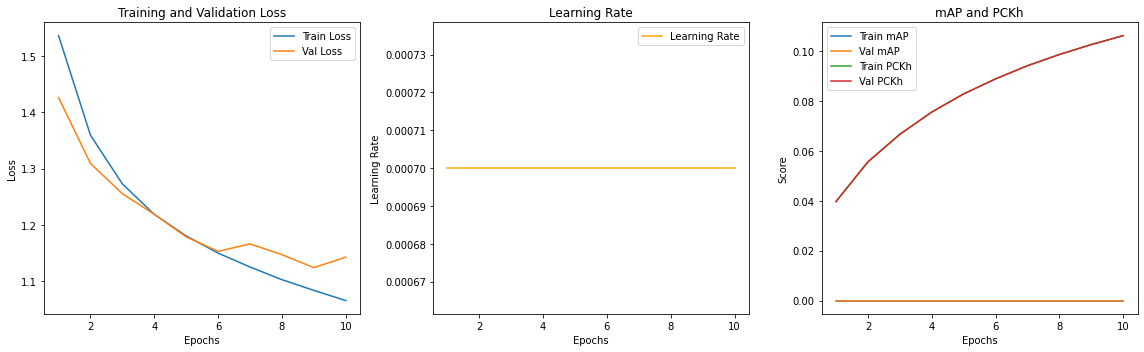

In [23]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = EPOCHS
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

In [24]:
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

In [25]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [26]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [27]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [28]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [29]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


### STEP 1 : simplebaseline 모델 완성하기
---
simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

In [30]:
def _make_deconv_layer(num_deconv_layers):
    """
    Deconvolution Layer를 생성합니다.
    Args:
        num_deconv_layers: Deconvolution 레이어의 개수
    Returns:
        Sequential model containing the deconv layers
    """
    seq_model = tf.keras.models.Sequential()

    # [[YOUR CODE]]
    for i in range(num_deconv_layers):
        # 디컨볼루션 레이어 추가
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        
        # Batch Normalization
        seq_model.add(tf.keras.layers.BatchNormalization())
        
        # ReLU 활성화 함수
        seq_model.add(tf.keras.layers.ReLU())
    
    return seq_model

In [31]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

epochs = EPOCHS
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [32]:
upconv = _make_deconv_layer(3)

# [[YOUR CODE]]
final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')

### 아래 에러 발생함
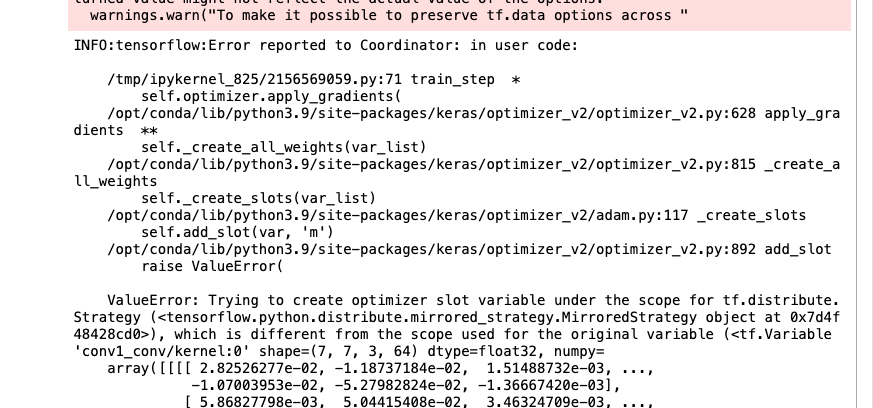

In [33]:
def Simplebaseline(input_shape=(256, 256, 3)):
    # resnet을 불러올 때 함수 내부에서 불러오면 정상적으로 학습
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNet50을 통과
    x = resnet(inputs)
    
    # 디컨볼루션 레이어를 통과
    x = upconv(x)
    
    # 최종 컨볼루션 레이어를 통과하여 히트맵 생성
    out = final_layer(x)
    
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [34]:
# spb_model = Simplebaseline(IMAGE_SHAPE)
# spb_model.summary()

### STEP 2 : simplebaseline 모델로 변경하여 훈련하기
---
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

### 아래와 같은 문제가 발생하여 디버깅 
- 발생 에러
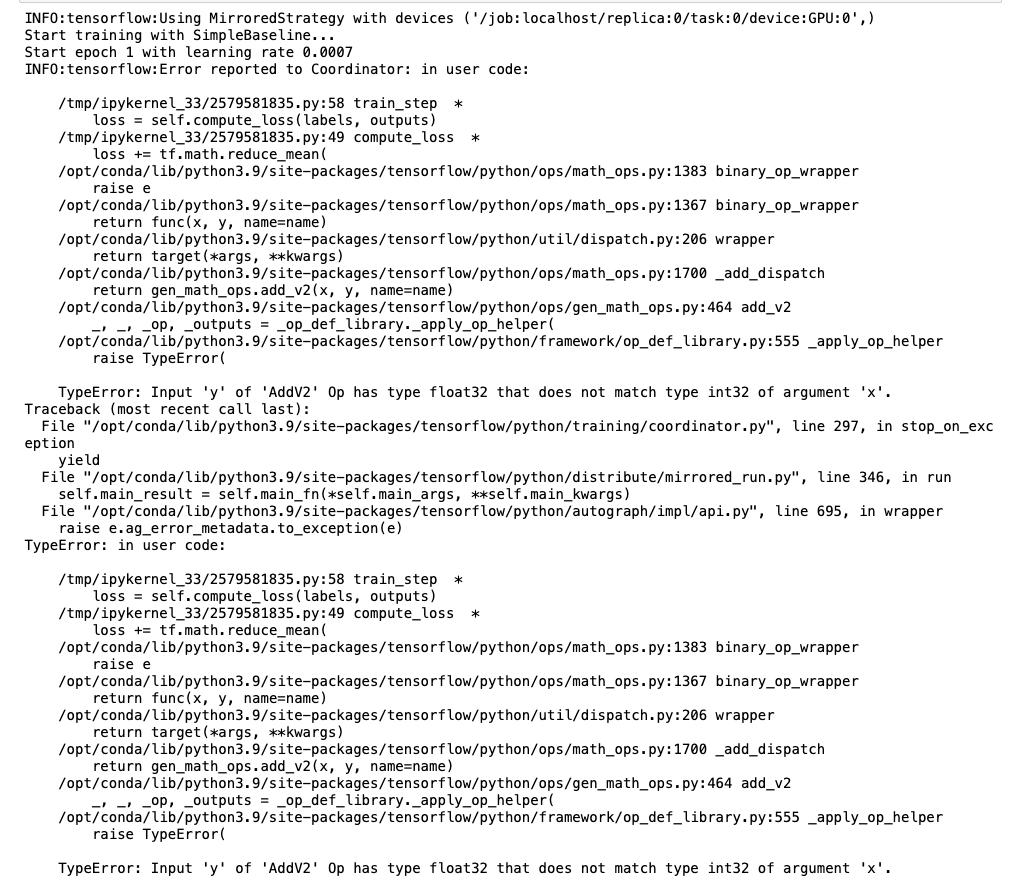

- 디버깅 과정  

1. SimpleBaseline 모델 출력 확인
    ```python
    sample_input = tf.random.normal((1, 256, 256, 3))
    sample_output = spb_model(sample_input)
    print(f"Model output dtype: {sample_output.dtype}, shape: {sample_output.shape}")
    ```
    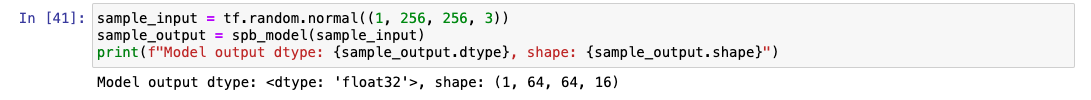
    - 데이터 타입: float32 ✅ 정상
    - 출력 형태: (1, 64, 64, 16) ✅ 정상  


2. 데이터셋 확인 결과
    ```python
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
            train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    for images, labels in train_dataset.take(1):
        print(f"Labels dtype: {labels.dtype}, shape: {labels.shape}")
        print(f"Images dtype: {images.dtype}, shape: {images.shape}")
    ```
    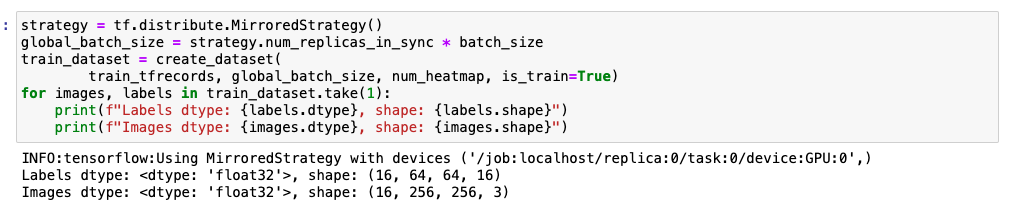
    - labels dtype: float32 → ✅ 정상
    - labels shape: (16, 64, 64, 16) → ✅ outputs와 동일
    - images dtype: float32 → ✅ 정상
    - images shape: (16, 256, 256, 3) → ✅ 정상  


3. compute_loss 의 SimpleBaseline에 맞게 outputs가 단일 텐서일 경우도 처리하도록 코드를 보완
    - Hourglass 모델 출력: 여러 단계에서 히트맵이 출력됨 → outputs는 리스트 형태로 여러 히트맵을 포함
    - SimpleBaseline 모델 출력: 마지막 히트맵만 출력됨 → outputs는 단일 텐서

In [35]:
def spb_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # 데이터셋 준비
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_CUSTOM_PATH):
        os.makedirs(MODEL_CUSTOM_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # 변경된 부분: StackedHourglass 대신 SimpleBaseline 사용
        spb_model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            spb_model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate
        )

        print('Start training with SimpleBaseline...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training with SimpleBaseline...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 0.695311844 epoch total loss 0.695311844
Trained batch 2 batch loss 0.656055927 epoch total loss 0.675683856
Trained batch 3 batch loss 0.544122577 epoch total loss 0.631830096
Trained batch 4 batch loss 0.505752504 epoch total loss 0.600310683
Trained batch 5 batch loss 0.469492197 epoch total loss 0.574147
Trained batch 6 batch loss 0.440662503 epoch total loss 0.551899612
Trained batch 7 batch loss 0.447679192 epoch total loss 0.537010968
Trained batch 8 batch loss 0.446563512 epoch total loss 0.52570504
Trained batch 9 batch loss 0.423227191 epoch total loss 0.514318645
Trained batch 10 batch loss 0.428932846 epoch total loss 0.505780041
Trained batch 11 batch loss 0.450723678 epoch total loss 0.50077492
Trained batch 12 batch loss 0.448837906 epoc

Trained batch 118 batch loss 0.39815712 epoch total loss 0.393975586
Trained batch 119 batch loss 0.411369652 epoch total loss 0.394121766
Trained batch 120 batch loss 0.377823472 epoch total loss 0.393985927
Trained batch 121 batch loss 0.372475445 epoch total loss 0.393808156
Trained batch 122 batch loss 0.377720445 epoch total loss 0.393676281
Trained batch 123 batch loss 0.370877355 epoch total loss 0.393490911
Trained batch 124 batch loss 0.377071768 epoch total loss 0.393358499
Trained batch 125 batch loss 0.381780028 epoch total loss 0.393265873
Trained batch 126 batch loss 0.385202289 epoch total loss 0.393201858
Trained batch 127 batch loss 0.374952465 epoch total loss 0.393058181
Trained batch 128 batch loss 0.353756666 epoch total loss 0.392751127
Trained batch 129 batch loss 0.368561745 epoch total loss 0.392563611
Trained batch 130 batch loss 0.391117305 epoch total loss 0.392552465
Trained batch 131 batch loss 0.397292733 epoch total loss 0.392588675
Trained batch 132 bat

Trained batch 236 batch loss 0.369714856 epoch total loss 0.378383547
Trained batch 237 batch loss 0.333246708 epoch total loss 0.37819308
Trained batch 238 batch loss 0.324725628 epoch total loss 0.377968401
Trained batch 239 batch loss 0.349115074 epoch total loss 0.377847672
Trained batch 240 batch loss 0.349930793 epoch total loss 0.377731353
Trained batch 241 batch loss 0.365660965 epoch total loss 0.377681285
Trained batch 242 batch loss 0.327857316 epoch total loss 0.377475381
Trained batch 243 batch loss 0.348463833 epoch total loss 0.377356
Trained batch 244 batch loss 0.353498876 epoch total loss 0.377258241
Trained batch 245 batch loss 0.321460813 epoch total loss 0.377030522
Trained batch 246 batch loss 0.316028565 epoch total loss 0.376782507
Trained batch 247 batch loss 0.299649 epoch total loss 0.376470238
Trained batch 248 batch loss 0.295099944 epoch total loss 0.376142144
Trained batch 249 batch loss 0.326511621 epoch total loss 0.375942826
Trained batch 250 batch los

Trained batch 354 batch loss 0.34608689 epoch total loss 0.366154611
Trained batch 355 batch loss 0.342988193 epoch total loss 0.366089344
Trained batch 356 batch loss 0.325091392 epoch total loss 0.365974158
Trained batch 357 batch loss 0.326341718 epoch total loss 0.365863144
Trained batch 358 batch loss 0.31968376 epoch total loss 0.36573416
Trained batch 359 batch loss 0.337589711 epoch total loss 0.36565575
Trained batch 360 batch loss 0.326857954 epoch total loss 0.365547985
Trained batch 361 batch loss 0.324148536 epoch total loss 0.365433276
Trained batch 362 batch loss 0.345200777 epoch total loss 0.365377396
Trained batch 363 batch loss 0.333244532 epoch total loss 0.365288883
Trained batch 364 batch loss 0.363955438 epoch total loss 0.365285218
Trained batch 365 batch loss 0.359840363 epoch total loss 0.365270287
Trained batch 366 batch loss 0.380411386 epoch total loss 0.365311682
Trained batch 367 batch loss 0.361401945 epoch total loss 0.365301
Trained batch 368 batch los

Trained batch 472 batch loss 0.363603026 epoch total loss 0.360762239
Trained batch 473 batch loss 0.322939754 epoch total loss 0.360682249
Trained batch 474 batch loss 0.309777051 epoch total loss 0.360574871
Trained batch 475 batch loss 0.276859164 epoch total loss 0.36039862
Trained batch 476 batch loss 0.280729443 epoch total loss 0.360231251
Trained batch 477 batch loss 0.276458293 epoch total loss 0.360055625
Trained batch 478 batch loss 0.322455764 epoch total loss 0.359976947
Trained batch 479 batch loss 0.295378715 epoch total loss 0.359842092
Trained batch 480 batch loss 0.334766835 epoch total loss 0.359789848
Trained batch 481 batch loss 0.340457201 epoch total loss 0.359749645
Trained batch 482 batch loss 0.331281126 epoch total loss 0.359690577
Trained batch 483 batch loss 0.359296948 epoch total loss 0.359689772
Trained batch 484 batch loss 0.367748857 epoch total loss 0.359706432
Trained batch 485 batch loss 0.359770775 epoch total loss 0.359706581
Trained batch 486 bat

Trained batch 590 batch loss 0.348443687 epoch total loss 0.356481403
Trained batch 591 batch loss 0.347629935 epoch total loss 0.356466442
Trained batch 592 batch loss 0.346538842 epoch total loss 0.356449664
Trained batch 593 batch loss 0.312134981 epoch total loss 0.356374949
Trained batch 594 batch loss 0.340690076 epoch total loss 0.356348515
Trained batch 595 batch loss 0.363234222 epoch total loss 0.356360108
Trained batch 596 batch loss 0.339430362 epoch total loss 0.356331676
Trained batch 597 batch loss 0.331439644 epoch total loss 0.356289983
Trained batch 598 batch loss 0.294227242 epoch total loss 0.356186181
Trained batch 599 batch loss 0.333630919 epoch total loss 0.356148541
Trained batch 600 batch loss 0.323587328 epoch total loss 0.356094271
Trained batch 601 batch loss 0.364691496 epoch total loss 0.356108576
Trained batch 602 batch loss 0.367284685 epoch total loss 0.356127143
Trained batch 603 batch loss 0.317978233 epoch total loss 0.356063873
Trained batch 604 ba

Trained batch 708 batch loss 0.320341408 epoch total loss 0.351531357
Trained batch 709 batch loss 0.308810681 epoch total loss 0.351471096
Trained batch 710 batch loss 0.327335715 epoch total loss 0.351437092
Trained batch 711 batch loss 0.319560558 epoch total loss 0.351392269
Trained batch 712 batch loss 0.34317103 epoch total loss 0.351380736
Trained batch 713 batch loss 0.31799233 epoch total loss 0.351333886
Trained batch 714 batch loss 0.321556509 epoch total loss 0.351292193
Trained batch 715 batch loss 0.298189849 epoch total loss 0.351217926
Trained batch 716 batch loss 0.323713064 epoch total loss 0.35117951
Trained batch 717 batch loss 0.348500371 epoch total loss 0.351175785
Trained batch 718 batch loss 0.343845427 epoch total loss 0.351165563
Trained batch 719 batch loss 0.298154503 epoch total loss 0.351091832
Trained batch 720 batch loss 0.294090867 epoch total loss 0.351012677
Trained batch 721 batch loss 0.321852475 epoch total loss 0.350972235
Trained batch 722 batch

Trained batch 826 batch loss 0.324297309 epoch total loss 0.349114925
Trained batch 827 batch loss 0.319894791 epoch total loss 0.349079579
Trained batch 828 batch loss 0.339158893 epoch total loss 0.349067628
Trained batch 829 batch loss 0.356203765 epoch total loss 0.349076211
Trained batch 830 batch loss 0.346869707 epoch total loss 0.349073559
Trained batch 831 batch loss 0.349650264 epoch total loss 0.349074244
Trained batch 832 batch loss 0.339918554 epoch total loss 0.349063218
Trained batch 833 batch loss 0.335554749 epoch total loss 0.349046975
Trained batch 834 batch loss 0.347525567 epoch total loss 0.349045157
Trained batch 835 batch loss 0.346728712 epoch total loss 0.349042416
Trained batch 836 batch loss 0.315596074 epoch total loss 0.349002391
Trained batch 837 batch loss 0.32029891 epoch total loss 0.348968118
Trained batch 838 batch loss 0.334722966 epoch total loss 0.348951101
Trained batch 839 batch loss 0.316807717 epoch total loss 0.348912776
Trained batch 840 bat

Trained batch 944 batch loss 0.323813081 epoch total loss 0.346339494
Trained batch 945 batch loss 0.319737911 epoch total loss 0.346311331
Trained batch 946 batch loss 0.311635494 epoch total loss 0.346274704
Trained batch 947 batch loss 0.313096017 epoch total loss 0.346239686
Trained batch 948 batch loss 0.302539557 epoch total loss 0.346193582
Trained batch 949 batch loss 0.277748525 epoch total loss 0.34612146
Trained batch 950 batch loss 0.299262702 epoch total loss 0.346072137
Trained batch 951 batch loss 0.324758172 epoch total loss 0.346049726
Trained batch 952 batch loss 0.350634366 epoch total loss 0.346054554
Trained batch 953 batch loss 0.37330395 epoch total loss 0.346083134
Trained batch 954 batch loss 0.345374107 epoch total loss 0.346082389
Trained batch 955 batch loss 0.335479975 epoch total loss 0.346071273
Trained batch 956 batch loss 0.33625865 epoch total loss 0.346061051
Trained batch 957 batch loss 0.30423215 epoch total loss 0.346017331
Trained batch 958 batch 

Trained batch 1061 batch loss 0.306296527 epoch total loss 0.34412691
Trained batch 1062 batch loss 0.314223468 epoch total loss 0.344098747
Trained batch 1063 batch loss 0.316682816 epoch total loss 0.344072938
Trained batch 1064 batch loss 0.307908773 epoch total loss 0.344038963
Trained batch 1065 batch loss 0.340361357 epoch total loss 0.344035506
Trained batch 1066 batch loss 0.340693682 epoch total loss 0.344032377
Trained batch 1067 batch loss 0.322613806 epoch total loss 0.34401229
Trained batch 1068 batch loss 0.323823452 epoch total loss 0.343993396
Trained batch 1069 batch loss 0.335110754 epoch total loss 0.343985081
Trained batch 1070 batch loss 0.328974307 epoch total loss 0.343971074
Trained batch 1071 batch loss 0.311573803 epoch total loss 0.343940824
Trained batch 1072 batch loss 0.320894152 epoch total loss 0.343919337
Trained batch 1073 batch loss 0.311939478 epoch total loss 0.343889534
Trained batch 1074 batch loss 0.320558429 epoch total loss 0.343867809
Trained 

Trained batch 1177 batch loss 0.304678053 epoch total loss 0.341932505
Trained batch 1178 batch loss 0.294294834 epoch total loss 0.341892064
Trained batch 1179 batch loss 0.330667675 epoch total loss 0.341882527
Trained batch 1180 batch loss 0.304487 epoch total loss 0.341850817
Trained batch 1181 batch loss 0.310666174 epoch total loss 0.341824412
Trained batch 1182 batch loss 0.335478276 epoch total loss 0.341819048
Trained batch 1183 batch loss 0.325269163 epoch total loss 0.341805041
Trained batch 1184 batch loss 0.333673447 epoch total loss 0.341798186
Trained batch 1185 batch loss 0.311483651 epoch total loss 0.341772616
Trained batch 1186 batch loss 0.290174335 epoch total loss 0.341729105
Trained batch 1187 batch loss 0.317753851 epoch total loss 0.341708899
Trained batch 1188 batch loss 0.340478241 epoch total loss 0.341707855
Trained batch 1189 batch loss 0.343170196 epoch total loss 0.341709107
Trained batch 1190 batch loss 0.34381941 epoch total loss 0.341710865
Trained ba

Trained batch 1293 batch loss 0.283872157 epoch total loss 0.339613467
Trained batch 1294 batch loss 0.313308895 epoch total loss 0.339593142
Trained batch 1295 batch loss 0.317027 epoch total loss 0.339575708
Trained batch 1296 batch loss 0.347336799 epoch total loss 0.339581728
Trained batch 1297 batch loss 0.336464047 epoch total loss 0.339579314
Trained batch 1298 batch loss 0.316433847 epoch total loss 0.339561462
Trained batch 1299 batch loss 0.314702958 epoch total loss 0.339542329
Trained batch 1300 batch loss 0.284857303 epoch total loss 0.339500248
Trained batch 1301 batch loss 0.28800711 epoch total loss 0.339460671
Trained batch 1302 batch loss 0.309592277 epoch total loss 0.339437753
Trained batch 1303 batch loss 0.318813354 epoch total loss 0.339421928
Trained batch 1304 batch loss 0.339423507 epoch total loss 0.339421898
Trained batch 1305 batch loss 0.318513334 epoch total loss 0.339405894
Trained batch 1306 batch loss 0.312850267 epoch total loss 0.339385539
Trained ba

Validated batch 35 batch loss 0.339197844
Validated batch 36 batch loss 0.34352085
Validated batch 37 batch loss 0.345010489
Validated batch 38 batch loss 0.33717519
Validated batch 39 batch loss 0.347550631
Validated batch 40 batch loss 0.347327083
Validated batch 41 batch loss 0.301707774
Validated batch 42 batch loss 0.334653586
Validated batch 43 batch loss 0.342263609
Validated batch 44 batch loss 0.328844547
Validated batch 45 batch loss 0.333590865
Validated batch 46 batch loss 0.318055153
Validated batch 47 batch loss 0.348443031
Validated batch 48 batch loss 0.316269666
Validated batch 49 batch loss 0.316546649
Validated batch 50 batch loss 0.316687047
Validated batch 51 batch loss 0.303548753
Validated batch 52 batch loss 0.320492536
Validated batch 53 batch loss 0.340670288
Validated batch 54 batch loss 0.300548285
Validated batch 55 batch loss 0.329945385
Validated batch 56 batch loss 0.316380262
Validated batch 57 batch loss 0.346476018
Validated batch 58 batch loss 0.3337

Trained batch 23 batch loss 0.315444738 epoch total loss 0.302329332
Trained batch 24 batch loss 0.343844682 epoch total loss 0.304059148
Trained batch 25 batch loss 0.37652126 epoch total loss 0.306957632
Trained batch 26 batch loss 0.328924775 epoch total loss 0.307802528
Trained batch 27 batch loss 0.33361578 epoch total loss 0.308758557
Trained batch 28 batch loss 0.300267756 epoch total loss 0.308455318
Trained batch 29 batch loss 0.324355721 epoch total loss 0.309003621
Trained batch 30 batch loss 0.312663227 epoch total loss 0.309125602
Trained batch 31 batch loss 0.296971738 epoch total loss 0.308733553
Trained batch 32 batch loss 0.318837911 epoch total loss 0.309049308
Trained batch 33 batch loss 0.302291572 epoch total loss 0.308844537
Trained batch 34 batch loss 0.282417595 epoch total loss 0.308067262
Trained batch 35 batch loss 0.292059541 epoch total loss 0.307609916
Trained batch 36 batch loss 0.25908643 epoch total loss 0.306262046
Trained batch 37 batch loss 0.332588 

Trained batch 142 batch loss 0.306356 epoch total loss 0.312709
Trained batch 143 batch loss 0.279836059 epoch total loss 0.312479109
Trained batch 144 batch loss 0.331668496 epoch total loss 0.312612385
Trained batch 145 batch loss 0.335363328 epoch total loss 0.312769264
Trained batch 146 batch loss 0.326326549 epoch total loss 0.312862128
Trained batch 147 batch loss 0.336252868 epoch total loss 0.313021272
Trained batch 148 batch loss 0.355470181 epoch total loss 0.31330806
Trained batch 149 batch loss 0.32981351 epoch total loss 0.313418865
Trained batch 150 batch loss 0.328766167 epoch total loss 0.313521177
Trained batch 151 batch loss 0.303277045 epoch total loss 0.313453317
Trained batch 152 batch loss 0.306418955 epoch total loss 0.313407034
Trained batch 153 batch loss 0.30954203 epoch total loss 0.313381791
Trained batch 154 batch loss 0.303294301 epoch total loss 0.313316286
Trained batch 155 batch loss 0.280977249 epoch total loss 0.31310764
Trained batch 156 batch loss 0

Trained batch 260 batch loss 0.300998688 epoch total loss 0.312680572
Trained batch 261 batch loss 0.309526563 epoch total loss 0.312668502
Trained batch 262 batch loss 0.313198626 epoch total loss 0.312670529
Trained batch 263 batch loss 0.319401741 epoch total loss 0.312696129
Trained batch 264 batch loss 0.305165261 epoch total loss 0.312667608
Trained batch 265 batch loss 0.341781437 epoch total loss 0.312777489
Trained batch 266 batch loss 0.321928442 epoch total loss 0.312811881
Trained batch 267 batch loss 0.308552593 epoch total loss 0.312795937
Trained batch 268 batch loss 0.306588322 epoch total loss 0.312772781
Trained batch 269 batch loss 0.294853866 epoch total loss 0.312706172
Trained batch 270 batch loss 0.287203342 epoch total loss 0.312611699
Trained batch 271 batch loss 0.293006033 epoch total loss 0.312539369
Trained batch 272 batch loss 0.312939614 epoch total loss 0.312540829
Trained batch 273 batch loss 0.323651224 epoch total loss 0.312581539
Trained batch 274 ba

Trained batch 378 batch loss 0.331789613 epoch total loss 0.313107491
Trained batch 379 batch loss 0.345343769 epoch total loss 0.313192546
Trained batch 380 batch loss 0.351287872 epoch total loss 0.313292801
Trained batch 381 batch loss 0.310035676 epoch total loss 0.313284248
Trained batch 382 batch loss 0.314475089 epoch total loss 0.313287377
Trained batch 383 batch loss 0.333746314 epoch total loss 0.313340783
Trained batch 384 batch loss 0.299785912 epoch total loss 0.313305497
Trained batch 385 batch loss 0.351551026 epoch total loss 0.313404828
Trained batch 386 batch loss 0.355078578 epoch total loss 0.313512802
Trained batch 387 batch loss 0.359784335 epoch total loss 0.313632369
Trained batch 388 batch loss 0.340870053 epoch total loss 0.313702583
Trained batch 389 batch loss 0.288424313 epoch total loss 0.313637584
Trained batch 390 batch loss 0.27932477 epoch total loss 0.313549608
Trained batch 391 batch loss 0.269122273 epoch total loss 0.313435972
Trained batch 392 bat

Trained batch 496 batch loss 0.326894522 epoch total loss 0.311890602
Trained batch 497 batch loss 0.345856398 epoch total loss 0.311958939
Trained batch 498 batch loss 0.295228213 epoch total loss 0.311925352
Trained batch 499 batch loss 0.318637848 epoch total loss 0.311938792
Trained batch 500 batch loss 0.328611434 epoch total loss 0.311972141
Trained batch 501 batch loss 0.333340466 epoch total loss 0.312014788
Trained batch 502 batch loss 0.287153065 epoch total loss 0.311965287
Trained batch 503 batch loss 0.281998 epoch total loss 0.311905682
Trained batch 504 batch loss 0.294862151 epoch total loss 0.311871886
Trained batch 505 batch loss 0.270886689 epoch total loss 0.311790735
Trained batch 506 batch loss 0.301802278 epoch total loss 0.311770976
Trained batch 507 batch loss 0.295033455 epoch total loss 0.311737955
Trained batch 508 batch loss 0.32127 epoch total loss 0.31175673
Trained batch 509 batch loss 0.316123396 epoch total loss 0.311765313
Trained batch 510 batch loss

Trained batch 614 batch loss 0.293936908 epoch total loss 0.311651677
Trained batch 615 batch loss 0.297611892 epoch total loss 0.311628848
Trained batch 616 batch loss 0.301312596 epoch total loss 0.311612099
Trained batch 617 batch loss 0.282246023 epoch total loss 0.311564505
Trained batch 618 batch loss 0.274410397 epoch total loss 0.311504364
Trained batch 619 batch loss 0.330047429 epoch total loss 0.311534345
Trained batch 620 batch loss 0.297157705 epoch total loss 0.311511159
Trained batch 621 batch loss 0.285646349 epoch total loss 0.311469495
Trained batch 622 batch loss 0.299781024 epoch total loss 0.31145069
Trained batch 623 batch loss 0.29474017 epoch total loss 0.311423868
Trained batch 624 batch loss 0.296840489 epoch total loss 0.311400503
Trained batch 625 batch loss 0.289904296 epoch total loss 0.311366111
Trained batch 626 batch loss 0.305036783 epoch total loss 0.311356
Trained batch 627 batch loss 0.307825565 epoch total loss 0.311350375
Trained batch 628 batch l

Trained batch 732 batch loss 0.333555371 epoch total loss 0.310195863
Trained batch 733 batch loss 0.291514784 epoch total loss 0.310170382
Trained batch 734 batch loss 0.312254876 epoch total loss 0.310173213
Trained batch 735 batch loss 0.305939585 epoch total loss 0.310167462
Trained batch 736 batch loss 0.278661519 epoch total loss 0.310124636
Trained batch 737 batch loss 0.283639073 epoch total loss 0.310088724
Trained batch 738 batch loss 0.297206461 epoch total loss 0.31007126
Trained batch 739 batch loss 0.302233666 epoch total loss 0.31006065
Trained batch 740 batch loss 0.34025991 epoch total loss 0.310101449
Trained batch 741 batch loss 0.31272316 epoch total loss 0.310105
Trained batch 742 batch loss 0.30400613 epoch total loss 0.310096771
Trained batch 743 batch loss 0.290700138 epoch total loss 0.310070664
Trained batch 744 batch loss 0.288659632 epoch total loss 0.310041904
Trained batch 745 batch loss 0.282314539 epoch total loss 0.310004681
Trained batch 746 batch loss

Trained batch 850 batch loss 0.329035431 epoch total loss 0.309141248
Trained batch 851 batch loss 0.317094028 epoch total loss 0.309150606
Trained batch 852 batch loss 0.312914789 epoch total loss 0.309155017
Trained batch 853 batch loss 0.330025733 epoch total loss 0.309179485
Trained batch 854 batch loss 0.306887805 epoch total loss 0.309176803
Trained batch 855 batch loss 0.302945018 epoch total loss 0.309169501
Trained batch 856 batch loss 0.295415819 epoch total loss 0.309153438
Trained batch 857 batch loss 0.31160444 epoch total loss 0.309156299
Trained batch 858 batch loss 0.281781286 epoch total loss 0.30912438
Trained batch 859 batch loss 0.314045846 epoch total loss 0.309130132
Trained batch 860 batch loss 0.291336119 epoch total loss 0.309109449
Trained batch 861 batch loss 0.272386223 epoch total loss 0.309066832
Trained batch 862 batch loss 0.269772321 epoch total loss 0.309021235
Trained batch 863 batch loss 0.29345116 epoch total loss 0.309003204
Trained batch 864 batch

Trained batch 968 batch loss 0.301846683 epoch total loss 0.308730334
Trained batch 969 batch loss 0.312372863 epoch total loss 0.308734089
Trained batch 970 batch loss 0.290067077 epoch total loss 0.308714837
Trained batch 971 batch loss 0.302351385 epoch total loss 0.30870828
Trained batch 972 batch loss 0.327175975 epoch total loss 0.308727294
Trained batch 973 batch loss 0.271313131 epoch total loss 0.308688819
Trained batch 974 batch loss 0.310262263 epoch total loss 0.308690429
Trained batch 975 batch loss 0.27830863 epoch total loss 0.308659285
Trained batch 976 batch loss 0.289299935 epoch total loss 0.308639467
Trained batch 977 batch loss 0.31977886 epoch total loss 0.308650881
Trained batch 978 batch loss 0.315018833 epoch total loss 0.308657408
Trained batch 979 batch loss 0.335529387 epoch total loss 0.308684856
Trained batch 980 batch loss 0.298380017 epoch total loss 0.308674335
Trained batch 981 batch loss 0.289432466 epoch total loss 0.308654726
Trained batch 982 batch

Trained batch 1085 batch loss 0.316623092 epoch total loss 0.30796206
Trained batch 1086 batch loss 0.306873113 epoch total loss 0.307961047
Trained batch 1087 batch loss 0.296413362 epoch total loss 0.307950437
Trained batch 1088 batch loss 0.328579038 epoch total loss 0.307969391
Trained batch 1089 batch loss 0.30413422 epoch total loss 0.307965875
Trained batch 1090 batch loss 0.262948692 epoch total loss 0.307924569
Trained batch 1091 batch loss 0.282034844 epoch total loss 0.307900846
Trained batch 1092 batch loss 0.299813479 epoch total loss 0.307893425
Trained batch 1093 batch loss 0.305132061 epoch total loss 0.307890922
Trained batch 1094 batch loss 0.339823037 epoch total loss 0.307920098
Trained batch 1095 batch loss 0.33247596 epoch total loss 0.307942539
Trained batch 1096 batch loss 0.34980467 epoch total loss 0.307980716
Trained batch 1097 batch loss 0.314722776 epoch total loss 0.307986885
Trained batch 1098 batch loss 0.327721745 epoch total loss 0.308004856
Trained ba

Trained batch 1201 batch loss 0.303649902 epoch total loss 0.307200193
Trained batch 1202 batch loss 0.320274949 epoch total loss 0.307211101
Trained batch 1203 batch loss 0.331932485 epoch total loss 0.307231635
Trained batch 1204 batch loss 0.331552893 epoch total loss 0.307251841
Trained batch 1205 batch loss 0.298563838 epoch total loss 0.307244629
Trained batch 1206 batch loss 0.286905617 epoch total loss 0.307227761
Trained batch 1207 batch loss 0.269245565 epoch total loss 0.307196289
Trained batch 1208 batch loss 0.243269533 epoch total loss 0.30714336
Trained batch 1209 batch loss 0.308573902 epoch total loss 0.307144523
Trained batch 1210 batch loss 0.286459059 epoch total loss 0.307127446
Trained batch 1211 batch loss 0.315002471 epoch total loss 0.307133943
Trained batch 1212 batch loss 0.306721121 epoch total loss 0.307133615
Trained batch 1213 batch loss 0.321717352 epoch total loss 0.307145625
Trained batch 1214 batch loss 0.308446974 epoch total loss 0.307146698
Trained

Trained batch 1317 batch loss 0.30320704 epoch total loss 0.306809127
Trained batch 1318 batch loss 0.316845298 epoch total loss 0.306816727
Trained batch 1319 batch loss 0.299917459 epoch total loss 0.306811512
Trained batch 1320 batch loss 0.277382761 epoch total loss 0.306789219
Trained batch 1321 batch loss 0.294882834 epoch total loss 0.306780219
Trained batch 1322 batch loss 0.287641436 epoch total loss 0.306765705
Trained batch 1323 batch loss 0.309539676 epoch total loss 0.306767821
Trained batch 1324 batch loss 0.266200364 epoch total loss 0.306737185
Trained batch 1325 batch loss 0.325867236 epoch total loss 0.306751609
Trained batch 1326 batch loss 0.303610653 epoch total loss 0.306749254
Trained batch 1327 batch loss 0.31010586 epoch total loss 0.306751788
Trained batch 1328 batch loss 0.329999536 epoch total loss 0.306769282
Trained batch 1329 batch loss 0.27574268 epoch total loss 0.306745946
Trained batch 1330 batch loss 0.29951486 epoch total loss 0.306740522
Trained ba

Validated batch 75 batch loss 0.326447427
Validated batch 76 batch loss 0.314999253
Validated batch 77 batch loss 0.299473584
Validated batch 78 batch loss 0.304373235
Validated batch 79 batch loss 0.299045861
Validated batch 80 batch loss 0.309643954
Validated batch 81 batch loss 0.31597051
Validated batch 82 batch loss 0.292749703
Validated batch 83 batch loss 0.295648485
Validated batch 84 batch loss 0.319035858
Validated batch 85 batch loss 0.306513429
Validated batch 86 batch loss 0.354755402
Validated batch 87 batch loss 0.309126794
Validated batch 88 batch loss 0.283392847
Validated batch 89 batch loss 0.32397747
Validated batch 90 batch loss 0.317716
Validated batch 91 batch loss 0.294182
Validated batch 92 batch loss 0.314958751
Validated batch 93 batch loss 0.306041628
Validated batch 94 batch loss 0.311977983
Validated batch 95 batch loss 0.297108352
Validated batch 96 batch loss 0.292166799
Validated batch 97 batch loss 0.314380974
Validated batch 98 batch loss 0.331953138


Trained batch 48 batch loss 0.275036246 epoch total loss 0.296299368
Trained batch 49 batch loss 0.30116719 epoch total loss 0.296398729
Trained batch 50 batch loss 0.27841574 epoch total loss 0.296039075
Trained batch 51 batch loss 0.266388923 epoch total loss 0.295457691
Trained batch 52 batch loss 0.286751896 epoch total loss 0.295290262
Trained batch 53 batch loss 0.277224571 epoch total loss 0.294949412
Trained batch 54 batch loss 0.245403618 epoch total loss 0.294031888
Trained batch 55 batch loss 0.257535905 epoch total loss 0.29336831
Trained batch 56 batch loss 0.285650432 epoch total loss 0.293230504
Trained batch 57 batch loss 0.286804199 epoch total loss 0.293117762
Trained batch 58 batch loss 0.298042119 epoch total loss 0.293202668
Trained batch 59 batch loss 0.292921126 epoch total loss 0.2931979
Trained batch 60 batch loss 0.278016508 epoch total loss 0.292944878
Trained batch 61 batch loss 0.328719318 epoch total loss 0.293531358
Trained batch 62 batch loss 0.292617053

Trained batch 167 batch loss 0.329025507 epoch total loss 0.297932595
Trained batch 168 batch loss 0.356426716 epoch total loss 0.298280776
Trained batch 169 batch loss 0.359474808 epoch total loss 0.298642844
Trained batch 170 batch loss 0.33163327 epoch total loss 0.298836917
Trained batch 171 batch loss 0.312343538 epoch total loss 0.298915893
Trained batch 172 batch loss 0.334742188 epoch total loss 0.299124211
Trained batch 173 batch loss 0.315068096 epoch total loss 0.29921636
Trained batch 174 batch loss 0.300611377 epoch total loss 0.299224377
Trained batch 175 batch loss 0.274676085 epoch total loss 0.299084097
Trained batch 176 batch loss 0.275878578 epoch total loss 0.298952252
Trained batch 177 batch loss 0.282596916 epoch total loss 0.298859835
Trained batch 178 batch loss 0.296460152 epoch total loss 0.298846364
Trained batch 179 batch loss 0.297239602 epoch total loss 0.298837394
Trained batch 180 batch loss 0.309857368 epoch total loss 0.298898607
Trained batch 181 batc

Trained batch 285 batch loss 0.285595566 epoch total loss 0.296988457
Trained batch 286 batch loss 0.305890977 epoch total loss 0.297019571
Trained batch 287 batch loss 0.343146712 epoch total loss 0.297180295
Trained batch 288 batch loss 0.327645838 epoch total loss 0.297286093
Trained batch 289 batch loss 0.31299004 epoch total loss 0.297340423
Trained batch 290 batch loss 0.286028057 epoch total loss 0.297301412
Trained batch 291 batch loss 0.284327626 epoch total loss 0.297256798
Trained batch 292 batch loss 0.280499756 epoch total loss 0.297199428
Trained batch 293 batch loss 0.314806342 epoch total loss 0.29725951
Trained batch 294 batch loss 0.313814402 epoch total loss 0.297315806
Trained batch 295 batch loss 0.336123109 epoch total loss 0.297447354
Trained batch 296 batch loss 0.317958444 epoch total loss 0.297516644
Trained batch 297 batch loss 0.293941766 epoch total loss 0.297504604
Trained batch 298 batch loss 0.317462236 epoch total loss 0.29757157
Trained batch 299 batch

Trained batch 403 batch loss 0.311560035 epoch total loss 0.296874464
Trained batch 404 batch loss 0.306506425 epoch total loss 0.296898276
Trained batch 405 batch loss 0.293558121 epoch total loss 0.29689002
Trained batch 406 batch loss 0.324166626 epoch total loss 0.296957225
Trained batch 407 batch loss 0.33641538 epoch total loss 0.297054172
Trained batch 408 batch loss 0.284172475 epoch total loss 0.297022581
Trained batch 409 batch loss 0.313873172 epoch total loss 0.297063798
Trained batch 410 batch loss 0.300506 epoch total loss 0.297072202
Trained batch 411 batch loss 0.279465973 epoch total loss 0.297029346
Trained batch 412 batch loss 0.258230805 epoch total loss 0.296935171
Trained batch 413 batch loss 0.224263817 epoch total loss 0.296759218
Trained batch 414 batch loss 0.296883911 epoch total loss 0.296759516
Trained batch 415 batch loss 0.313959181 epoch total loss 0.296800971
Trained batch 416 batch loss 0.326749 epoch total loss 0.296872973
Trained batch 417 batch loss

Trained batch 521 batch loss 0.293669403 epoch total loss 0.297406703
Trained batch 522 batch loss 0.271236032 epoch total loss 0.297356576
Trained batch 523 batch loss 0.288138896 epoch total loss 0.297338963
Trained batch 524 batch loss 0.305913359 epoch total loss 0.297355294
Trained batch 525 batch loss 0.319627136 epoch total loss 0.297397733
Trained batch 526 batch loss 0.280411124 epoch total loss 0.297365427
Trained batch 527 batch loss 0.273854673 epoch total loss 0.297320813
Trained batch 528 batch loss 0.285550296 epoch total loss 0.297298521
Trained batch 529 batch loss 0.270113587 epoch total loss 0.297247112
Trained batch 530 batch loss 0.311346442 epoch total loss 0.297273725
Trained batch 531 batch loss 0.29206568 epoch total loss 0.29726392
Trained batch 532 batch loss 0.306569576 epoch total loss 0.297281384
Trained batch 533 batch loss 0.283246875 epoch total loss 0.297255069
Trained batch 534 batch loss 0.289876252 epoch total loss 0.297241241
Trained batch 535 batc

Trained batch 639 batch loss 0.328980565 epoch total loss 0.2961182
Trained batch 640 batch loss 0.314203888 epoch total loss 0.296146452
Trained batch 641 batch loss 0.287470073 epoch total loss 0.296132952
Trained batch 642 batch loss 0.304608881 epoch total loss 0.296146154
Trained batch 643 batch loss 0.307378024 epoch total loss 0.296163589
Trained batch 644 batch loss 0.328668952 epoch total loss 0.296214074
Trained batch 645 batch loss 0.277472317 epoch total loss 0.296185017
Trained batch 646 batch loss 0.277671665 epoch total loss 0.296156347
Trained batch 647 batch loss 0.27199772 epoch total loss 0.296119
Trained batch 648 batch loss 0.278615236 epoch total loss 0.296092
Trained batch 649 batch loss 0.277982146 epoch total loss 0.296064109
Trained batch 650 batch loss 0.283268601 epoch total loss 0.296044409
Trained batch 651 batch loss 0.2627289 epoch total loss 0.295993239
Trained batch 652 batch loss 0.26027739 epoch total loss 0.295938462
Trained batch 653 batch loss 0.2

Trained batch 757 batch loss 0.294474304 epoch total loss 0.295146435
Trained batch 758 batch loss 0.291933566 epoch total loss 0.295142174
Trained batch 759 batch loss 0.302492797 epoch total loss 0.29515186
Trained batch 760 batch loss 0.291608959 epoch total loss 0.29514721
Trained batch 761 batch loss 0.300821334 epoch total loss 0.295154661
Trained batch 762 batch loss 0.316968828 epoch total loss 0.295183301
Trained batch 763 batch loss 0.292993069 epoch total loss 0.29518044
Trained batch 764 batch loss 0.293906689 epoch total loss 0.295178771
Trained batch 765 batch loss 0.322181106 epoch total loss 0.295214057
Trained batch 766 batch loss 0.331896 epoch total loss 0.295261919
Trained batch 767 batch loss 0.292703 epoch total loss 0.295258611
Trained batch 768 batch loss 0.30022943 epoch total loss 0.295265079
Trained batch 769 batch loss 0.299212515 epoch total loss 0.295270205
Trained batch 770 batch loss 0.296569258 epoch total loss 0.295271903
Trained batch 771 batch loss 0

Trained batch 875 batch loss 0.314075 epoch total loss 0.294685245
Trained batch 876 batch loss 0.309012353 epoch total loss 0.294701606
Trained batch 877 batch loss 0.321833432 epoch total loss 0.294732541
Trained batch 878 batch loss 0.324229628 epoch total loss 0.294766128
Trained batch 879 batch loss 0.329678953 epoch total loss 0.294805855
Trained batch 880 batch loss 0.268487126 epoch total loss 0.294775933
Trained batch 881 batch loss 0.271829903 epoch total loss 0.294749886
Trained batch 882 batch loss 0.27668649 epoch total loss 0.294729382
Trained batch 883 batch loss 0.3010768 epoch total loss 0.294736594
Trained batch 884 batch loss 0.31297332 epoch total loss 0.294757247
Trained batch 885 batch loss 0.279528618 epoch total loss 0.294740051
Trained batch 886 batch loss 0.309423834 epoch total loss 0.294756621
Trained batch 887 batch loss 0.284719557 epoch total loss 0.294745296
Trained batch 888 batch loss 0.261562079 epoch total loss 0.294707954
Trained batch 889 batch los

Trained batch 993 batch loss 0.27380988 epoch total loss 0.294822156
Trained batch 994 batch loss 0.248543248 epoch total loss 0.294775575
Trained batch 995 batch loss 0.230553806 epoch total loss 0.294711053
Trained batch 996 batch loss 0.223035589 epoch total loss 0.294639081
Trained batch 997 batch loss 0.239791587 epoch total loss 0.294584036
Trained batch 998 batch loss 0.31795463 epoch total loss 0.29460746
Trained batch 999 batch loss 0.335286528 epoch total loss 0.2946482
Trained batch 1000 batch loss 0.299458295 epoch total loss 0.294653028
Trained batch 1001 batch loss 0.317543089 epoch total loss 0.294675887
Trained batch 1002 batch loss 0.285891235 epoch total loss 0.294667095
Trained batch 1003 batch loss 0.310197681 epoch total loss 0.294682592
Trained batch 1004 batch loss 0.30956471 epoch total loss 0.294697434
Trained batch 1005 batch loss 0.267958552 epoch total loss 0.29467082
Trained batch 1006 batch loss 0.271460354 epoch total loss 0.294647723
Trained batch 1007 b

Trained batch 1110 batch loss 0.322451115 epoch total loss 0.294007719
Trained batch 1111 batch loss 0.279720724 epoch total loss 0.293994874
Trained batch 1112 batch loss 0.313539 epoch total loss 0.294012427
Trained batch 1113 batch loss 0.336955756 epoch total loss 0.294051021
Trained batch 1114 batch loss 0.314633429 epoch total loss 0.294069499
Trained batch 1115 batch loss 0.288123578 epoch total loss 0.294064164
Trained batch 1116 batch loss 0.340468019 epoch total loss 0.294105709
Trained batch 1117 batch loss 0.31941992 epoch total loss 0.294128388
Trained batch 1118 batch loss 0.291780859 epoch total loss 0.294126302
Trained batch 1119 batch loss 0.259488672 epoch total loss 0.294095337
Trained batch 1120 batch loss 0.26894 epoch total loss 0.294072896
Trained batch 1121 batch loss 0.245833769 epoch total loss 0.294029832
Trained batch 1122 batch loss 0.269583523 epoch total loss 0.294008046
Trained batch 1123 batch loss 0.274581045 epoch total loss 0.293990761
Trained batch 

Trained batch 1227 batch loss 0.276415 epoch total loss 0.294056743
Trained batch 1228 batch loss 0.318487287 epoch total loss 0.294076622
Trained batch 1229 batch loss 0.318191975 epoch total loss 0.294096261
Trained batch 1230 batch loss 0.27610296 epoch total loss 0.294081628
Trained batch 1231 batch loss 0.333767623 epoch total loss 0.294113874
Trained batch 1232 batch loss 0.319259703 epoch total loss 0.294134289
Trained batch 1233 batch loss 0.332747102 epoch total loss 0.294165581
Trained batch 1234 batch loss 0.288814187 epoch total loss 0.29416126
Trained batch 1235 batch loss 0.264344603 epoch total loss 0.29413712
Trained batch 1236 batch loss 0.271331757 epoch total loss 0.294118673
Trained batch 1237 batch loss 0.271204 epoch total loss 0.294100136
Trained batch 1238 batch loss 0.267493635 epoch total loss 0.294078648
Trained batch 1239 batch loss 0.281166464 epoch total loss 0.294068217
Trained batch 1240 batch loss 0.292993516 epoch total loss 0.294067353
Trained batch 1

Trained batch 1344 batch loss 0.29501614 epoch total loss 0.294276804
Trained batch 1345 batch loss 0.285809278 epoch total loss 0.294270515
Trained batch 1346 batch loss 0.305742085 epoch total loss 0.294279039
Trained batch 1347 batch loss 0.311348081 epoch total loss 0.294291705
Trained batch 1348 batch loss 0.288728118 epoch total loss 0.294287562
Trained batch 1349 batch loss 0.261054695 epoch total loss 0.294262916
Trained batch 1350 batch loss 0.290381312 epoch total loss 0.294260055
Trained batch 1351 batch loss 0.30483377 epoch total loss 0.294267893
Trained batch 1352 batch loss 0.30241707 epoch total loss 0.294273913
Trained batch 1353 batch loss 0.301094681 epoch total loss 0.294278949
Trained batch 1354 batch loss 0.300837576 epoch total loss 0.294283807
Trained batch 1355 batch loss 0.315308571 epoch total loss 0.294299304
Trained batch 1356 batch loss 0.325370371 epoch total loss 0.294322222
Trained batch 1357 batch loss 0.336360306 epoch total loss 0.294353217
Trained b

Validated batch 120 batch loss 0.292579502
Validated batch 121 batch loss 0.313965738
Validated batch 122 batch loss 0.314928949
Validated batch 123 batch loss 0.316093385
Validated batch 124 batch loss 0.313972086
Validated batch 125 batch loss 0.283666164
Validated batch 126 batch loss 0.302735955
Validated batch 127 batch loss 0.296825469
Validated batch 128 batch loss 0.295150161
Validated batch 129 batch loss 0.330423445
Validated batch 130 batch loss 0.318099916
Validated batch 131 batch loss 0.309407949
Validated batch 132 batch loss 0.316416383
Validated batch 133 batch loss 0.28346926
Validated batch 134 batch loss 0.2976017
Validated batch 135 batch loss 0.284695685
Validated batch 136 batch loss 0.257495344
Validated batch 137 batch loss 0.316886574
Validated batch 138 batch loss 0.288382947
Validated batch 139 batch loss 0.294541955
Validated batch 140 batch loss 0.277917594
Validated batch 141 batch loss 0.280808628
Validated batch 142 batch loss 0.284151554
Validated batc

Trained batch 75 batch loss 0.274896234 epoch total loss 0.285648763
Trained batch 76 batch loss 0.297349602 epoch total loss 0.285802722
Trained batch 77 batch loss 0.297161251 epoch total loss 0.285950214
Trained batch 78 batch loss 0.292749673 epoch total loss 0.286037385
Trained batch 79 batch loss 0.260887414 epoch total loss 0.285719037
Trained batch 80 batch loss 0.298698306 epoch total loss 0.285881281
Trained batch 81 batch loss 0.264407784 epoch total loss 0.285616189
Trained batch 82 batch loss 0.317333907 epoch total loss 0.286002964
Trained batch 83 batch loss 0.266635984 epoch total loss 0.285769641
Trained batch 84 batch loss 0.279175431 epoch total loss 0.285691112
Trained batch 85 batch loss 0.267623454 epoch total loss 0.285478562
Trained batch 86 batch loss 0.279052317 epoch total loss 0.285403848
Trained batch 87 batch loss 0.290606081 epoch total loss 0.285463631
Trained batch 88 batch loss 0.298810214 epoch total loss 0.285615325
Trained batch 89 batch loss 0.2514

Trained batch 193 batch loss 0.265968531 epoch total loss 0.286900938
Trained batch 194 batch loss 0.257460654 epoch total loss 0.286749214
Trained batch 195 batch loss 0.260274887 epoch total loss 0.286613435
Trained batch 196 batch loss 0.28075555 epoch total loss 0.286583543
Trained batch 197 batch loss 0.301212579 epoch total loss 0.28665778
Trained batch 198 batch loss 0.247012377 epoch total loss 0.286457568
Trained batch 199 batch loss 0.276902199 epoch total loss 0.286409527
Trained batch 200 batch loss 0.285613894 epoch total loss 0.286405563
Trained batch 201 batch loss 0.293664575 epoch total loss 0.286441684
Trained batch 202 batch loss 0.33984217 epoch total loss 0.28670603
Trained batch 203 batch loss 0.321669757 epoch total loss 0.286878288
Trained batch 204 batch loss 0.308991373 epoch total loss 0.286986679
Trained batch 205 batch loss 0.304208964 epoch total loss 0.287070692
Trained batch 206 batch loss 0.299561918 epoch total loss 0.28713131
Trained batch 207 batch l

Trained batch 311 batch loss 0.305864453 epoch total loss 0.285702437
Trained batch 312 batch loss 0.272711515 epoch total loss 0.285660803
Trained batch 313 batch loss 0.289004564 epoch total loss 0.285671502
Trained batch 314 batch loss 0.303272575 epoch total loss 0.285727561
Trained batch 315 batch loss 0.294175237 epoch total loss 0.285754383
Trained batch 316 batch loss 0.306229651 epoch total loss 0.285819173
Trained batch 317 batch loss 0.339907944 epoch total loss 0.285989791
Trained batch 318 batch loss 0.323264509 epoch total loss 0.286107
Trained batch 319 batch loss 0.342185199 epoch total loss 0.286282808
Trained batch 320 batch loss 0.341049403 epoch total loss 0.286453933
Trained batch 321 batch loss 0.333709538 epoch total loss 0.286601156
Trained batch 322 batch loss 0.323895723 epoch total loss 0.286716968
Trained batch 323 batch loss 0.320424229 epoch total loss 0.286821336
Trained batch 324 batch loss 0.326319039 epoch total loss 0.286943257
Trained batch 325 batch

Trained batch 429 batch loss 0.298844129 epoch total loss 0.286243618
Trained batch 430 batch loss 0.28246659 epoch total loss 0.286234826
Trained batch 431 batch loss 0.281988651 epoch total loss 0.286225
Trained batch 432 batch loss 0.291528076 epoch total loss 0.28623727
Trained batch 433 batch loss 0.26960066 epoch total loss 0.286198825
Trained batch 434 batch loss 0.304861188 epoch total loss 0.286241829
Trained batch 435 batch loss 0.284508824 epoch total loss 0.286237866
Trained batch 436 batch loss 0.275488973 epoch total loss 0.286213189
Trained batch 437 batch loss 0.302590579 epoch total loss 0.286250681
Trained batch 438 batch loss 0.273960918 epoch total loss 0.286222637
Trained batch 439 batch loss 0.297158033 epoch total loss 0.286247522
Trained batch 440 batch loss 0.330334574 epoch total loss 0.286347747
Trained batch 441 batch loss 0.299042106 epoch total loss 0.286376506
Trained batch 442 batch loss 0.303876 epoch total loss 0.286416113
Trained batch 443 batch loss 

Trained batch 547 batch loss 0.309647024 epoch total loss 0.286288172
Trained batch 548 batch loss 0.289436966 epoch total loss 0.286293924
Trained batch 549 batch loss 0.266070962 epoch total loss 0.286257088
Trained batch 550 batch loss 0.27242595 epoch total loss 0.286231935
Trained batch 551 batch loss 0.295976639 epoch total loss 0.286249608
Trained batch 552 batch loss 0.260182321 epoch total loss 0.286202401
Trained batch 553 batch loss 0.267547399 epoch total loss 0.286168665
Trained batch 554 batch loss 0.241016552 epoch total loss 0.286087155
Trained batch 555 batch loss 0.271953076 epoch total loss 0.286061674
Trained batch 556 batch loss 0.282811731 epoch total loss 0.286055833
Trained batch 557 batch loss 0.288731039 epoch total loss 0.286060631
Trained batch 558 batch loss 0.292873293 epoch total loss 0.28607285
Trained batch 559 batch loss 0.265222728 epoch total loss 0.286035568
Trained batch 560 batch loss 0.241495416 epoch total loss 0.285956025
Trained batch 561 batc

Trained batch 665 batch loss 0.271676868 epoch total loss 0.285546273
Trained batch 666 batch loss 0.254239112 epoch total loss 0.285499275
Trained batch 667 batch loss 0.238804281 epoch total loss 0.285429269
Trained batch 668 batch loss 0.27004078 epoch total loss 0.285406202
Trained batch 669 batch loss 0.309976757 epoch total loss 0.285442948
Trained batch 670 batch loss 0.296861976 epoch total loss 0.28546
Trained batch 671 batch loss 0.276177377 epoch total loss 0.285446167
Trained batch 672 batch loss 0.321940839 epoch total loss 0.285500467
Trained batch 673 batch loss 0.317052513 epoch total loss 0.285547346
Trained batch 674 batch loss 0.2950688 epoch total loss 0.285561502
Trained batch 675 batch loss 0.269422114 epoch total loss 0.285537571
Trained batch 676 batch loss 0.30231598 epoch total loss 0.285562426
Trained batch 677 batch loss 0.290522754 epoch total loss 0.285569757
Trained batch 678 batch loss 0.304442286 epoch total loss 0.285597593
Trained batch 679 batch loss

Trained batch 783 batch loss 0.299820185 epoch total loss 0.285081953
Trained batch 784 batch loss 0.30310297 epoch total loss 0.28510493
Trained batch 785 batch loss 0.270276606 epoch total loss 0.285086036
Trained batch 786 batch loss 0.259197742 epoch total loss 0.285053104
Trained batch 787 batch loss 0.27207458 epoch total loss 0.285036623
Trained batch 788 batch loss 0.276427865 epoch total loss 0.285025686
Trained batch 789 batch loss 0.29500109 epoch total loss 0.285038352
Trained batch 790 batch loss 0.273492873 epoch total loss 0.285023719
Trained batch 791 batch loss 0.293286324 epoch total loss 0.28503418
Trained batch 792 batch loss 0.292867512 epoch total loss 0.285044074
Trained batch 793 batch loss 0.276541114 epoch total loss 0.285033345
Trained batch 794 batch loss 0.281799674 epoch total loss 0.285029262
Trained batch 795 batch loss 0.271680892 epoch total loss 0.285012484
Trained batch 796 batch loss 0.259142458 epoch total loss 0.284979969
Trained batch 797 batch l

Trained batch 901 batch loss 0.298134893 epoch total loss 0.28517881
Trained batch 902 batch loss 0.290786982 epoch total loss 0.285185039
Trained batch 903 batch loss 0.252024949 epoch total loss 0.285148323
Trained batch 904 batch loss 0.239945278 epoch total loss 0.285098314
Trained batch 905 batch loss 0.321000487 epoch total loss 0.285138
Trained batch 906 batch loss 0.269047171 epoch total loss 0.285120249
Trained batch 907 batch loss 0.274101287 epoch total loss 0.285108089
Trained batch 908 batch loss 0.294291258 epoch total loss 0.285118192
Trained batch 909 batch loss 0.295482188 epoch total loss 0.285129607
Trained batch 910 batch loss 0.28768751 epoch total loss 0.285132408
Trained batch 911 batch loss 0.296313316 epoch total loss 0.285144687
Trained batch 912 batch loss 0.310082823 epoch total loss 0.285172045
Trained batch 913 batch loss 0.274756312 epoch total loss 0.285160631
Trained batch 914 batch loss 0.281625688 epoch total loss 0.285156757
Trained batch 915 batch l

Trained batch 1019 batch loss 0.283875853 epoch total loss 0.285580933
Trained batch 1020 batch loss 0.293867379 epoch total loss 0.285589039
Trained batch 1021 batch loss 0.266764045 epoch total loss 0.285570592
Trained batch 1022 batch loss 0.29444322 epoch total loss 0.285579264
Trained batch 1023 batch loss 0.300029308 epoch total loss 0.285593361
Trained batch 1024 batch loss 0.316574812 epoch total loss 0.28562364
Trained batch 1025 batch loss 0.288243055 epoch total loss 0.285626203
Trained batch 1026 batch loss 0.269692749 epoch total loss 0.285610646
Trained batch 1027 batch loss 0.275510132 epoch total loss 0.285600811
Trained batch 1028 batch loss 0.265440106 epoch total loss 0.285581201
Trained batch 1029 batch loss 0.232254863 epoch total loss 0.285529405
Trained batch 1030 batch loss 0.254645318 epoch total loss 0.285499424
Trained batch 1031 batch loss 0.26550439 epoch total loss 0.285480022
Trained batch 1032 batch loss 0.27058357 epoch total loss 0.285465568
Trained ba

Trained batch 1136 batch loss 0.299117893 epoch total loss 0.285297126
Trained batch 1137 batch loss 0.292540193 epoch total loss 0.285303503
Trained batch 1138 batch loss 0.280185521 epoch total loss 0.285299
Trained batch 1139 batch loss 0.295293599 epoch total loss 0.285307765
Trained batch 1140 batch loss 0.290861 epoch total loss 0.285312653
Trained batch 1141 batch loss 0.279155374 epoch total loss 0.285307229
Trained batch 1142 batch loss 0.278306365 epoch total loss 0.285301119
Trained batch 1143 batch loss 0.306952864 epoch total loss 0.285320044
Trained batch 1144 batch loss 0.309141219 epoch total loss 0.285340875
Trained batch 1145 batch loss 0.320499033 epoch total loss 0.285371572
Trained batch 1146 batch loss 0.316847891 epoch total loss 0.28539902
Trained batch 1147 batch loss 0.326419294 epoch total loss 0.285434783
Trained batch 1148 batch loss 0.279325545 epoch total loss 0.285429478
Trained batch 1149 batch loss 0.288588524 epoch total loss 0.28543222
Trained batch 

Trained batch 1253 batch loss 0.303065509 epoch total loss 0.285695523
Trained batch 1254 batch loss 0.304974079 epoch total loss 0.285710901
Trained batch 1255 batch loss 0.306310833 epoch total loss 0.285727292
Trained batch 1256 batch loss 0.298779726 epoch total loss 0.285737693
Trained batch 1257 batch loss 0.310916692 epoch total loss 0.28575772
Trained batch 1258 batch loss 0.299630046 epoch total loss 0.285768747
Trained batch 1259 batch loss 0.297633857 epoch total loss 0.285778165
Trained batch 1260 batch loss 0.283708364 epoch total loss 0.285776526
Trained batch 1261 batch loss 0.289803952 epoch total loss 0.285779715
Trained batch 1262 batch loss 0.314311326 epoch total loss 0.285802305
Trained batch 1263 batch loss 0.257222712 epoch total loss 0.285779685
Trained batch 1264 batch loss 0.274957 epoch total loss 0.285771132
Trained batch 1265 batch loss 0.313425362 epoch total loss 0.285793
Trained batch 1266 batch loss 0.322999716 epoch total loss 0.285822392
Trained batch

Trained batch 1370 batch loss 0.286119491 epoch total loss 0.285331547
Trained batch 1371 batch loss 0.2918455 epoch total loss 0.285336316
Trained batch 1372 batch loss 0.286126614 epoch total loss 0.285336882
Trained batch 1373 batch loss 0.288725078 epoch total loss 0.285339355
Trained batch 1374 batch loss 0.273616076 epoch total loss 0.285330832
Trained batch 1375 batch loss 0.258365929 epoch total loss 0.285311222
Trained batch 1376 batch loss 0.268625885 epoch total loss 0.285299093
Trained batch 1377 batch loss 0.24979952 epoch total loss 0.285273284
Trained batch 1378 batch loss 0.256863117 epoch total loss 0.285252661
Trained batch 1379 batch loss 0.311634094 epoch total loss 0.285271823
Trained batch 1380 batch loss 0.311419934 epoch total loss 0.285290778
Trained batch 1381 batch loss 0.297573924 epoch total loss 0.285299659
Trained batch 1382 batch loss 0.28879267 epoch total loss 0.285302192
Trained batch 1383 batch loss 0.26395303 epoch total loss 0.285286754
Trained bat

Validated batch 163 batch loss 0.292322457
Validated batch 164 batch loss 0.291951835
Validated batch 165 batch loss 0.262078464
Validated batch 166 batch loss 0.277787715
Validated batch 167 batch loss 0.31592226
Validated batch 168 batch loss 0.260526866
Validated batch 169 batch loss 0.267812669
Validated batch 170 batch loss 0.256372839
Validated batch 171 batch loss 0.283493578
Validated batch 172 batch loss 0.255932748
Validated batch 173 batch loss 0.29625541
Validated batch 174 batch loss 0.252675623
Validated batch 175 batch loss 0.293268591
Validated batch 176 batch loss 0.325189501
Validated batch 177 batch loss 0.319699824
Validated batch 178 batch loss 0.274163216
Validated batch 179 batch loss 0.323813617
Validated batch 180 batch loss 0.253337443
Validated batch 181 batch loss 0.256076753
Validated batch 182 batch loss 0.285272807
Validated batch 183 batch loss 0.276234537
Validated batch 184 batch loss 0.318055749
Validated batch 185 batch loss 0.328682244
Epoch 4 val l

Trained batch 102 batch loss 0.304853618 epoch total loss 0.275407612
Trained batch 103 batch loss 0.274796724 epoch total loss 0.275401682
Trained batch 104 batch loss 0.269223273 epoch total loss 0.275342286
Trained batch 105 batch loss 0.252350241 epoch total loss 0.275123298
Trained batch 106 batch loss 0.29391703 epoch total loss 0.275300592
Trained batch 107 batch loss 0.309519112 epoch total loss 0.275620401
Trained batch 108 batch loss 0.242029577 epoch total loss 0.275309354
Trained batch 109 batch loss 0.265144646 epoch total loss 0.275216103
Trained batch 110 batch loss 0.239193231 epoch total loss 0.274888635
Trained batch 111 batch loss 0.276390254 epoch total loss 0.274902165
Trained batch 112 batch loss 0.261451811 epoch total loss 0.274782062
Trained batch 113 batch loss 0.264645159 epoch total loss 0.274692357
Trained batch 114 batch loss 0.278810292 epoch total loss 0.274728477
Trained batch 115 batch loss 0.266658247 epoch total loss 0.274658293
Trained batch 116 bat

Trained batch 220 batch loss 0.280402 epoch total loss 0.274744332
Trained batch 221 batch loss 0.290585279 epoch total loss 0.274816
Trained batch 222 batch loss 0.307972223 epoch total loss 0.274965346
Trained batch 223 batch loss 0.276639283 epoch total loss 0.274972856
Trained batch 224 batch loss 0.291094482 epoch total loss 0.275044829
Trained batch 225 batch loss 0.26378268 epoch total loss 0.274994791
Trained batch 226 batch loss 0.294265568 epoch total loss 0.275080055
Trained batch 227 batch loss 0.250366151 epoch total loss 0.274971187
Trained batch 228 batch loss 0.273638219 epoch total loss 0.274965346
Trained batch 229 batch loss 0.283977807 epoch total loss 0.275004685
Trained batch 230 batch loss 0.330907524 epoch total loss 0.275247753
Trained batch 231 batch loss 0.303027272 epoch total loss 0.275368
Trained batch 232 batch loss 0.318149388 epoch total loss 0.275552392
Trained batch 233 batch loss 0.303904384 epoch total loss 0.275674105
Trained batch 234 batch loss 0

Trained batch 338 batch loss 0.296094 epoch total loss 0.276558042
Trained batch 339 batch loss 0.300301939 epoch total loss 0.276628077
Trained batch 340 batch loss 0.320547581 epoch total loss 0.27675724
Trained batch 341 batch loss 0.247812122 epoch total loss 0.276672363
Trained batch 342 batch loss 0.259205848 epoch total loss 0.276621312
Trained batch 343 batch loss 0.281857044 epoch total loss 0.276636571
Trained batch 344 batch loss 0.266472876 epoch total loss 0.276607037
Trained batch 345 batch loss 0.232947558 epoch total loss 0.276480466
Trained batch 346 batch loss 0.280525446 epoch total loss 0.276492178
Trained batch 347 batch loss 0.292898566 epoch total loss 0.276539445
Trained batch 348 batch loss 0.340388209 epoch total loss 0.276722908
Trained batch 349 batch loss 0.350758225 epoch total loss 0.276935071
Trained batch 350 batch loss 0.279275715 epoch total loss 0.276941746
Trained batch 351 batch loss 0.291008383 epoch total loss 0.276981831
Trained batch 352 batch 

Trained batch 456 batch loss 0.282348633 epoch total loss 0.277971476
Trained batch 457 batch loss 0.270757377 epoch total loss 0.277955681
Trained batch 458 batch loss 0.260708898 epoch total loss 0.277918041
Trained batch 459 batch loss 0.243466154 epoch total loss 0.277843
Trained batch 460 batch loss 0.225002915 epoch total loss 0.277728111
Trained batch 461 batch loss 0.273390591 epoch total loss 0.277718693
Trained batch 462 batch loss 0.309566647 epoch total loss 0.277787656
Trained batch 463 batch loss 0.294883728 epoch total loss 0.277824581
Trained batch 464 batch loss 0.289361954 epoch total loss 0.277849466
Trained batch 465 batch loss 0.277527779 epoch total loss 0.27784878
Trained batch 466 batch loss 0.250513136 epoch total loss 0.277790129
Trained batch 467 batch loss 0.27321443 epoch total loss 0.277780294
Trained batch 468 batch loss 0.273318589 epoch total loss 0.277770758
Trained batch 469 batch loss 0.276166439 epoch total loss 0.27776736
Trained batch 470 batch lo

Trained batch 575 batch loss 0.268321723 epoch total loss 0.277603447
Trained batch 576 batch loss 0.242096782 epoch total loss 0.277541786
Trained batch 577 batch loss 0.254016161 epoch total loss 0.277501017
Trained batch 578 batch loss 0.265950918 epoch total loss 0.277481019
Trained batch 579 batch loss 0.277567208 epoch total loss 0.277481198
Trained batch 580 batch loss 0.268191963 epoch total loss 0.277465165
Trained batch 581 batch loss 0.269405246 epoch total loss 0.277451307
Trained batch 582 batch loss 0.291212559 epoch total loss 0.27747494
Trained batch 583 batch loss 0.310674906 epoch total loss 0.277531892
Trained batch 584 batch loss 0.295738906 epoch total loss 0.277563065
Trained batch 585 batch loss 0.280442178 epoch total loss 0.277567983
Trained batch 586 batch loss 0.240307 epoch total loss 0.277504414
Trained batch 587 batch loss 0.219301701 epoch total loss 0.277405262
Trained batch 588 batch loss 0.230706528 epoch total loss 0.277325839
Trained batch 589 batch 

Trained batch 693 batch loss 0.319635063 epoch total loss 0.277798116
Trained batch 694 batch loss 0.286892653 epoch total loss 0.277811229
Trained batch 695 batch loss 0.266155392 epoch total loss 0.27779448
Trained batch 696 batch loss 0.296727329 epoch total loss 0.27782166
Trained batch 697 batch loss 0.311471581 epoch total loss 0.27786994
Trained batch 698 batch loss 0.278488427 epoch total loss 0.277870834
Trained batch 699 batch loss 0.272546411 epoch total loss 0.277863234
Trained batch 700 batch loss 0.266278565 epoch total loss 0.277846694
Trained batch 701 batch loss 0.279678494 epoch total loss 0.277849287
Trained batch 702 batch loss 0.282487541 epoch total loss 0.277855903
Trained batch 703 batch loss 0.269116044 epoch total loss 0.277843475
Trained batch 704 batch loss 0.262854367 epoch total loss 0.277822167
Trained batch 705 batch loss 0.318646133 epoch total loss 0.277880073
Trained batch 706 batch loss 0.288489759 epoch total loss 0.277895093
Trained batch 707 batch

Trained batch 811 batch loss 0.282062232 epoch total loss 0.277973264
Trained batch 812 batch loss 0.303082019 epoch total loss 0.278004169
Trained batch 813 batch loss 0.294533283 epoch total loss 0.278024524
Trained batch 814 batch loss 0.283279032 epoch total loss 0.278030962
Trained batch 815 batch loss 0.308904856 epoch total loss 0.278068841
Trained batch 816 batch loss 0.301922441 epoch total loss 0.278098077
Trained batch 817 batch loss 0.290822446 epoch total loss 0.278113663
Trained batch 818 batch loss 0.261272937 epoch total loss 0.27809307
Trained batch 819 batch loss 0.215133801 epoch total loss 0.27801621
Trained batch 820 batch loss 0.279807568 epoch total loss 0.278018385
Trained batch 821 batch loss 0.248985142 epoch total loss 0.277983
Trained batch 822 batch loss 0.299719572 epoch total loss 0.278009444
Trained batch 823 batch loss 0.301654696 epoch total loss 0.278038174
Trained batch 824 batch loss 0.276434451 epoch total loss 0.278036207
Trained batch 825 batch l

Trained batch 929 batch loss 0.240813896 epoch total loss 0.277387
Trained batch 930 batch loss 0.259918869 epoch total loss 0.277368188
Trained batch 931 batch loss 0.237277791 epoch total loss 0.277325124
Trained batch 932 batch loss 0.25105232 epoch total loss 0.277296931
Trained batch 933 batch loss 0.252086192 epoch total loss 0.2772699
Trained batch 934 batch loss 0.291283488 epoch total loss 0.27728489
Trained batch 935 batch loss 0.265649587 epoch total loss 0.277272463
Trained batch 936 batch loss 0.324507356 epoch total loss 0.277322918
Trained batch 937 batch loss 0.309560448 epoch total loss 0.27735734
Trained batch 938 batch loss 0.308880478 epoch total loss 0.277390927
Trained batch 939 batch loss 0.297248244 epoch total loss 0.277412057
Trained batch 940 batch loss 0.298743188 epoch total loss 0.277434736
Trained batch 941 batch loss 0.25418216 epoch total loss 0.27741003
Trained batch 942 batch loss 0.24536258 epoch total loss 0.277376026
Trained batch 943 batch loss 0.

Trained batch 1047 batch loss 0.240410745 epoch total loss 0.278028548
Trained batch 1048 batch loss 0.268294185 epoch total loss 0.278019249
Trained batch 1049 batch loss 0.238127962 epoch total loss 0.277981222
Trained batch 1050 batch loss 0.258401364 epoch total loss 0.277962565
Trained batch 1051 batch loss 0.228424013 epoch total loss 0.277915418
Trained batch 1052 batch loss 0.248117954 epoch total loss 0.277887076
Trained batch 1053 batch loss 0.225637794 epoch total loss 0.277837485
Trained batch 1054 batch loss 0.269903779 epoch total loss 0.277829945
Trained batch 1055 batch loss 0.301886857 epoch total loss 0.277852744
Trained batch 1056 batch loss 0.28504771 epoch total loss 0.277859539
Trained batch 1057 batch loss 0.271564424 epoch total loss 0.277853608
Trained batch 1058 batch loss 0.280275434 epoch total loss 0.277855873
Trained batch 1059 batch loss 0.254588068 epoch total loss 0.277833909
Trained batch 1060 batch loss 0.254950225 epoch total loss 0.277812302
Trained

Trained batch 1163 batch loss 0.274244398 epoch total loss 0.277406156
Trained batch 1164 batch loss 0.264337599 epoch total loss 0.277394921
Trained batch 1165 batch loss 0.288777024 epoch total loss 0.277404696
Trained batch 1166 batch loss 0.260812849 epoch total loss 0.27739048
Trained batch 1167 batch loss 0.21946384 epoch total loss 0.277340829
Trained batch 1168 batch loss 0.233424708 epoch total loss 0.277303219
Trained batch 1169 batch loss 0.203222305 epoch total loss 0.277239859
Trained batch 1170 batch loss 0.231406718 epoch total loss 0.277200669
Trained batch 1171 batch loss 0.232705057 epoch total loss 0.277162671
Trained batch 1172 batch loss 0.259648263 epoch total loss 0.27714774
Trained batch 1173 batch loss 0.253238559 epoch total loss 0.277127355
Trained batch 1174 batch loss 0.269771874 epoch total loss 0.277121067
Trained batch 1175 batch loss 0.275373697 epoch total loss 0.277119577
Trained batch 1176 batch loss 0.265333802 epoch total loss 0.277109534
Trained b

Trained batch 1280 batch loss 0.262294292 epoch total loss 0.277232468
Trained batch 1281 batch loss 0.34139961 epoch total loss 0.277282536
Trained batch 1282 batch loss 0.325787693 epoch total loss 0.277320385
Trained batch 1283 batch loss 0.307787061 epoch total loss 0.277344137
Trained batch 1284 batch loss 0.319472671 epoch total loss 0.27737692
Trained batch 1285 batch loss 0.293510377 epoch total loss 0.277389497
Trained batch 1286 batch loss 0.294174165 epoch total loss 0.27740252
Trained batch 1287 batch loss 0.287203163 epoch total loss 0.27741015
Trained batch 1288 batch loss 0.305815548 epoch total loss 0.277432203
Trained batch 1289 batch loss 0.299260974 epoch total loss 0.277449131
Trained batch 1290 batch loss 0.265820563 epoch total loss 0.277440101
Trained batch 1291 batch loss 0.302153915 epoch total loss 0.277459234
Trained batch 1292 batch loss 0.280836165 epoch total loss 0.277461857
Trained batch 1293 batch loss 0.259678423 epoch total loss 0.277448088
Trained ba

Validated batch 13 batch loss 0.308952957
Validated batch 14 batch loss 0.30025357
Validated batch 15 batch loss 0.299483538
Validated batch 16 batch loss 0.316907555
Validated batch 17 batch loss 0.30072245
Validated batch 18 batch loss 0.269787461
Validated batch 19 batch loss 0.278192
Validated batch 20 batch loss 0.31091854
Validated batch 21 batch loss 0.292199314
Validated batch 22 batch loss 0.301600158
Validated batch 23 batch loss 0.286728293
Validated batch 24 batch loss 0.331600159
Validated batch 25 batch loss 0.312086
Validated batch 26 batch loss 0.278192163
Validated batch 27 batch loss 0.295704395
Validated batch 28 batch loss 0.266159594
Validated batch 29 batch loss 0.308278
Validated batch 30 batch loss 0.304098487
Validated batch 31 batch loss 0.251716375
Validated batch 32 batch loss 0.303941846
Validated batch 33 batch loss 0.286985576
Validated batch 34 batch loss 0.300348
Validated batch 35 batch loss 0.294979364
Validated batch 36 batch loss 0.296368688
Validat

Trained batch 10 batch loss 0.309725672 epoch total loss 0.286186606
Trained batch 11 batch loss 0.250827879 epoch total loss 0.282972157
Trained batch 12 batch loss 0.283699036 epoch total loss 0.283032745
Trained batch 13 batch loss 0.277472377 epoch total loss 0.282605022
Trained batch 14 batch loss 0.293893754 epoch total loss 0.283411354
Trained batch 15 batch loss 0.267415673 epoch total loss 0.282344967
Trained batch 16 batch loss 0.265854061 epoch total loss 0.281314284
Trained batch 17 batch loss 0.294487268 epoch total loss 0.282089174
Trained batch 18 batch loss 0.287340134 epoch total loss 0.282380909
Trained batch 19 batch loss 0.293625176 epoch total loss 0.282972723
Trained batch 20 batch loss 0.28567785 epoch total loss 0.283107966
Trained batch 21 batch loss 0.27775529 epoch total loss 0.282853067
Trained batch 22 batch loss 0.246190801 epoch total loss 0.28118661
Trained batch 23 batch loss 0.243678451 epoch total loss 0.279555827
Trained batch 24 batch loss 0.3098606

Trained batch 129 batch loss 0.220154077 epoch total loss 0.271968067
Trained batch 130 batch loss 0.243216246 epoch total loss 0.271746904
Trained batch 131 batch loss 0.267998487 epoch total loss 0.271718293
Trained batch 132 batch loss 0.299365968 epoch total loss 0.271927744
Trained batch 133 batch loss 0.294197142 epoch total loss 0.272095174
Trained batch 134 batch loss 0.288020551 epoch total loss 0.272214025
Trained batch 135 batch loss 0.315247655 epoch total loss 0.272532791
Trained batch 136 batch loss 0.322297812 epoch total loss 0.272898704
Trained batch 137 batch loss 0.27946353 epoch total loss 0.272946626
Trained batch 138 batch loss 0.283585489 epoch total loss 0.273023725
Trained batch 139 batch loss 0.319321185 epoch total loss 0.273356795
Trained batch 140 batch loss 0.280451119 epoch total loss 0.273407459
Trained batch 141 batch loss 0.275613695 epoch total loss 0.273423105
Trained batch 142 batch loss 0.268486559 epoch total loss 0.273388326
Trained batch 143 bat

Trained batch 247 batch loss 0.263715297 epoch total loss 0.270365804
Trained batch 248 batch loss 0.209543064 epoch total loss 0.270120561
Trained batch 249 batch loss 0.224685684 epoch total loss 0.269938082
Trained batch 250 batch loss 0.253377885 epoch total loss 0.269871861
Trained batch 251 batch loss 0.211880311 epoch total loss 0.269640833
Trained batch 252 batch loss 0.200237691 epoch total loss 0.26936543
Trained batch 253 batch loss 0.195386022 epoch total loss 0.269073039
Trained batch 254 batch loss 0.199347615 epoch total loss 0.26879853
Trained batch 255 batch loss 0.254509687 epoch total loss 0.268742502
Trained batch 256 batch loss 0.235524878 epoch total loss 0.268612742
Trained batch 257 batch loss 0.266403049 epoch total loss 0.268604159
Trained batch 258 batch loss 0.252245218 epoch total loss 0.26854074
Trained batch 259 batch loss 0.272296846 epoch total loss 0.268555224
Trained batch 260 batch loss 0.257599741 epoch total loss 0.268513083
Trained batch 261 batch

Trained batch 365 batch loss 0.249135822 epoch total loss 0.268931895
Trained batch 366 batch loss 0.2777237 epoch total loss 0.268955916
Trained batch 367 batch loss 0.260406762 epoch total loss 0.268932611
Trained batch 368 batch loss 0.271885365 epoch total loss 0.268940657
Trained batch 369 batch loss 0.247445405 epoch total loss 0.268882394
Trained batch 370 batch loss 0.232582167 epoch total loss 0.268784285
Trained batch 371 batch loss 0.299391 epoch total loss 0.268866807
Trained batch 372 batch loss 0.263646603 epoch total loss 0.26885277
Trained batch 373 batch loss 0.287739575 epoch total loss 0.268903404
Trained batch 374 batch loss 0.292334 epoch total loss 0.268966049
Trained batch 375 batch loss 0.291316628 epoch total loss 0.269025654
Trained batch 376 batch loss 0.26912415 epoch total loss 0.269025922
Trained batch 377 batch loss 0.246547922 epoch total loss 0.268966317
Trained batch 378 batch loss 0.278259426 epoch total loss 0.268990904
Trained batch 379 batch loss 0

Trained batch 483 batch loss 0.243528888 epoch total loss 0.269863158
Trained batch 484 batch loss 0.239379928 epoch total loss 0.269800156
Trained batch 485 batch loss 0.277617127 epoch total loss 0.269816279
Trained batch 486 batch loss 0.250301719 epoch total loss 0.269776136
Trained batch 487 batch loss 0.27287811 epoch total loss 0.269782513
Trained batch 488 batch loss 0.237149 epoch total loss 0.269715637
Trained batch 489 batch loss 0.212126791 epoch total loss 0.269597858
Trained batch 490 batch loss 0.24837257 epoch total loss 0.269554555
Trained batch 491 batch loss 0.26858151 epoch total loss 0.269552559
Trained batch 492 batch loss 0.249177858 epoch total loss 0.269511163
Trained batch 493 batch loss 0.27112782 epoch total loss 0.269514441
Trained batch 494 batch loss 0.314495891 epoch total loss 0.269605517
Trained batch 495 batch loss 0.315198123 epoch total loss 0.269697607
Trained batch 496 batch loss 0.284104884 epoch total loss 0.269726664
Trained batch 497 batch los

Trained batch 601 batch loss 0.232267439 epoch total loss 0.269696772
Trained batch 602 batch loss 0.21665822 epoch total loss 0.269608647
Trained batch 603 batch loss 0.239918754 epoch total loss 0.269559413
Trained batch 604 batch loss 0.275739938 epoch total loss 0.269569635
Trained batch 605 batch loss 0.29693383 epoch total loss 0.269614875
Trained batch 606 batch loss 0.320498526 epoch total loss 0.269698858
Trained batch 607 batch loss 0.282571733 epoch total loss 0.269720048
Trained batch 608 batch loss 0.276934862 epoch total loss 0.269731909
Trained batch 609 batch loss 0.278804362 epoch total loss 0.26974684
Trained batch 610 batch loss 0.268689156 epoch total loss 0.269745111
Trained batch 611 batch loss 0.286105156 epoch total loss 0.269771874
Trained batch 612 batch loss 0.29445532 epoch total loss 0.269812196
Trained batch 613 batch loss 0.275060952 epoch total loss 0.26982075
Trained batch 614 batch loss 0.293789744 epoch total loss 0.269859791
Trained batch 615 batch l

Trained batch 719 batch loss 0.284529805 epoch total loss 0.270466566
Trained batch 720 batch loss 0.281297594 epoch total loss 0.270481586
Trained batch 721 batch loss 0.23935093 epoch total loss 0.270438433
Trained batch 722 batch loss 0.249676749 epoch total loss 0.270409673
Trained batch 723 batch loss 0.269964278 epoch total loss 0.270409048
Trained batch 724 batch loss 0.293277979 epoch total loss 0.270440638
Trained batch 725 batch loss 0.280645907 epoch total loss 0.270454705
Trained batch 726 batch loss 0.261748612 epoch total loss 0.270442694
Trained batch 727 batch loss 0.297953725 epoch total loss 0.270480543
Trained batch 728 batch loss 0.275612295 epoch total loss 0.270487607
Trained batch 729 batch loss 0.252805531 epoch total loss 0.270463347
Trained batch 730 batch loss 0.293132 epoch total loss 0.270494401
Trained batch 731 batch loss 0.277755916 epoch total loss 0.270504355
Trained batch 732 batch loss 0.292607874 epoch total loss 0.270534545
Trained batch 733 batch 

Trained batch 837 batch loss 0.25382334 epoch total loss 0.269878656
Trained batch 838 batch loss 0.278513 epoch total loss 0.269888967
Trained batch 839 batch loss 0.269668818 epoch total loss 0.269888699
Trained batch 840 batch loss 0.283813387 epoch total loss 0.269905299
Trained batch 841 batch loss 0.295996785 epoch total loss 0.269936293
Trained batch 842 batch loss 0.253635257 epoch total loss 0.269916952
Trained batch 843 batch loss 0.276149035 epoch total loss 0.269924343
Trained batch 844 batch loss 0.268597186 epoch total loss 0.269922763
Trained batch 845 batch loss 0.254563719 epoch total loss 0.269904584
Trained batch 846 batch loss 0.261716485 epoch total loss 0.269894928
Trained batch 847 batch loss 0.252404422 epoch total loss 0.269874275
Trained batch 848 batch loss 0.266201198 epoch total loss 0.269869953
Trained batch 849 batch loss 0.298100919 epoch total loss 0.269903183
Trained batch 850 batch loss 0.251363039 epoch total loss 0.269881368
Trained batch 851 batch 

Trained batch 955 batch loss 0.271257758 epoch total loss 0.270181209
Trained batch 956 batch loss 0.27231729 epoch total loss 0.270183414
Trained batch 957 batch loss 0.277266622 epoch total loss 0.270190805
Trained batch 958 batch loss 0.242788449 epoch total loss 0.270162225
Trained batch 959 batch loss 0.258128941 epoch total loss 0.270149648
Trained batch 960 batch loss 0.269117206 epoch total loss 0.270148575
Trained batch 961 batch loss 0.276539296 epoch total loss 0.270155221
Trained batch 962 batch loss 0.240535438 epoch total loss 0.270124435
Trained batch 963 batch loss 0.252539068 epoch total loss 0.270106167
Trained batch 964 batch loss 0.216673166 epoch total loss 0.270050734
Trained batch 965 batch loss 0.235620916 epoch total loss 0.270015061
Trained batch 966 batch loss 0.302991688 epoch total loss 0.270049185
Trained batch 967 batch loss 0.268676221 epoch total loss 0.270047784
Trained batch 968 batch loss 0.278495342 epoch total loss 0.270056516
Trained batch 969 bat

Trained batch 1072 batch loss 0.260992 epoch total loss 0.270562083
Trained batch 1073 batch loss 0.273947328 epoch total loss 0.270565242
Trained batch 1074 batch loss 0.278238356 epoch total loss 0.270572364
Trained batch 1075 batch loss 0.233960867 epoch total loss 0.2705383
Trained batch 1076 batch loss 0.237820849 epoch total loss 0.270507902
Trained batch 1077 batch loss 0.25890258 epoch total loss 0.270497143
Trained batch 1078 batch loss 0.264194667 epoch total loss 0.270491272
Trained batch 1079 batch loss 0.32318607 epoch total loss 0.270540118
Trained batch 1080 batch loss 0.292134702 epoch total loss 0.270560116
Trained batch 1081 batch loss 0.249194384 epoch total loss 0.270540357
Trained batch 1082 batch loss 0.196433678 epoch total loss 0.270471871
Trained batch 1083 batch loss 0.185307026 epoch total loss 0.270393252
Trained batch 1084 batch loss 0.203715265 epoch total loss 0.270331711
Trained batch 1085 batch loss 0.23981373 epoch total loss 0.270303577
Trained batch 

Trained batch 1189 batch loss 0.258329 epoch total loss 0.270112574
Trained batch 1190 batch loss 0.22226055 epoch total loss 0.270072371
Trained batch 1191 batch loss 0.25316304 epoch total loss 0.270058185
Trained batch 1192 batch loss 0.293087125 epoch total loss 0.270077497
Trained batch 1193 batch loss 0.29703176 epoch total loss 0.270100087
Trained batch 1194 batch loss 0.266454458 epoch total loss 0.270097017
Trained batch 1195 batch loss 0.261211783 epoch total loss 0.270089567
Trained batch 1196 batch loss 0.267521381 epoch total loss 0.270087421
Trained batch 1197 batch loss 0.236862242 epoch total loss 0.270059675
Trained batch 1198 batch loss 0.248995394 epoch total loss 0.270042092
Trained batch 1199 batch loss 0.269814759 epoch total loss 0.270041913
Trained batch 1200 batch loss 0.298619568 epoch total loss 0.270065725
Trained batch 1201 batch loss 0.299690783 epoch total loss 0.270090371
Trained batch 1202 batch loss 0.270967782 epoch total loss 0.270091116
Trained batc

Trained batch 1306 batch loss 0.31293273 epoch total loss 0.270973414
Trained batch 1307 batch loss 0.332777798 epoch total loss 0.271020681
Trained batch 1308 batch loss 0.292300165 epoch total loss 0.271036953
Trained batch 1309 batch loss 0.265379637 epoch total loss 0.271032631
Trained batch 1310 batch loss 0.255661249 epoch total loss 0.271020889
Trained batch 1311 batch loss 0.289158046 epoch total loss 0.271034747
Trained batch 1312 batch loss 0.279381573 epoch total loss 0.271041095
Trained batch 1313 batch loss 0.302818477 epoch total loss 0.271065325
Trained batch 1314 batch loss 0.246325284 epoch total loss 0.271046489
Trained batch 1315 batch loss 0.306984752 epoch total loss 0.271073818
Trained batch 1316 batch loss 0.276878417 epoch total loss 0.271078229
Trained batch 1317 batch loss 0.260273367 epoch total loss 0.271070033
Trained batch 1318 batch loss 0.25243324 epoch total loss 0.271055907
Trained batch 1319 batch loss 0.253863513 epoch total loss 0.271042883
Trained 

Validated batch 56 batch loss 0.267881244
Validated batch 57 batch loss 0.257287383
Validated batch 58 batch loss 0.290960252
Validated batch 59 batch loss 0.276345402
Validated batch 60 batch loss 0.277413845
Validated batch 61 batch loss 0.308457524
Validated batch 62 batch loss 0.305838227
Validated batch 63 batch loss 0.276142597
Validated batch 64 batch loss 0.306086093
Validated batch 65 batch loss 0.236848354
Validated batch 66 batch loss 0.277364135
Validated batch 67 batch loss 0.267122
Validated batch 68 batch loss 0.280060112
Validated batch 69 batch loss 0.322682798
Validated batch 70 batch loss 0.293842047
Validated batch 71 batch loss 0.291904241
Validated batch 72 batch loss 0.27633366
Validated batch 73 batch loss 0.278859854
Validated batch 74 batch loss 0.288547367
Validated batch 75 batch loss 0.276799023
Validated batch 76 batch loss 0.285772562
Validated batch 77 batch loss 0.280001283
Validated batch 78 batch loss 0.27712664
Validated batch 79 batch loss 0.3141742

Trained batch 35 batch loss 0.248802081 epoch total loss 0.266822636
Trained batch 36 batch loss 0.266198754 epoch total loss 0.266805291
Trained batch 37 batch loss 0.271993071 epoch total loss 0.266945511
Trained batch 38 batch loss 0.266315401 epoch total loss 0.266928911
Trained batch 39 batch loss 0.303328067 epoch total loss 0.26786226
Trained batch 40 batch loss 0.303391755 epoch total loss 0.268750489
Trained batch 41 batch loss 0.290417492 epoch total loss 0.269278944
Trained batch 42 batch loss 0.272611 epoch total loss 0.269358277
Trained batch 43 batch loss 0.261300087 epoch total loss 0.26917088
Trained batch 44 batch loss 0.296852797 epoch total loss 0.2698
Trained batch 45 batch loss 0.310735822 epoch total loss 0.270709693
Trained batch 46 batch loss 0.253236026 epoch total loss 0.270329833
Trained batch 47 batch loss 0.21185708 epoch total loss 0.269085735
Trained batch 48 batch loss 0.255418181 epoch total loss 0.268800974
Trained batch 49 batch loss 0.292505324 epoch

Trained batch 154 batch loss 0.271575898 epoch total loss 0.264169723
Trained batch 155 batch loss 0.288551956 epoch total loss 0.264327019
Trained batch 156 batch loss 0.289497942 epoch total loss 0.264488369
Trained batch 157 batch loss 0.295223534 epoch total loss 0.264684141
Trained batch 158 batch loss 0.268694848 epoch total loss 0.264709532
Trained batch 159 batch loss 0.248429149 epoch total loss 0.264607131
Trained batch 160 batch loss 0.259616613 epoch total loss 0.264575928
Trained batch 161 batch loss 0.25918597 epoch total loss 0.26454246
Trained batch 162 batch loss 0.264759332 epoch total loss 0.264543802
Trained batch 163 batch loss 0.2517609 epoch total loss 0.264465392
Trained batch 164 batch loss 0.266245931 epoch total loss 0.26447624
Trained batch 165 batch loss 0.261587471 epoch total loss 0.264458746
Trained batch 166 batch loss 0.285894215 epoch total loss 0.264587849
Trained batch 167 batch loss 0.260300577 epoch total loss 0.26456219
Trained batch 168 batch lo

Trained batch 272 batch loss 0.312224329 epoch total loss 0.263449788
Trained batch 273 batch loss 0.299202561 epoch total loss 0.263580739
Trained batch 274 batch loss 0.285956711 epoch total loss 0.263662398
Trained batch 275 batch loss 0.249723107 epoch total loss 0.263611734
Trained batch 276 batch loss 0.282430112 epoch total loss 0.263679922
Trained batch 277 batch loss 0.304671645 epoch total loss 0.26382792
Trained batch 278 batch loss 0.255625188 epoch total loss 0.263798386
Trained batch 279 batch loss 0.289171726 epoch total loss 0.263889313
Trained batch 280 batch loss 0.257667631 epoch total loss 0.26386711
Trained batch 281 batch loss 0.259390116 epoch total loss 0.263851166
Trained batch 282 batch loss 0.27811861 epoch total loss 0.26390177
Trained batch 283 batch loss 0.262293518 epoch total loss 0.263896108
Trained batch 284 batch loss 0.284529954 epoch total loss 0.263968736
Trained batch 285 batch loss 0.292355895 epoch total loss 0.264068365
Trained batch 286 batch 

Trained batch 390 batch loss 0.239257678 epoch total loss 0.264555603
Trained batch 391 batch loss 0.240617439 epoch total loss 0.264494359
Trained batch 392 batch loss 0.243834764 epoch total loss 0.264441669
Trained batch 393 batch loss 0.243044764 epoch total loss 0.26438722
Trained batch 394 batch loss 0.228515521 epoch total loss 0.264296174
Trained batch 395 batch loss 0.261659443 epoch total loss 0.264289498
Trained batch 396 batch loss 0.268808514 epoch total loss 0.264300883
Trained batch 397 batch loss 0.303997576 epoch total loss 0.264400899
Trained batch 398 batch loss 0.29936713 epoch total loss 0.264488757
Trained batch 399 batch loss 0.284798175 epoch total loss 0.264539659
Trained batch 400 batch loss 0.253154278 epoch total loss 0.264511198
Trained batch 401 batch loss 0.268784702 epoch total loss 0.264521837
Trained batch 402 batch loss 0.235589445 epoch total loss 0.264449865
Trained batch 403 batch loss 0.226826072 epoch total loss 0.264356524
Trained batch 404 batc

Trained batch 508 batch loss 0.19185175 epoch total loss 0.264945865
Trained batch 509 batch loss 0.230819955 epoch total loss 0.264878809
Trained batch 510 batch loss 0.261359662 epoch total loss 0.264871895
Trained batch 511 batch loss 0.264490902 epoch total loss 0.26487118
Trained batch 512 batch loss 0.241269603 epoch total loss 0.264825076
Trained batch 513 batch loss 0.2666215 epoch total loss 0.264828563
Trained batch 514 batch loss 0.272690952 epoch total loss 0.264843851
Trained batch 515 batch loss 0.234331161 epoch total loss 0.264784604
Trained batch 516 batch loss 0.233897939 epoch total loss 0.264724761
Trained batch 517 batch loss 0.239287704 epoch total loss 0.264675558
Trained batch 518 batch loss 0.238939866 epoch total loss 0.264625877
Trained batch 519 batch loss 0.284840107 epoch total loss 0.264664799
Trained batch 520 batch loss 0.245295048 epoch total loss 0.264627576
Trained batch 521 batch loss 0.279191852 epoch total loss 0.26465553
Trained batch 522 batch l

Trained batch 626 batch loss 0.239740148 epoch total loss 0.26367712
Trained batch 627 batch loss 0.29083848 epoch total loss 0.263720423
Trained batch 628 batch loss 0.227869317 epoch total loss 0.263663352
Trained batch 629 batch loss 0.269161433 epoch total loss 0.263672084
Trained batch 630 batch loss 0.254613459 epoch total loss 0.263657719
Trained batch 631 batch loss 0.252326936 epoch total loss 0.263639748
Trained batch 632 batch loss 0.273849458 epoch total loss 0.263655901
Trained batch 633 batch loss 0.285865128 epoch total loss 0.263690978
Trained batch 634 batch loss 0.295172393 epoch total loss 0.263740599
Trained batch 635 batch loss 0.241112694 epoch total loss 0.263705
Trained batch 636 batch loss 0.268942088 epoch total loss 0.263713211
Trained batch 637 batch loss 0.246389404 epoch total loss 0.263686
Trained batch 638 batch loss 0.202635869 epoch total loss 0.263590306
Trained batch 639 batch loss 0.218730479 epoch total loss 0.263520122
Trained batch 640 batch loss

Trained batch 744 batch loss 0.258664042 epoch total loss 0.263736308
Trained batch 745 batch loss 0.254264027 epoch total loss 0.263723582
Trained batch 746 batch loss 0.23773396 epoch total loss 0.263688743
Trained batch 747 batch loss 0.230822682 epoch total loss 0.263644725
Trained batch 748 batch loss 0.221249223 epoch total loss 0.263588041
Trained batch 749 batch loss 0.257534206 epoch total loss 0.263579965
Trained batch 750 batch loss 0.252830595 epoch total loss 0.26356566
Trained batch 751 batch loss 0.239901051 epoch total loss 0.263534129
Trained batch 752 batch loss 0.232283741 epoch total loss 0.263492584
Trained batch 753 batch loss 0.25109598 epoch total loss 0.263476133
Trained batch 754 batch loss 0.241475403 epoch total loss 0.263446927
Trained batch 755 batch loss 0.25975877 epoch total loss 0.263442069
Trained batch 756 batch loss 0.294519544 epoch total loss 0.263483167
Trained batch 757 batch loss 0.273258924 epoch total loss 0.263496101
Trained batch 758 batch 

Trained batch 862 batch loss 0.247754708 epoch total loss 0.263533115
Trained batch 863 batch loss 0.292784363 epoch total loss 0.26356703
Trained batch 864 batch loss 0.301630378 epoch total loss 0.263611078
Trained batch 865 batch loss 0.30016461 epoch total loss 0.263653338
Trained batch 866 batch loss 0.260551482 epoch total loss 0.263649791
Trained batch 867 batch loss 0.270809859 epoch total loss 0.263658047
Trained batch 868 batch loss 0.26687187 epoch total loss 0.263661742
Trained batch 869 batch loss 0.304384857 epoch total loss 0.263708621
Trained batch 870 batch loss 0.24107103 epoch total loss 0.263682604
Trained batch 871 batch loss 0.207226247 epoch total loss 0.263617784
Trained batch 872 batch loss 0.222576618 epoch total loss 0.263570726
Trained batch 873 batch loss 0.262666851 epoch total loss 0.263569683
Trained batch 874 batch loss 0.298160911 epoch total loss 0.26360926
Trained batch 875 batch loss 0.306514502 epoch total loss 0.263658285
Trained batch 876 batch l

Trained batch 980 batch loss 0.270547181 epoch total loss 0.263417
Trained batch 981 batch loss 0.293168068 epoch total loss 0.263447344
Trained batch 982 batch loss 0.269959956 epoch total loss 0.26345396
Trained batch 983 batch loss 0.288056165 epoch total loss 0.263479
Trained batch 984 batch loss 0.317095935 epoch total loss 0.263533503
Trained batch 985 batch loss 0.315072656 epoch total loss 0.263585806
Trained batch 986 batch loss 0.321130276 epoch total loss 0.263644189
Trained batch 987 batch loss 0.282232523 epoch total loss 0.263663
Trained batch 988 batch loss 0.258584976 epoch total loss 0.263657838
Trained batch 989 batch loss 0.271995574 epoch total loss 0.263666302
Trained batch 990 batch loss 0.295284808 epoch total loss 0.26369822
Trained batch 991 batch loss 0.286594301 epoch total loss 0.263721317
Trained batch 992 batch loss 0.256810069 epoch total loss 0.263714373
Trained batch 993 batch loss 0.253176332 epoch total loss 0.263703734
Trained batch 994 batch loss 0.

Trained batch 1097 batch loss 0.272637784 epoch total loss 0.264057934
Trained batch 1098 batch loss 0.295746058 epoch total loss 0.264086783
Trained batch 1099 batch loss 0.320314139 epoch total loss 0.264137954
Trained batch 1100 batch loss 0.301478297 epoch total loss 0.264171898
Trained batch 1101 batch loss 0.319159299 epoch total loss 0.264221817
Trained batch 1102 batch loss 0.306227982 epoch total loss 0.264259934
Trained batch 1103 batch loss 0.290111333 epoch total loss 0.264283359
Trained batch 1104 batch loss 0.302509457 epoch total loss 0.264318
Trained batch 1105 batch loss 0.274515837 epoch total loss 0.264327228
Trained batch 1106 batch loss 0.283408463 epoch total loss 0.264344484
Trained batch 1107 batch loss 0.273395 epoch total loss 0.264352649
Trained batch 1108 batch loss 0.291484296 epoch total loss 0.264377147
Trained batch 1109 batch loss 0.242041945 epoch total loss 0.264357
Trained batch 1110 batch loss 0.247411057 epoch total loss 0.264341712
Trained batch 1

Trained batch 1213 batch loss 0.284247607 epoch total loss 0.264774919
Trained batch 1214 batch loss 0.317091644 epoch total loss 0.264817983
Trained batch 1215 batch loss 0.263697296 epoch total loss 0.264817089
Trained batch 1216 batch loss 0.2880041 epoch total loss 0.264836133
Trained batch 1217 batch loss 0.255566508 epoch total loss 0.264828503
Trained batch 1218 batch loss 0.24391824 epoch total loss 0.264811337
Trained batch 1219 batch loss 0.263686299 epoch total loss 0.264810413
Trained batch 1220 batch loss 0.259238809 epoch total loss 0.264805853
Trained batch 1221 batch loss 0.244566321 epoch total loss 0.264789283
Trained batch 1222 batch loss 0.283537716 epoch total loss 0.264804631
Trained batch 1223 batch loss 0.274992794 epoch total loss 0.264812946
Trained batch 1224 batch loss 0.277031332 epoch total loss 0.26482293
Trained batch 1225 batch loss 0.244464517 epoch total loss 0.26480633
Trained batch 1226 batch loss 0.269632816 epoch total loss 0.264810264
Trained bat

Trained batch 1329 batch loss 0.276780099 epoch total loss 0.264539123
Trained batch 1330 batch loss 0.272317648 epoch total loss 0.264544964
Trained batch 1331 batch loss 0.261090696 epoch total loss 0.264542371
Trained batch 1332 batch loss 0.264834136 epoch total loss 0.26454258
Trained batch 1333 batch loss 0.293840289 epoch total loss 0.264564574
Trained batch 1334 batch loss 0.293836355 epoch total loss 0.264586508
Trained batch 1335 batch loss 0.29881084 epoch total loss 0.264612138
Trained batch 1336 batch loss 0.288885564 epoch total loss 0.264630288
Trained batch 1337 batch loss 0.317700088 epoch total loss 0.264669985
Trained batch 1338 batch loss 0.288811028 epoch total loss 0.264688045
Trained batch 1339 batch loss 0.238539487 epoch total loss 0.264668494
Trained batch 1340 batch loss 0.254230708 epoch total loss 0.264660716
Trained batch 1341 batch loss 0.253746927 epoch total loss 0.26465258
Trained batch 1342 batch loss 0.239275485 epoch total loss 0.264633685
Trained b

Validated batch 95 batch loss 0.281729728
Validated batch 96 batch loss 0.254254371
Validated batch 97 batch loss 0.291488856
Validated batch 98 batch loss 0.308280855
Validated batch 99 batch loss 0.310615301
Validated batch 100 batch loss 0.306762427
Validated batch 101 batch loss 0.293138027
Validated batch 102 batch loss 0.264418304
Validated batch 103 batch loss 0.28109026
Validated batch 104 batch loss 0.285001576
Validated batch 105 batch loss 0.285758197
Validated batch 106 batch loss 0.312404186
Validated batch 107 batch loss 0.31186071
Validated batch 108 batch loss 0.298362583
Validated batch 109 batch loss 0.316625416
Validated batch 110 batch loss 0.249095351
Validated batch 111 batch loss 0.297594249
Validated batch 112 batch loss 0.262746453
Validated batch 113 batch loss 0.252595693
Validated batch 114 batch loss 0.305278778
Validated batch 115 batch loss 0.258756638
Validated batch 116 batch loss 0.276039541
Validated batch 117 batch loss 0.261861503
Validated batch 11

Trained batch 59 batch loss 0.251934171 epoch total loss 0.245463431
Trained batch 60 batch loss 0.273226976 epoch total loss 0.245926157
Trained batch 61 batch loss 0.248360068 epoch total loss 0.245966047
Trained batch 62 batch loss 0.263457239 epoch total loss 0.246248171
Trained batch 63 batch loss 0.273806483 epoch total loss 0.246685609
Trained batch 64 batch loss 0.282735407 epoch total loss 0.247248888
Trained batch 65 batch loss 0.250632674 epoch total loss 0.247300953
Trained batch 66 batch loss 0.291021049 epoch total loss 0.247963384
Trained batch 67 batch loss 0.253138751 epoch total loss 0.248040646
Trained batch 68 batch loss 0.256707728 epoch total loss 0.248168111
Trained batch 69 batch loss 0.289870858 epoch total loss 0.248772502
Trained batch 70 batch loss 0.263581336 epoch total loss 0.248984069
Trained batch 71 batch loss 0.255527973 epoch total loss 0.249076232
Trained batch 72 batch loss 0.251413494 epoch total loss 0.249108687
Trained batch 73 batch loss 0.2695

Trained batch 178 batch loss 0.262638271 epoch total loss 0.252919
Trained batch 179 batch loss 0.268467158 epoch total loss 0.253005862
Trained batch 180 batch loss 0.300424635 epoch total loss 0.253269315
Trained batch 181 batch loss 0.318370521 epoch total loss 0.253628969
Trained batch 182 batch loss 0.261549592 epoch total loss 0.25367251
Trained batch 183 batch loss 0.267634213 epoch total loss 0.253748804
Trained batch 184 batch loss 0.266154736 epoch total loss 0.253816217
Trained batch 185 batch loss 0.259319931 epoch total loss 0.253846
Trained batch 186 batch loss 0.283142835 epoch total loss 0.254003495
Trained batch 187 batch loss 0.265454799 epoch total loss 0.254064709
Trained batch 188 batch loss 0.244698226 epoch total loss 0.254014879
Trained batch 189 batch loss 0.286088437 epoch total loss 0.254184574
Trained batch 190 batch loss 0.310417414 epoch total loss 0.254480541
Trained batch 191 batch loss 0.270959407 epoch total loss 0.254566818
Trained batch 192 batch los

Trained batch 296 batch loss 0.269863516 epoch total loss 0.257257104
Trained batch 297 batch loss 0.2394889 epoch total loss 0.257197261
Trained batch 298 batch loss 0.207279101 epoch total loss 0.257029742
Trained batch 299 batch loss 0.212097704 epoch total loss 0.256879479
Trained batch 300 batch loss 0.238198832 epoch total loss 0.256817192
Trained batch 301 batch loss 0.257526875 epoch total loss 0.256819576
Trained batch 302 batch loss 0.259625167 epoch total loss 0.256828874
Trained batch 303 batch loss 0.252616674 epoch total loss 0.256814957
Trained batch 304 batch loss 0.267888278 epoch total loss 0.256851405
Trained batch 305 batch loss 0.241595566 epoch total loss 0.256801367
Trained batch 306 batch loss 0.291290283 epoch total loss 0.256914079
Trained batch 307 batch loss 0.278670579 epoch total loss 0.256984949
Trained batch 308 batch loss 0.214303881 epoch total loss 0.256846368
Trained batch 309 batch loss 0.24464938 epoch total loss 0.25680691
Trained batch 310 batch 

Trained batch 414 batch loss 0.29106307 epoch total loss 0.256373763
Trained batch 415 batch loss 0.299045622 epoch total loss 0.256476611
Trained batch 416 batch loss 0.248093933 epoch total loss 0.256456435
Trained batch 417 batch loss 0.230814219 epoch total loss 0.256394953
Trained batch 418 batch loss 0.212881252 epoch total loss 0.256290853
Trained batch 419 batch loss 0.249351561 epoch total loss 0.256274283
Trained batch 420 batch loss 0.25794223 epoch total loss 0.256278276
Trained batch 421 batch loss 0.284603775 epoch total loss 0.25634554
Trained batch 422 batch loss 0.269568235 epoch total loss 0.256376892
Trained batch 423 batch loss 0.26869607 epoch total loss 0.256406
Trained batch 424 batch loss 0.251508772 epoch total loss 0.256394476
Trained batch 425 batch loss 0.234920502 epoch total loss 0.256343961
Trained batch 426 batch loss 0.262412429 epoch total loss 0.256358206
Trained batch 427 batch loss 0.2317186 epoch total loss 0.256300509
Trained batch 428 batch loss 

Trained batch 532 batch loss 0.252043664 epoch total loss 0.255793363
Trained batch 533 batch loss 0.255386382 epoch total loss 0.255792588
Trained batch 534 batch loss 0.257471889 epoch total loss 0.255795747
Trained batch 535 batch loss 0.256831169 epoch total loss 0.255797684
Trained batch 536 batch loss 0.252032399 epoch total loss 0.255790651
Trained batch 537 batch loss 0.307525307 epoch total loss 0.255887
Trained batch 538 batch loss 0.284453481 epoch total loss 0.25594008
Trained batch 539 batch loss 0.256420225 epoch total loss 0.255941
Trained batch 540 batch loss 0.256716043 epoch total loss 0.255942434
Trained batch 541 batch loss 0.218834534 epoch total loss 0.255873859
Trained batch 542 batch loss 0.213986114 epoch total loss 0.255796552
Trained batch 543 batch loss 0.207840636 epoch total loss 0.255708247
Trained batch 544 batch loss 0.192040384 epoch total loss 0.255591214
Trained batch 545 batch loss 0.23678486 epoch total loss 0.255556732
Trained batch 546 batch loss

Trained batch 650 batch loss 0.239259064 epoch total loss 0.25573042
Trained batch 651 batch loss 0.304785639 epoch total loss 0.255805761
Trained batch 652 batch loss 0.273295939 epoch total loss 0.255832613
Trained batch 653 batch loss 0.295898765 epoch total loss 0.255893946
Trained batch 654 batch loss 0.276486665 epoch total loss 0.255925447
Trained batch 655 batch loss 0.294821382 epoch total loss 0.255984813
Trained batch 656 batch loss 0.261657596 epoch total loss 0.255993485
Trained batch 657 batch loss 0.287041903 epoch total loss 0.256040752
Trained batch 658 batch loss 0.27012068 epoch total loss 0.25606215
Trained batch 659 batch loss 0.229874074 epoch total loss 0.256022394
Trained batch 660 batch loss 0.26394093 epoch total loss 0.256034404
Trained batch 661 batch loss 0.284819245 epoch total loss 0.256077975
Trained batch 662 batch loss 0.264685571 epoch total loss 0.256090939
Trained batch 663 batch loss 0.262051165 epoch total loss 0.256099939
Trained batch 664 batch 

Trained batch 768 batch loss 0.242151082 epoch total loss 0.255864024
Trained batch 769 batch loss 0.263478935 epoch total loss 0.255873919
Trained batch 770 batch loss 0.269679338 epoch total loss 0.25589186
Trained batch 771 batch loss 0.231656969 epoch total loss 0.255860418
Trained batch 772 batch loss 0.250450313 epoch total loss 0.255853415
Trained batch 773 batch loss 0.258132041 epoch total loss 0.255856365
Trained batch 774 batch loss 0.255469 epoch total loss 0.255855858
Trained batch 775 batch loss 0.247847676 epoch total loss 0.255845547
Trained batch 776 batch loss 0.261456966 epoch total loss 0.255852759
Trained batch 777 batch loss 0.24829793 epoch total loss 0.255843043
Trained batch 778 batch loss 0.227592677 epoch total loss 0.255806744
Trained batch 779 batch loss 0.217642397 epoch total loss 0.255757749
Trained batch 780 batch loss 0.227876872 epoch total loss 0.255722
Trained batch 781 batch loss 0.24380663 epoch total loss 0.255706728
Trained batch 782 batch loss 

Trained batch 886 batch loss 0.287362665 epoch total loss 0.256224126
Trained batch 887 batch loss 0.240014285 epoch total loss 0.256205857
Trained batch 888 batch loss 0.235322043 epoch total loss 0.256182343
Trained batch 889 batch loss 0.245033175 epoch total loss 0.256169796
Trained batch 890 batch loss 0.237506852 epoch total loss 0.256148815
Trained batch 891 batch loss 0.252834827 epoch total loss 0.25614509
Trained batch 892 batch loss 0.255014509 epoch total loss 0.256143838
Trained batch 893 batch loss 0.234774113 epoch total loss 0.256119907
Trained batch 894 batch loss 0.256693959 epoch total loss 0.256120563
Trained batch 895 batch loss 0.285285443 epoch total loss 0.256153136
Trained batch 896 batch loss 0.253989458 epoch total loss 0.256150693
Trained batch 897 batch loss 0.285866261 epoch total loss 0.256183833
Trained batch 898 batch loss 0.286072224 epoch total loss 0.256217122
Trained batch 899 batch loss 0.273311257 epoch total loss 0.256236136
Trained batch 900 bat

Trained batch 1004 batch loss 0.298576683 epoch total loss 0.257518202
Trained batch 1005 batch loss 0.283627063 epoch total loss 0.25754419
Trained batch 1006 batch loss 0.30411765 epoch total loss 0.257590473
Trained batch 1007 batch loss 0.275666386 epoch total loss 0.257608414
Trained batch 1008 batch loss 0.281327814 epoch total loss 0.257631958
Trained batch 1009 batch loss 0.278992176 epoch total loss 0.257653147
Trained batch 1010 batch loss 0.305323452 epoch total loss 0.257700354
Trained batch 1011 batch loss 0.275183082 epoch total loss 0.257717639
Trained batch 1012 batch loss 0.280136436 epoch total loss 0.257739782
Trained batch 1013 batch loss 0.248554334 epoch total loss 0.257730752
Trained batch 1014 batch loss 0.221194282 epoch total loss 0.257694691
Trained batch 1015 batch loss 0.252326399 epoch total loss 0.257689416
Trained batch 1016 batch loss 0.250159 epoch total loss 0.257682
Trained batch 1017 batch loss 0.247295633 epoch total loss 0.257671773
Trained batch 

Trained batch 1121 batch loss 0.273316324 epoch total loss 0.258184701
Trained batch 1122 batch loss 0.271566391 epoch total loss 0.258196622
Trained batch 1123 batch loss 0.260625154 epoch total loss 0.258198798
Trained batch 1124 batch loss 0.261043847 epoch total loss 0.258201331
Trained batch 1125 batch loss 0.31080696 epoch total loss 0.258248091
Trained batch 1126 batch loss 0.28427732 epoch total loss 0.258271217
Trained batch 1127 batch loss 0.274260521 epoch total loss 0.258285403
Trained batch 1128 batch loss 0.240591735 epoch total loss 0.258269727
Trained batch 1129 batch loss 0.246542126 epoch total loss 0.258259356
Trained batch 1130 batch loss 0.228158012 epoch total loss 0.258232683
Trained batch 1131 batch loss 0.227672756 epoch total loss 0.258205652
Trained batch 1132 batch loss 0.21982339 epoch total loss 0.258171767
Trained batch 1133 batch loss 0.239506394 epoch total loss 0.258155286
Trained batch 1134 batch loss 0.238242239 epoch total loss 0.258137733
Trained b

Trained batch 1237 batch loss 0.238161787 epoch total loss 0.258379698
Trained batch 1238 batch loss 0.252137572 epoch total loss 0.258374661
Trained batch 1239 batch loss 0.267263919 epoch total loss 0.258381844
Trained batch 1240 batch loss 0.255872458 epoch total loss 0.258379817
Trained batch 1241 batch loss 0.292055398 epoch total loss 0.258406937
Trained batch 1242 batch loss 0.272221386 epoch total loss 0.258418053
Trained batch 1243 batch loss 0.23770836 epoch total loss 0.258401394
Trained batch 1244 batch loss 0.23884593 epoch total loss 0.258385688
Trained batch 1245 batch loss 0.234864801 epoch total loss 0.258366793
Trained batch 1246 batch loss 0.208928615 epoch total loss 0.258327097
Trained batch 1247 batch loss 0.224702597 epoch total loss 0.258300155
Trained batch 1248 batch loss 0.233480021 epoch total loss 0.258280277
Trained batch 1249 batch loss 0.251582533 epoch total loss 0.258274913
Trained batch 1250 batch loss 0.234013066 epoch total loss 0.258255482
Trained 

Trained batch 1353 batch loss 0.258625776 epoch total loss 0.258514553
Trained batch 1354 batch loss 0.224323303 epoch total loss 0.258489311
Trained batch 1355 batch loss 0.225409374 epoch total loss 0.258464873
Trained batch 1356 batch loss 0.236443043 epoch total loss 0.258448631
Trained batch 1357 batch loss 0.247318968 epoch total loss 0.258440435
Trained batch 1358 batch loss 0.191949159 epoch total loss 0.25839147
Trained batch 1359 batch loss 0.198485494 epoch total loss 0.258347392
Trained batch 1360 batch loss 0.184996367 epoch total loss 0.25829348
Trained batch 1361 batch loss 0.204121977 epoch total loss 0.258253664
Trained batch 1362 batch loss 0.224231213 epoch total loss 0.258228689
Trained batch 1363 batch loss 0.219785288 epoch total loss 0.258200496
Trained batch 1364 batch loss 0.256916165 epoch total loss 0.258199573
Trained batch 1365 batch loss 0.227268636 epoch total loss 0.258176893
Trained batch 1366 batch loss 0.294171065 epoch total loss 0.258203238
Trained 

Validated batch 135 batch loss 0.312901258
Validated batch 136 batch loss 0.293303549
Validated batch 137 batch loss 0.231658608
Validated batch 138 batch loss 0.276398599
Validated batch 139 batch loss 0.28270781
Validated batch 140 batch loss 0.288659722
Validated batch 141 batch loss 0.279240936
Validated batch 142 batch loss 0.278324425
Validated batch 143 batch loss 0.270312369
Validated batch 144 batch loss 0.314486146
Validated batch 145 batch loss 0.258077025
Validated batch 146 batch loss 0.262600601
Validated batch 147 batch loss 0.270350248
Validated batch 148 batch loss 0.27947247
Validated batch 149 batch loss 0.248035207
Validated batch 150 batch loss 0.300603211
Validated batch 151 batch loss 0.262212634
Validated batch 152 batch loss 0.279724896
Validated batch 153 batch loss 0.314454824
Validated batch 154 batch loss 0.316482604
Validated batch 155 batch loss 0.260724366
Validated batch 156 batch loss 0.315503657
Validated batch 157 batch loss 0.246269763
Validated bat

Trained batch 85 batch loss 0.206164539 epoch total loss 0.253314525
Trained batch 86 batch loss 0.19414705 epoch total loss 0.252626538
Trained batch 87 batch loss 0.185168758 epoch total loss 0.251851171
Trained batch 88 batch loss 0.179628372 epoch total loss 0.251030445
Trained batch 89 batch loss 0.217934877 epoch total loss 0.250658602
Trained batch 90 batch loss 0.210457072 epoch total loss 0.250211895
Trained batch 91 batch loss 0.229126975 epoch total loss 0.249980211
Trained batch 92 batch loss 0.231569707 epoch total loss 0.249780089
Trained batch 93 batch loss 0.199022591 epoch total loss 0.249234319
Trained batch 94 batch loss 0.21628958 epoch total loss 0.248883829
Trained batch 95 batch loss 0.257386506 epoch total loss 0.24897334
Trained batch 96 batch loss 0.219015315 epoch total loss 0.24866128
Trained batch 97 batch loss 0.235686183 epoch total loss 0.248527512
Trained batch 98 batch loss 0.226799786 epoch total loss 0.248305783
Trained batch 99 batch loss 0.19585959

Trained batch 203 batch loss 0.242717981 epoch total loss 0.249822378
Trained batch 204 batch loss 0.248772219 epoch total loss 0.249817237
Trained batch 205 batch loss 0.270876765 epoch total loss 0.249919966
Trained batch 206 batch loss 0.250754178 epoch total loss 0.249924019
Trained batch 207 batch loss 0.243930489 epoch total loss 0.249895066
Trained batch 208 batch loss 0.260512441 epoch total loss 0.249946117
Trained batch 209 batch loss 0.239459738 epoch total loss 0.249895945
Trained batch 210 batch loss 0.213099 epoch total loss 0.249720722
Trained batch 211 batch loss 0.256443024 epoch total loss 0.249752581
Trained batch 212 batch loss 0.238064766 epoch total loss 0.249697447
Trained batch 213 batch loss 0.222422317 epoch total loss 0.249569401
Trained batch 214 batch loss 0.220855415 epoch total loss 0.249435231
Trained batch 215 batch loss 0.214555144 epoch total loss 0.249272987
Trained batch 216 batch loss 0.251327574 epoch total loss 0.249282494
Trained batch 217 batch

Trained batch 321 batch loss 0.267293036 epoch total loss 0.253221095
Trained batch 322 batch loss 0.209134623 epoch total loss 0.253084183
Trained batch 323 batch loss 0.176956356 epoch total loss 0.252848506
Trained batch 324 batch loss 0.15543431 epoch total loss 0.25254783
Trained batch 325 batch loss 0.188436091 epoch total loss 0.252350569
Trained batch 326 batch loss 0.232727155 epoch total loss 0.252290398
Trained batch 327 batch loss 0.239187241 epoch total loss 0.252250314
Trained batch 328 batch loss 0.232995853 epoch total loss 0.252191603
Trained batch 329 batch loss 0.272080123 epoch total loss 0.252252072
Trained batch 330 batch loss 0.25343436 epoch total loss 0.252255648
Trained batch 331 batch loss 0.260493785 epoch total loss 0.252280533
Trained batch 332 batch loss 0.248688191 epoch total loss 0.252269685
Trained batch 333 batch loss 0.240204275 epoch total loss 0.252233475
Trained batch 334 batch loss 0.25111866 epoch total loss 0.252230138
Trained batch 335 batch 

Trained batch 439 batch loss 0.270576149 epoch total loss 0.250959247
Trained batch 440 batch loss 0.289792329 epoch total loss 0.251047522
Trained batch 441 batch loss 0.284635574 epoch total loss 0.251123697
Trained batch 442 batch loss 0.291424572 epoch total loss 0.251214862
Trained batch 443 batch loss 0.266477734 epoch total loss 0.251249313
Trained batch 444 batch loss 0.307477921 epoch total loss 0.251375973
Trained batch 445 batch loss 0.270059407 epoch total loss 0.251417965
Trained batch 446 batch loss 0.25909555 epoch total loss 0.251435161
Trained batch 447 batch loss 0.25437361 epoch total loss 0.251441747
Trained batch 448 batch loss 0.268989861 epoch total loss 0.251480907
Trained batch 449 batch loss 0.241389573 epoch total loss 0.251458406
Trained batch 450 batch loss 0.263373762 epoch total loss 0.251484901
Trained batch 451 batch loss 0.27739048 epoch total loss 0.25154233
Trained batch 452 batch loss 0.273098111 epoch total loss 0.251590043
Trained batch 453 batch 

Trained batch 557 batch loss 0.212142423 epoch total loss 0.250683635
Trained batch 558 batch loss 0.243208513 epoch total loss 0.250670224
Trained batch 559 batch loss 0.309846163 epoch total loss 0.250776082
Trained batch 560 batch loss 0.301957697 epoch total loss 0.250867486
Trained batch 561 batch loss 0.281090856 epoch total loss 0.250921369
Trained batch 562 batch loss 0.25720191 epoch total loss 0.250932544
Trained batch 563 batch loss 0.281481624 epoch total loss 0.250986814
Trained batch 564 batch loss 0.279844791 epoch total loss 0.251037985
Trained batch 565 batch loss 0.246118695 epoch total loss 0.251029283
Trained batch 566 batch loss 0.281594276 epoch total loss 0.251083285
Trained batch 567 batch loss 0.29187423 epoch total loss 0.251155227
Trained batch 568 batch loss 0.276237369 epoch total loss 0.251199365
Trained batch 569 batch loss 0.211623043 epoch total loss 0.251129806
Trained batch 570 batch loss 0.21214287 epoch total loss 0.25106141
Trained batch 571 batch 

Trained batch 675 batch loss 0.298555255 epoch total loss 0.25101009
Trained batch 676 batch loss 0.254517794 epoch total loss 0.251015276
Trained batch 677 batch loss 0.258514017 epoch total loss 0.251026362
Trained batch 678 batch loss 0.270706713 epoch total loss 0.25105539
Trained batch 679 batch loss 0.255537868 epoch total loss 0.251061976
Trained batch 680 batch loss 0.242307603 epoch total loss 0.251049101
Trained batch 681 batch loss 0.206072405 epoch total loss 0.250983059
Trained batch 682 batch loss 0.21192129 epoch total loss 0.250925779
Trained batch 683 batch loss 0.240820467 epoch total loss 0.250910968
Trained batch 684 batch loss 0.230950758 epoch total loss 0.250881791
Trained batch 685 batch loss 0.225043967 epoch total loss 0.250844061
Trained batch 686 batch loss 0.250817776 epoch total loss 0.250844032
Trained batch 687 batch loss 0.246158883 epoch total loss 0.250837207
Trained batch 688 batch loss 0.262839139 epoch total loss 0.250854641
Trained batch 689 batch

Trained batch 793 batch loss 0.234210804 epoch total loss 0.249428898
Trained batch 794 batch loss 0.239937901 epoch total loss 0.249416962
Trained batch 795 batch loss 0.319621712 epoch total loss 0.249505267
Trained batch 796 batch loss 0.25153929 epoch total loss 0.24950783
Trained batch 797 batch loss 0.229284152 epoch total loss 0.249482453
Trained batch 798 batch loss 0.299642116 epoch total loss 0.249545291
Trained batch 799 batch loss 0.265476614 epoch total loss 0.249565229
Trained batch 800 batch loss 0.26893568 epoch total loss 0.249589443
Trained batch 801 batch loss 0.235532179 epoch total loss 0.24957189
Trained batch 802 batch loss 0.216656923 epoch total loss 0.249530852
Trained batch 803 batch loss 0.191953704 epoch total loss 0.249459162
Trained batch 804 batch loss 0.244847536 epoch total loss 0.249453411
Trained batch 805 batch loss 0.268988669 epoch total loss 0.24947767
Trained batch 806 batch loss 0.263975084 epoch total loss 0.24949567
Trained batch 807 batch lo

Trained batch 911 batch loss 0.27088353 epoch total loss 0.251092523
Trained batch 912 batch loss 0.279251397 epoch total loss 0.251123399
Trained batch 913 batch loss 0.244042948 epoch total loss 0.25111565
Trained batch 914 batch loss 0.246169209 epoch total loss 0.251110226
Trained batch 915 batch loss 0.278202504 epoch total loss 0.251139849
Trained batch 916 batch loss 0.254313827 epoch total loss 0.251143306
Trained batch 917 batch loss 0.252784669 epoch total loss 0.251145095
Trained batch 918 batch loss 0.255620539 epoch total loss 0.251149952
Trained batch 919 batch loss 0.266362399 epoch total loss 0.251166523
Trained batch 920 batch loss 0.274459302 epoch total loss 0.251191825
Trained batch 921 batch loss 0.303592414 epoch total loss 0.251248717
Trained batch 922 batch loss 0.280469239 epoch total loss 0.251280427
Trained batch 923 batch loss 0.268551081 epoch total loss 0.251299143
Trained batch 924 batch loss 0.266661018 epoch total loss 0.251315743
Trained batch 925 batc

Trained batch 1029 batch loss 0.262520224 epoch total loss 0.252131701
Trained batch 1030 batch loss 0.264612228 epoch total loss 0.25214383
Trained batch 1031 batch loss 0.225901663 epoch total loss 0.252118349
Trained batch 1032 batch loss 0.234478131 epoch total loss 0.252101243
Trained batch 1033 batch loss 0.251528829 epoch total loss 0.252100676
Trained batch 1034 batch loss 0.252949774 epoch total loss 0.252101511
Trained batch 1035 batch loss 0.239422947 epoch total loss 0.252089262
Trained batch 1036 batch loss 0.252129853 epoch total loss 0.252089292
Trained batch 1037 batch loss 0.26421541 epoch total loss 0.252101
Trained batch 1038 batch loss 0.213273451 epoch total loss 0.252063602
Trained batch 1039 batch loss 0.222189605 epoch total loss 0.252034873
Trained batch 1040 batch loss 0.247464389 epoch total loss 0.252030462
Trained batch 1041 batch loss 0.22466293 epoch total loss 0.252004206
Trained batch 1042 batch loss 0.247165143 epoch total loss 0.251999557
Trained batc

Trained batch 1146 batch loss 0.271771371 epoch total loss 0.252240121
Trained batch 1147 batch loss 0.226562321 epoch total loss 0.25221774
Trained batch 1148 batch loss 0.247635797 epoch total loss 0.252213746
Trained batch 1149 batch loss 0.230929658 epoch total loss 0.252195209
Trained batch 1150 batch loss 0.237109855 epoch total loss 0.252182126
Trained batch 1151 batch loss 0.197330117 epoch total loss 0.252134442
Trained batch 1152 batch loss 0.21796529 epoch total loss 0.252104789
Trained batch 1153 batch loss 0.223231941 epoch total loss 0.252079755
Trained batch 1154 batch loss 0.253114283 epoch total loss 0.252080649
Trained batch 1155 batch loss 0.283911109 epoch total loss 0.252108186
Trained batch 1156 batch loss 0.25607878 epoch total loss 0.252111614
Trained batch 1157 batch loss 0.241694629 epoch total loss 0.252102613
Trained batch 1158 batch loss 0.20734477 epoch total loss 0.25206396
Trained batch 1159 batch loss 0.235474885 epoch total loss 0.252049655
Trained bat

Trained batch 1262 batch loss 0.242561847 epoch total loss 0.252550691
Trained batch 1263 batch loss 0.254368514 epoch total loss 0.252552122
Trained batch 1264 batch loss 0.241819635 epoch total loss 0.252543628
Trained batch 1265 batch loss 0.260272205 epoch total loss 0.252549738
Trained batch 1266 batch loss 0.261058867 epoch total loss 0.252556473
Trained batch 1267 batch loss 0.253976256 epoch total loss 0.252557576
Trained batch 1268 batch loss 0.292057574 epoch total loss 0.252588719
Trained batch 1269 batch loss 0.272805959 epoch total loss 0.252604634
Trained batch 1270 batch loss 0.308451235 epoch total loss 0.252648622
Trained batch 1271 batch loss 0.290965259 epoch total loss 0.252678752
Trained batch 1272 batch loss 0.284417659 epoch total loss 0.252703696
Trained batch 1273 batch loss 0.242145509 epoch total loss 0.252695411
Trained batch 1274 batch loss 0.2491588 epoch total loss 0.25269264
Trained batch 1275 batch loss 0.265731871 epoch total loss 0.252702862
Trained b

Trained batch 1378 batch loss 0.278503925 epoch total loss 0.251949
Trained batch 1379 batch loss 0.264667153 epoch total loss 0.251958251
Trained batch 1380 batch loss 0.244421333 epoch total loss 0.251952767
Trained batch 1381 batch loss 0.229343846 epoch total loss 0.251936406
Trained batch 1382 batch loss 0.256548852 epoch total loss 0.251939744
Trained batch 1383 batch loss 0.249611869 epoch total loss 0.251938045
Trained batch 1384 batch loss 0.24016799 epoch total loss 0.251929551
Trained batch 1385 batch loss 0.268762648 epoch total loss 0.251941711
Trained batch 1386 batch loss 0.261176944 epoch total loss 0.251948357
Trained batch 1387 batch loss 0.281639814 epoch total loss 0.251969784
Trained batch 1388 batch loss 0.253305197 epoch total loss 0.251970738
Epoch 9 train loss 0.25197073817253113
Validated batch 1 batch loss 0.285531431
Validated batch 2 batch loss 0.269371897
Validated batch 3 batch loss 0.280253291
Validated batch 4 batch loss 0.280534446
Validated batch 5 ba

Validated batch 177 batch loss 0.334186822
Validated batch 178 batch loss 0.27964133
Validated batch 179 batch loss 0.32100752
Validated batch 180 batch loss 0.30202961
Validated batch 181 batch loss 0.307297975
Validated batch 182 batch loss 0.287417352
Validated batch 183 batch loss 0.241049767
Validated batch 184 batch loss 0.260141283
Validated batch 185 batch loss 0.321054071
Epoch 9 val loss 0.28663209080696106
Epoch 9 train loss 0.25197073817253113, mAP 0.0, PCKh 0.03231516107916832
Epoch 9 val loss 0.28663209080696106, mAP 0.0, PCKh 0.03231516107916832
Start epoch 10 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 0.246914357 epoch total loss 0.246914357
Trained batch 2 batch loss 0.244620577 epoch total loss 0.245767474
Trained batch 3 batch loss 0.243626475 epoch total loss 0.245053813
Trained batch 4 batch loss 0.272352219 epoch total loss 0.251878411
Trained batch 5 batch loss 0.23709321 epoch total loss 0.248921365
Trained batch 6 batch 

Trained batch 111 batch loss 0.228624895 epoch total loss 0.240431979
Trained batch 112 batch loss 0.226852089 epoch total loss 0.240310743
Trained batch 113 batch loss 0.228170261 epoch total loss 0.240203306
Trained batch 114 batch loss 0.266006857 epoch total loss 0.24042964
Trained batch 115 batch loss 0.286049426 epoch total loss 0.240826339
Trained batch 116 batch loss 0.245984539 epoch total loss 0.240870804
Trained batch 117 batch loss 0.233117223 epoch total loss 0.240804538
Trained batch 118 batch loss 0.236755624 epoch total loss 0.240770221
Trained batch 119 batch loss 0.256156981 epoch total loss 0.240899533
Trained batch 120 batch loss 0.250907511 epoch total loss 0.240982935
Trained batch 121 batch loss 0.221137 epoch total loss 0.240818903
Trained batch 122 batch loss 0.231580824 epoch total loss 0.24074319
Trained batch 123 batch loss 0.241601497 epoch total loss 0.240750164
Trained batch 124 batch loss 0.229345039 epoch total loss 0.240658194
Trained batch 125 batch l

Trained batch 229 batch loss 0.255051017 epoch total loss 0.245411217
Trained batch 230 batch loss 0.256750822 epoch total loss 0.245460525
Trained batch 231 batch loss 0.245616376 epoch total loss 0.245461211
Trained batch 232 batch loss 0.236147091 epoch total loss 0.245421067
Trained batch 233 batch loss 0.243389174 epoch total loss 0.24541235
Trained batch 234 batch loss 0.229478419 epoch total loss 0.245344236
Trained batch 235 batch loss 0.260083258 epoch total loss 0.245406955
Trained batch 236 batch loss 0.265232533 epoch total loss 0.245490968
Trained batch 237 batch loss 0.260508 epoch total loss 0.245554328
Trained batch 238 batch loss 0.250763774 epoch total loss 0.245576218
Trained batch 239 batch loss 0.263153851 epoch total loss 0.245649755
Trained batch 240 batch loss 0.241719827 epoch total loss 0.245633379
Trained batch 241 batch loss 0.225013956 epoch total loss 0.245547816
Trained batch 242 batch loss 0.238023013 epoch total loss 0.245516717
Trained batch 243 batch 

Trained batch 347 batch loss 0.202637255 epoch total loss 0.244176641
Trained batch 348 batch loss 0.235778019 epoch total loss 0.244152501
Trained batch 349 batch loss 0.253504634 epoch total loss 0.244179294
Trained batch 350 batch loss 0.268658876 epoch total loss 0.24424924
Trained batch 351 batch loss 0.261200637 epoch total loss 0.244297534
Trained batch 352 batch loss 0.247763306 epoch total loss 0.244307384
Trained batch 353 batch loss 0.26251626 epoch total loss 0.244358987
Trained batch 354 batch loss 0.266630054 epoch total loss 0.244421899
Trained batch 355 batch loss 0.272114217 epoch total loss 0.244499922
Trained batch 356 batch loss 0.272537947 epoch total loss 0.244578674
Trained batch 357 batch loss 0.261070073 epoch total loss 0.244624868
Trained batch 358 batch loss 0.256746948 epoch total loss 0.244658723
Trained batch 359 batch loss 0.272937208 epoch total loss 0.244737476
Trained batch 360 batch loss 0.279547602 epoch total loss 0.244834185
Trained batch 361 batc

Trained batch 465 batch loss 0.272325903 epoch total loss 0.246236309
Trained batch 466 batch loss 0.268091559 epoch total loss 0.246283203
Trained batch 467 batch loss 0.257777631 epoch total loss 0.24630782
Trained batch 468 batch loss 0.280159563 epoch total loss 0.24638015
Trained batch 469 batch loss 0.243574247 epoch total loss 0.24637416
Trained batch 470 batch loss 0.250446916 epoch total loss 0.246382833
Trained batch 471 batch loss 0.234166071 epoch total loss 0.246356905
Trained batch 472 batch loss 0.207291886 epoch total loss 0.246274143
Trained batch 473 batch loss 0.2263145 epoch total loss 0.246231928
Trained batch 474 batch loss 0.261970699 epoch total loss 0.246265143
Trained batch 475 batch loss 0.238966286 epoch total loss 0.24624978
Trained batch 476 batch loss 0.286687136 epoch total loss 0.246334732
Trained batch 477 batch loss 0.260549903 epoch total loss 0.246364534
Trained batch 478 batch loss 0.246862903 epoch total loss 0.246365577
Trained batch 479 batch lo

Trained batch 583 batch loss 0.201752484 epoch total loss 0.246132404
Trained batch 584 batch loss 0.145361632 epoch total loss 0.245959848
Trained batch 585 batch loss 0.184531659 epoch total loss 0.245854825
Trained batch 586 batch loss 0.245700911 epoch total loss 0.245854557
Trained batch 587 batch loss 0.253528208 epoch total loss 0.245867625
Trained batch 588 batch loss 0.215735063 epoch total loss 0.245816365
Trained batch 589 batch loss 0.210711986 epoch total loss 0.24575676
Trained batch 590 batch loss 0.230012253 epoch total loss 0.245730072
Trained batch 591 batch loss 0.23642014 epoch total loss 0.245714322
Trained batch 592 batch loss 0.268673539 epoch total loss 0.245753109
Trained batch 593 batch loss 0.267268956 epoch total loss 0.245789394
Trained batch 594 batch loss 0.232062131 epoch total loss 0.245766282
Trained batch 595 batch loss 0.255353272 epoch total loss 0.24578239
Trained batch 596 batch loss 0.243865937 epoch total loss 0.245779172
Trained batch 597 batch

Trained batch 701 batch loss 0.275360495 epoch total loss 0.24612239
Trained batch 702 batch loss 0.280122787 epoch total loss 0.246170834
Trained batch 703 batch loss 0.280428112 epoch total loss 0.246219561
Trained batch 704 batch loss 0.23860684 epoch total loss 0.246208727
Trained batch 705 batch loss 0.252626181 epoch total loss 0.246217832
Trained batch 706 batch loss 0.227426767 epoch total loss 0.246191218
Trained batch 707 batch loss 0.229436219 epoch total loss 0.246167526
Trained batch 708 batch loss 0.245910481 epoch total loss 0.246167153
Trained batch 709 batch loss 0.255993605 epoch total loss 0.246181026
Trained batch 710 batch loss 0.278729945 epoch total loss 0.246226862
Trained batch 711 batch loss 0.25112474 epoch total loss 0.246233761
Trained batch 712 batch loss 0.253494442 epoch total loss 0.246243954
Trained batch 713 batch loss 0.242761686 epoch total loss 0.246239081
Trained batch 714 batch loss 0.254271358 epoch total loss 0.246250331
Trained batch 715 batch

Trained batch 819 batch loss 0.264694184 epoch total loss 0.245516151
Trained batch 820 batch loss 0.296819597 epoch total loss 0.245578706
Trained batch 821 batch loss 0.238643795 epoch total loss 0.245570272
Trained batch 822 batch loss 0.267535776 epoch total loss 0.24559699
Trained batch 823 batch loss 0.297711074 epoch total loss 0.245660305
Trained batch 824 batch loss 0.276432574 epoch total loss 0.245697647
Trained batch 825 batch loss 0.267350525 epoch total loss 0.245723888
Trained batch 826 batch loss 0.257523239 epoch total loss 0.245738178
Trained batch 827 batch loss 0.253596425 epoch total loss 0.245747685
Trained batch 828 batch loss 0.198284924 epoch total loss 0.245690376
Trained batch 829 batch loss 0.248299867 epoch total loss 0.24569352
Trained batch 830 batch loss 0.228999719 epoch total loss 0.245673418
Trained batch 831 batch loss 0.249751523 epoch total loss 0.245678335
Trained batch 832 batch loss 0.259804845 epoch total loss 0.245695323
Trained batch 833 batc

Trained batch 937 batch loss 0.305416703 epoch total loss 0.245347
Trained batch 938 batch loss 0.271852642 epoch total loss 0.245375246
Trained batch 939 batch loss 0.27722612 epoch total loss 0.245409161
Trained batch 940 batch loss 0.245476276 epoch total loss 0.24540925
Trained batch 941 batch loss 0.226507187 epoch total loss 0.245389149
Trained batch 942 batch loss 0.213655457 epoch total loss 0.245355457
Trained batch 943 batch loss 0.23034817 epoch total loss 0.245339543
Trained batch 944 batch loss 0.239447072 epoch total loss 0.245333299
Trained batch 945 batch loss 0.276407778 epoch total loss 0.245366186
Trained batch 946 batch loss 0.257455379 epoch total loss 0.245378971
Trained batch 947 batch loss 0.226792872 epoch total loss 0.245359346
Trained batch 948 batch loss 0.230884328 epoch total loss 0.245344073
Trained batch 949 batch loss 0.223351 epoch total loss 0.245320901
Trained batch 950 batch loss 0.213831261 epoch total loss 0.245287761
Trained batch 951 batch loss 

Trained batch 1055 batch loss 0.218266279 epoch total loss 0.246207431
Trained batch 1056 batch loss 0.221944988 epoch total loss 0.246184468
Trained batch 1057 batch loss 0.198796496 epoch total loss 0.246139631
Trained batch 1058 batch loss 0.195843697 epoch total loss 0.246092081
Trained batch 1059 batch loss 0.233302787 epoch total loss 0.246080011
Trained batch 1060 batch loss 0.257670045 epoch total loss 0.246090934
Trained batch 1061 batch loss 0.206267983 epoch total loss 0.246053398
Trained batch 1062 batch loss 0.225159526 epoch total loss 0.246033713
Trained batch 1063 batch loss 0.22657679 epoch total loss 0.2460154
Trained batch 1064 batch loss 0.260237157 epoch total loss 0.246028751
Trained batch 1065 batch loss 0.233937904 epoch total loss 0.246017411
Trained batch 1066 batch loss 0.236066222 epoch total loss 0.246008068
Trained batch 1067 batch loss 0.242882684 epoch total loss 0.246005148
Trained batch 1068 batch loss 0.236242816 epoch total loss 0.245996
Trained batc

Trained batch 1171 batch loss 0.271121383 epoch total loss 0.24585031
Trained batch 1172 batch loss 0.25094983 epoch total loss 0.245854661
Trained batch 1173 batch loss 0.235830262 epoch total loss 0.245846123
Trained batch 1174 batch loss 0.267218858 epoch total loss 0.245864317
Trained batch 1175 batch loss 0.234728 epoch total loss 0.245854855
Trained batch 1176 batch loss 0.257961154 epoch total loss 0.245865151
Trained batch 1177 batch loss 0.264788836 epoch total loss 0.245881245
Trained batch 1178 batch loss 0.229266807 epoch total loss 0.245867148
Trained batch 1179 batch loss 0.284567773 epoch total loss 0.245899975
Trained batch 1180 batch loss 0.262037843 epoch total loss 0.24591364
Trained batch 1181 batch loss 0.249635279 epoch total loss 0.245916799
Trained batch 1182 batch loss 0.254944384 epoch total loss 0.245924428
Trained batch 1183 batch loss 0.249688953 epoch total loss 0.245927617
Trained batch 1184 batch loss 0.21890901 epoch total loss 0.245904788
Trained batch

Trained batch 1287 batch loss 0.239378512 epoch total loss 0.24586834
Trained batch 1288 batch loss 0.211311415 epoch total loss 0.245841503
Trained batch 1289 batch loss 0.239529729 epoch total loss 0.245836616
Trained batch 1290 batch loss 0.242664963 epoch total loss 0.245834157
Trained batch 1291 batch loss 0.245492846 epoch total loss 0.245833889
Trained batch 1292 batch loss 0.245124906 epoch total loss 0.245833337
Trained batch 1293 batch loss 0.247734606 epoch total loss 0.245834813
Trained batch 1294 batch loss 0.215035126 epoch total loss 0.245811
Trained batch 1295 batch loss 0.205097452 epoch total loss 0.245779574
Trained batch 1296 batch loss 0.239362299 epoch total loss 0.245774612
Trained batch 1297 batch loss 0.249001458 epoch total loss 0.245777085
Trained batch 1298 batch loss 0.24393478 epoch total loss 0.24577567
Trained batch 1299 batch loss 0.245454073 epoch total loss 0.245775416
Trained batch 1300 batch loss 0.246168107 epoch total loss 0.245775715
Trained batc

Validated batch 24 batch loss 0.28056258
Validated batch 25 batch loss 0.2859779
Validated batch 26 batch loss 0.265510678
Validated batch 27 batch loss 0.268605411
Validated batch 28 batch loss 0.282783389
Validated batch 29 batch loss 0.284999609
Validated batch 30 batch loss 0.307452887
Validated batch 31 batch loss 0.284809887
Validated batch 32 batch loss 0.292789668
Validated batch 33 batch loss 0.263225436
Validated batch 34 batch loss 0.282230556
Validated batch 35 batch loss 0.279773235
Validated batch 36 batch loss 0.281051099
Validated batch 37 batch loss 0.318685353
Validated batch 38 batch loss 0.313060224
Validated batch 39 batch loss 0.277891308
Validated batch 40 batch loss 0.328914642
Validated batch 41 batch loss 0.254043221
Validated batch 42 batch loss 0.306491613
Validated batch 43 batch loss 0.233002752
Validated batch 44 batch loss 0.266398579
Validated batch 45 batch loss 0.302654445
Validated batch 46 batch loss 0.250582397
Validated batch 47 batch loss 0.27919

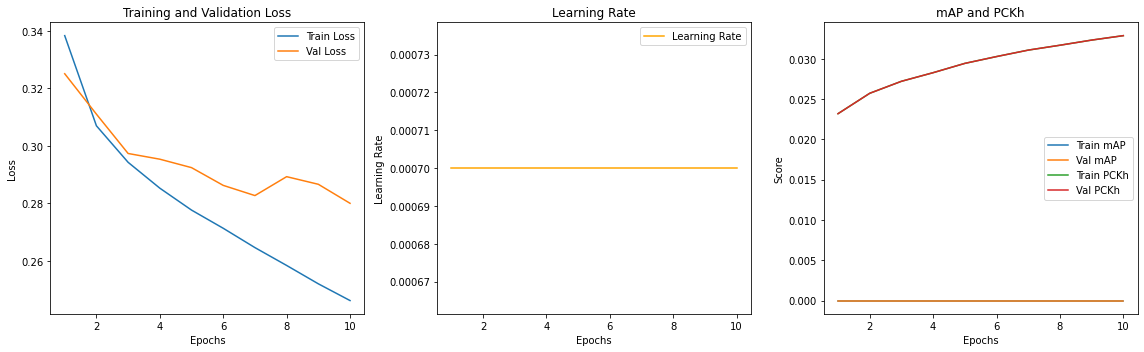

In [36]:
best_spb_model_file = spb_train(
    epochs=epochs,
    learning_rate=learning_rate,
    num_heatmap=num_heatmap,
    batch_size=batch_size,
    train_tfrecords=train_tfrecords,
    val_tfrecords=val_tfrecords
)

In [37]:
spb_model = Simplebaseline(IMAGE_SHAPE)
spb_model.load_weights(best_spb_model_file)

### STEP 3 : 두 모델의 비교
---
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)  

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

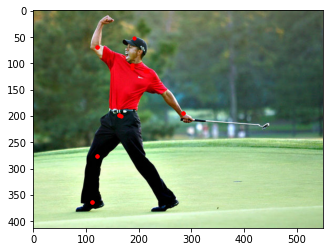

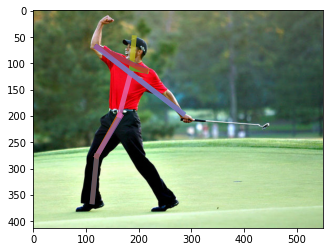

In [38]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

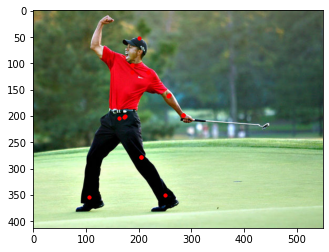

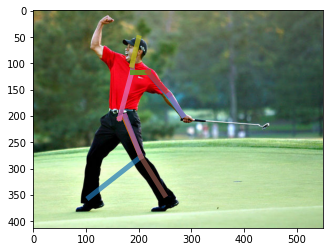

In [39]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(spb_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### Test 결과 기록
---

- 각 모델 1 epoch 결과
    - StackedHourglass Network
    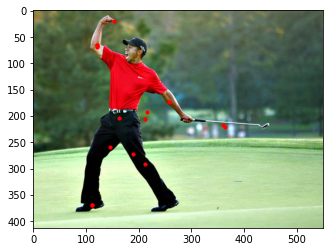
    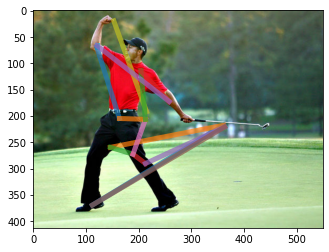  
    
    - Simplebaseline  
    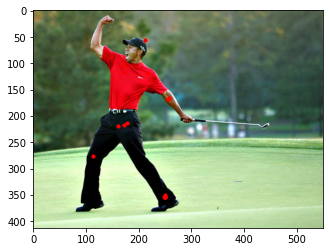
    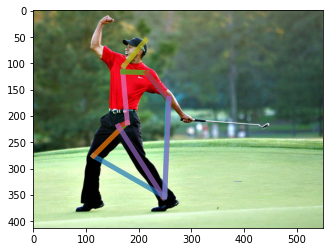

- 각 모델 10 epoch 결과
    - StackedHourglass Network
    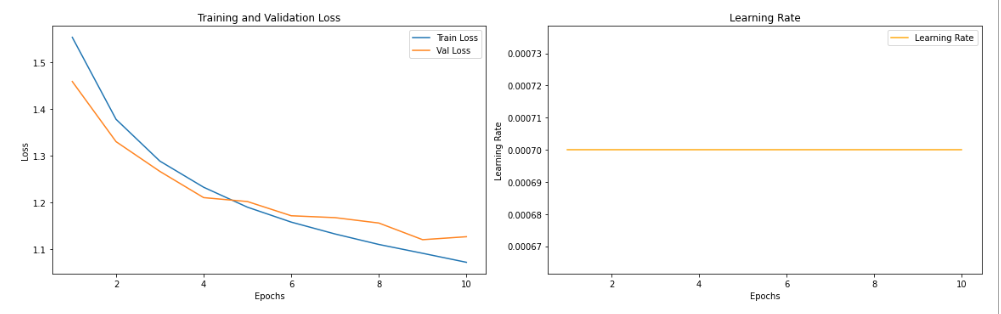
    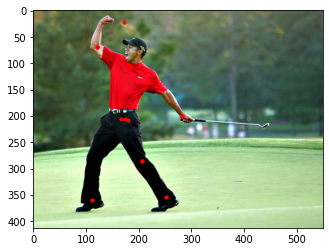
    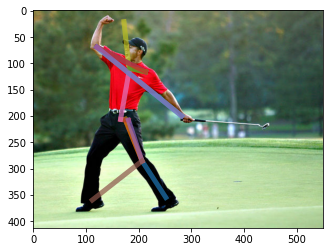
    
    - Simplebaseline  


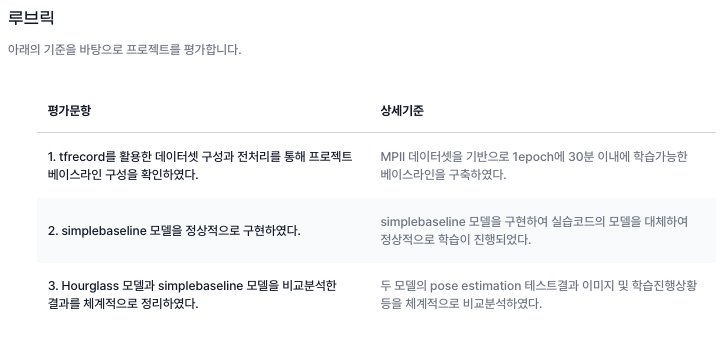